# SETUP

## Check environment

In [1]:
USE_GPU = False

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import joblib

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_3_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction, inferenceLSTM
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData
from src.data_utils import mice

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1760153317.508138 2092067 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760153317.514457 2092067 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760153317.530663 2092067 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760153317.530693 2092067 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760153317.530695 2092067 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760153317.530696 2092067 computation_placer.cc:177] computation placer already registered. Please check linka

Using CPU to train
2.19.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [3]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf["workspace"]["saved_model_plot_dir"])
cleanDir(conf["workspace"]["saved_model_weight_dir"])
cleanDir(conf["workspace"]["data_statistic_dir"])
cleanDir(conf["workspace"]["data_by_station_dir"])
cleanDir(conf["workspace"]["data_by_location_dir"])
cleanDir(conf["workspace"]["best_model_weight_dir"])
cleanDir(conf["workspace"]["best_reduced_data_dir"])

# CMAQ DATA

## Load dataset

### Raw data

In [4]:
df_cmaq_raw = []
for csv_file in glob.glob(f'{conf["dataset"]["cmaq"]["file_dir"]}/*'):
    df_current_station = pd.read_csv(csv_file).dropna(axis=1, how="all")
    station = csv_file.split("/")[-1].split(".")[0]
    print(f"{csv_file} - {len(df_current_station)} records")
    df_current_station["station"] = station
    df_cmaq_raw.append(df_current_station)
df_cmaq_raw = pd.concat(df_cmaq_raw, axis=0, ignore_index=True)
df_cmaq_raw

/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/216.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/212.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/201.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/215.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/213.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/214.csv - 7476 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station/211.csv - 7476 records


Date      Time       PM25       PM10        O3       SO2  \
0      01/01/2022   7:00:00   4.962867  17.781220  0.098060  0.000077   
1      01/01/2022   8:00:00   6.538577  23.655580  0.079992  0.000105   
2      01/01/2022   9:00:00   7.173492  25.594369  0.063973  0.000132   
3      01/01/2022  10:00:00   7.377719  26.746649  0.052615  0.000131   
4      01/01/2022  11:00:00   6.629785  23.692133  0.044166  0.000090   
...           ...       ...        ...        ...       ...       ...   
52327  31/12/2022   1:00:00  12.338016  44.975750  0.027149  0.000055   
52328  31/12/2022   2:00:00  12.207455  43.493079  0.026779  0.000055   
52329  31/12/2022   3:00:00  12.345228  45.676369  0.026994  0.000056   
52330  31/12/2022   4:00:00  12.455814  47.065511  0.026826  0.000057   
52331  31/12/2022   5:00:00  12.337399  44.779930  0.026044  0.000057   

            NO2 station  
0      0.000981     216  
1      0.001294     216  
2      0.001035     216  
3      0.000818     216  
4      0.000607     216  
...         ...     ...  
52327  0.000068     211  
52328  0.000067     211  
52329  0.000067     211  
52330  0.000067     211  
52331  0.000066     211  

[52332 rows x 8 columns]

### Handle metadata

In [5]:
# Merge Date and Time columns
df_cmaq_raw["time"] = df_cmaq_raw["Time"] + " " + df_cmaq_raw["Date"]
df_cmaq_raw["time"] = df_cmaq_raw["time"].apply(lambda element: datetime.strptime(element, "%H:%M:%S %d/%m/%Y"))
df_cmaq_raw = df_cmaq_raw.assign(time=pd.to_datetime(df_cmaq_raw["time"]))
df_cmaq_raw = df_cmaq_raw.assign(station=df_cmaq_raw["station"].astype("int64"))
df_cmaq_raw.drop(columns=["Date", "Time"], inplace=True)

# Rename columns
df_cmaq_raw = df_cmaq_raw.rename(columns={name: f"{name.lower()}" for name in df_cmaq_raw.columns})

# Sort data by "station" then "time"
df_cmaq_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_cmaq_raw.set_index("time", inplace=True)

# Print
df_cmaq_raw

pm25       pm10        o3       so2       no2  \
time                                                                      
2022-01-01 07:00:00   8.070718  28.069728  0.098301  0.000047  0.001115   
2022-01-01 08:00:00   9.922100  35.973360  0.078072  0.000062  0.001141   
2022-01-01 09:00:00  11.191617  40.858557  0.061198  0.000082  0.000941   
2022-01-01 10:00:00  11.655973  43.331055  0.050983  0.000087  0.000761   
2022-01-01 11:00:00  11.074831  39.380184  0.042117  0.000068  0.000600   
...                        ...        ...       ...       ...       ...   
2022-12-31 01:00:00   9.481827  34.121409  0.026421  0.000149  0.002276   
2022-12-31 02:00:00   9.389163  34.542116  0.026171  0.000148  0.002208   
2022-12-31 03:00:00   9.472814  34.649932  0.026087  0.000151  0.002249   
2022-12-31 04:00:00  10.222586  36.111460  0.026347  0.000166  0.002680   
2022-12-31 05:00:00  10.196095  36.470190  0.026102  0.000164  0.002590   

                     station  
time                          
2022-01-01 07:00:00      201  
2022-01-01 08:00:00      201  
2022-01-01 09:00:00      201  
2022-01-01 10:00:00      201  
2022-01-01 11:00:00      201  
...                      ...  
2022-12-31 01:00:00      216  
2022-12-31 02:00:00      216  
2022-12-31 03:00:00      216  
2022-12-31 04:00:00      216  
2022-12-31 05:00:00      216  

[52332 rows x 6 columns]

In [6]:
df_cmaq_raw.isnull().sum()

pm25       0
pm10       0
o3         0
so2        0
no2        0
station    0
dtype: int64

In [7]:
all_resampled_dfs = []
for station in df_cmaq_raw["station"].unique():
    df_cmaq_current_station = df_cmaq_raw[df_cmaq_raw["station"] == station]
    df_cmaq_current_station_resampled = df_cmaq_current_station.resample("D").mean()
    df_cmaq_current_station_resampled["station"] = station
    all_resampled_dfs.append(df_cmaq_current_station_resampled)

df_cmaq_daily = pd.concat(all_resampled_dfs, axis=0)
print(df_cmaq_daily["station"].unique())
df_cmaq_daily

[201 211 212 213 214 215 216]


pm25       pm10        o3       so2       no2  station
time                                                                   
2022-01-01  15.269127  48.407405  0.038950  0.000095  0.001809      201
2022-01-02  16.298580  59.344891  0.027448  0.000107  0.002403      201
2022-01-03  15.532542  56.512608  0.027952  0.000121  0.002359      201
2022-01-04  19.030452  66.483882  0.027218  0.000206  0.003297      201
2022-01-05  26.266464  82.340143  0.027566  0.000388  0.004734      201
...               ...        ...       ...       ...       ...      ...
2022-12-27  28.235250  78.640922  0.028089  0.001259  0.007881      216
2022-12-28  26.291384  77.514532  0.026661  0.000907  0.006642      216
2022-12-29  26.971063  63.326358  0.026366  0.000821  0.012799      216
2022-12-30  19.645784  52.679791  0.028655  0.000530  0.007603      216
2022-12-31   9.745557  34.890883  0.026313  0.000156  0.002431      216

[2555 rows x 6 columns]

In [8]:
df_cmaq_daily.isnull().sum()

pm25       42
pm10       42
o3         42
so2        42
no2        42
station     0
dtype: int64

### Fill missing values


Handling for station 201



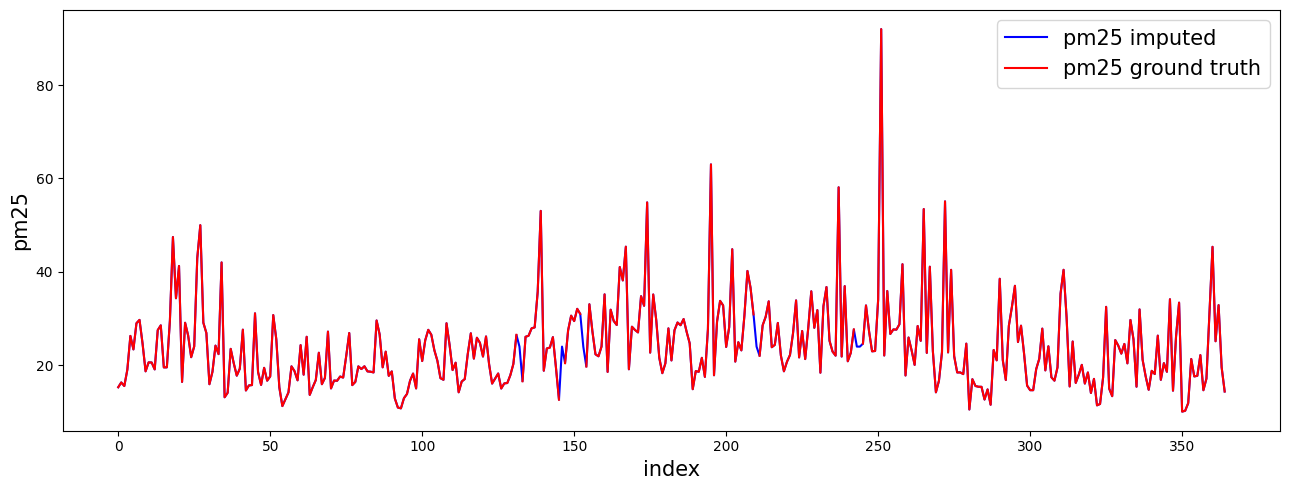


Handling for station 211



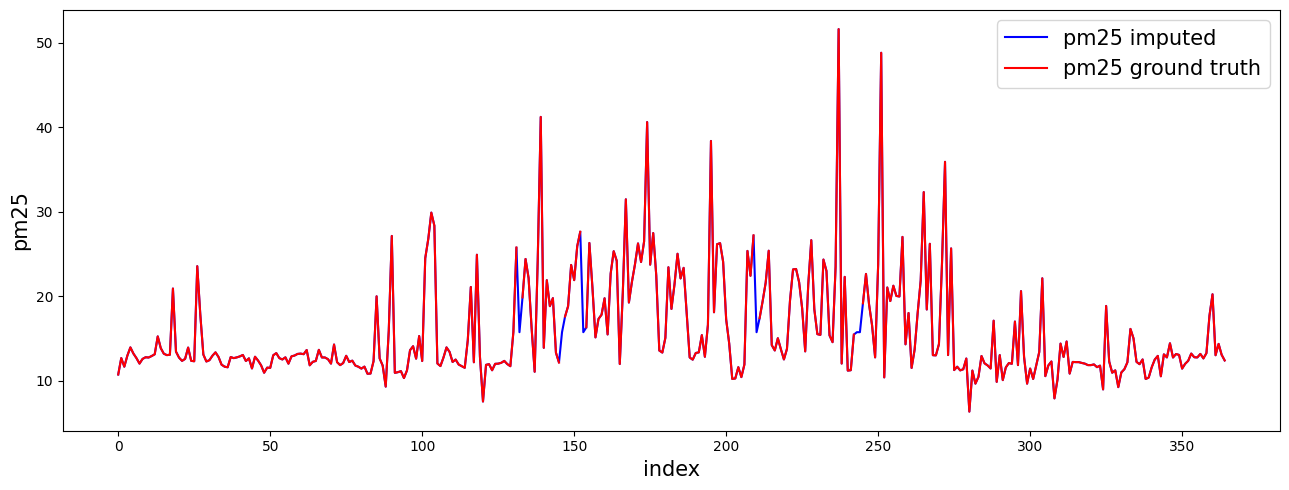


Handling for station 212



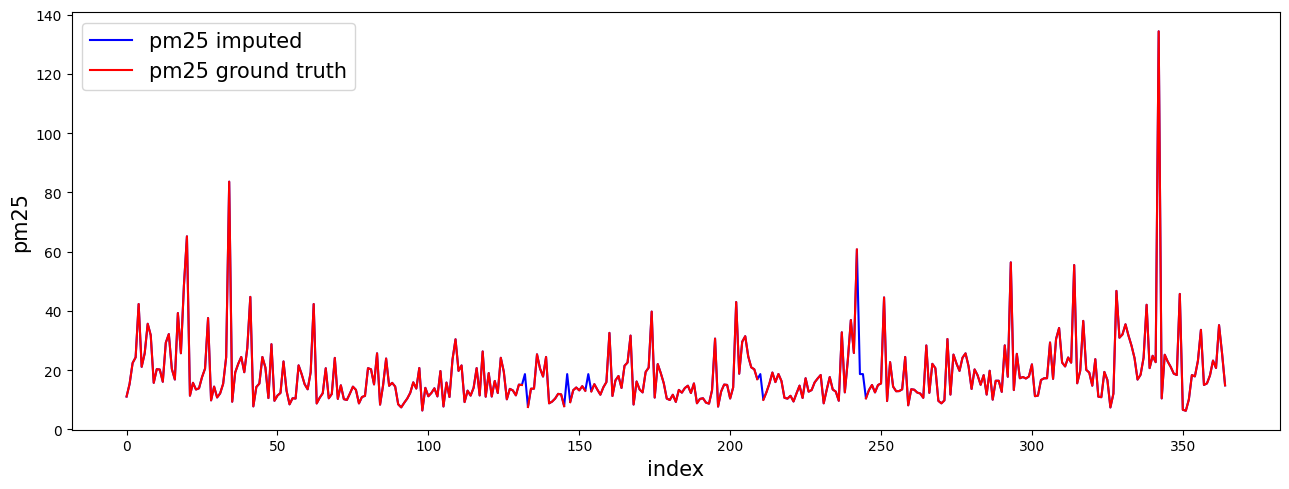


Handling for station 213



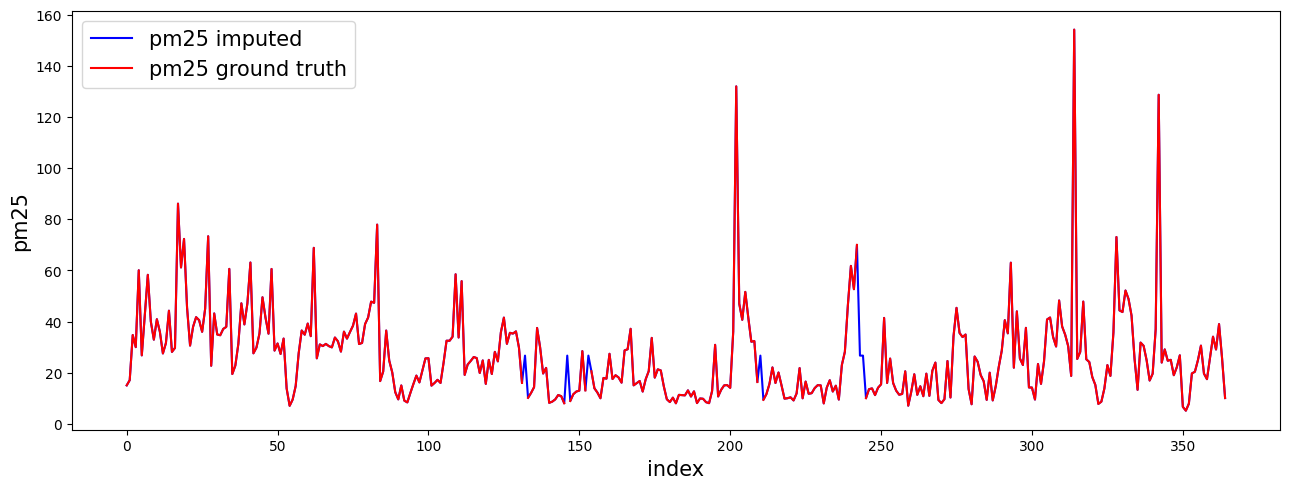


Handling for station 214



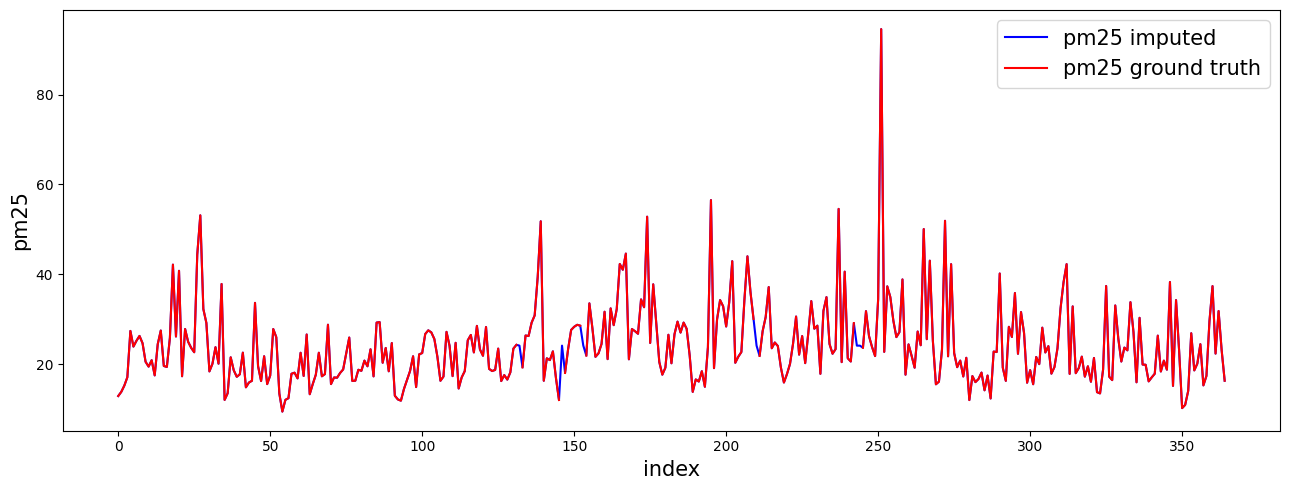


Handling for station 215



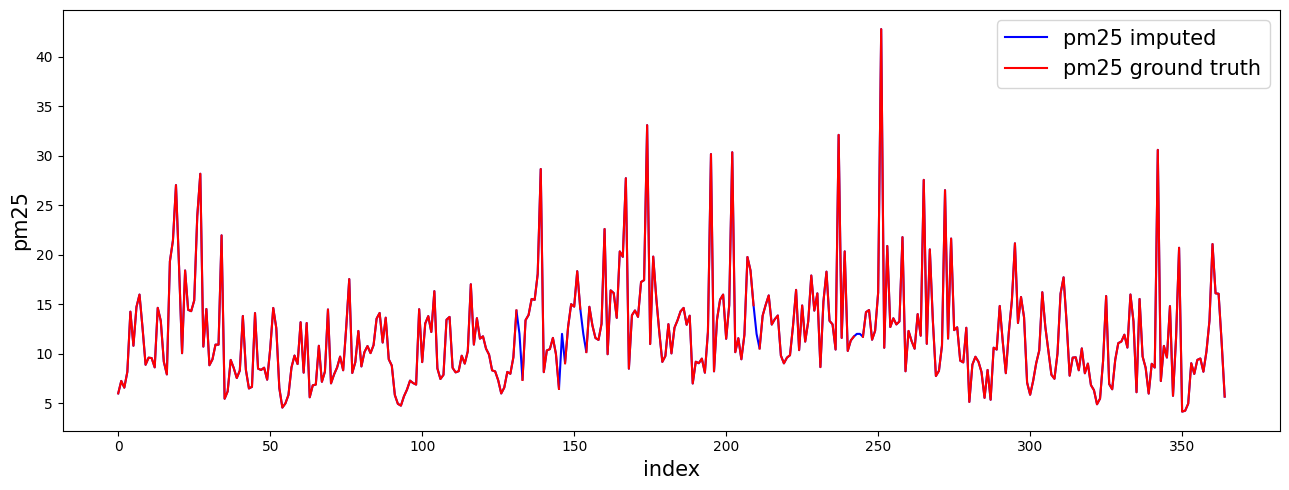


Handling for station 216



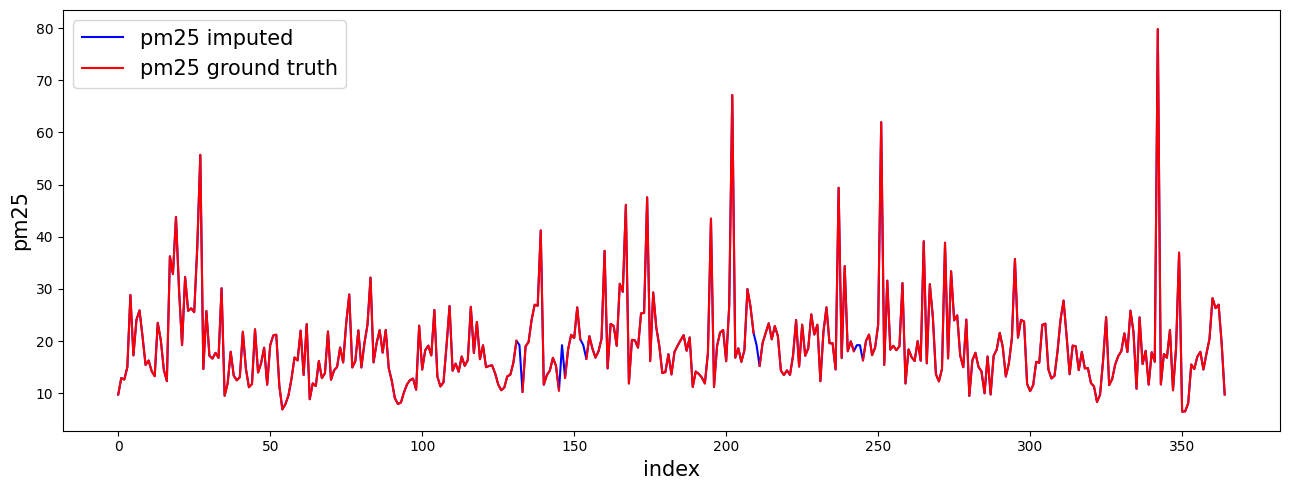

pm25       pm10        o3       so2       no2  station
time                                                                   
2022-01-01  15.269127  48.407405  0.038950  0.000095  0.001809      201
2022-01-02  16.298580  59.344891  0.027448  0.000107  0.002403      201
2022-01-03  15.532542  56.512608  0.027952  0.000121  0.002359      201
2022-01-04  19.030452  66.483882  0.027218  0.000206  0.003297      201
2022-01-05  26.266464  82.340143  0.027566  0.000388  0.004734      201
...               ...        ...       ...       ...       ...      ...
2022-12-27  28.235250  78.640922  0.028089  0.001259  0.007881      216
2022-12-28  26.291384  77.514532  0.026661  0.000907  0.006642      216
2022-12-29  26.971063  63.326358  0.026366  0.000821  0.012799      216
2022-12-30  19.645784  52.679791  0.028655  0.000530  0.007603      216
2022-12-31   9.745557  34.890883  0.026313  0.000156  0.002431      216

[2555 rows x 6 columns]

pm25        0
pm10       42
o3         42
so2        42
no2        42
station     0
dtype: int64


In [9]:
all_stations_df = []

for station in df_cmaq_daily["station"].unique():
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_cmaq_current_station = df_cmaq_daily[df_cmaq_daily["station"] == station]

    # Fill "aod" column
    df_cmaq_current_station_imputed = copy.deepcopy(df_cmaq_current_station)
    df_cmaq_current_station_imputed.loc[:, "pm25"] = mice(df_cmaq_current_station_imputed.drop(columns=["station"]))["pm25"]
    plot_2_data(data1=df_cmaq_current_station_imputed["pm25"],
               datalabel1="pm25 imputed",
               data2=df_cmaq_current_station["pm25"],
               datalabel2="pm25 ground truth",
               ylabel="pm25",
               xlabel="index")

    # Store file for debugging after filling missing values
    df_cmaq_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_cmaq_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_cmaq_current_station_imputed)

# Merge all stations
df_cmaq_daily = pd.concat(all_stations_df)
display(df_cmaq_daily)
print(df_cmaq_daily.isnull().sum())

# AOD DATA

## Load 2022 dataset

In [10]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


time  ID       pm25        lat         lon   PM25_3km        TMP  \
0    2022-01-01  S4  23.768238  10.815839  106.717396  22.025597  28.261583   
1    2022-01-01  S5  14.221014  10.776415  106.687955  22.705284  27.787918   
2    2022-01-01  S6  21.405015  10.780482  106.659511  23.503082  27.787918   
3    2022-01-01  S7  21.695652  10.783456  106.700622  22.705284  27.787918   
4    2022-01-02  S4  22.154723  10.815839  106.717396  22.711113  25.827082   
..          ...  ..        ...        ...         ...        ...        ...   
993  2022-12-30  S6  33.091428  10.780482  106.659511  19.854403  24.979719   
994  2022-12-30  S7  40.166667  10.783456  106.700622  19.137615  24.979719   
995  2022-12-31  S4  27.879261  10.815839  106.717396  28.223820  26.630608   
996  2022-12-31  S6  28.854069  10.780482  106.659511  27.658358  25.364861   
997  2022-12-31  S7  33.958333  10.783456  106.700622  26.659830  25.364861   

            RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0    57.233841  721.996887  2.003031  ...        2327.256348   2.546965   
1    61.073841  659.863586  1.885687  ...        7249.776367  21.703104   
2    61.073841  659.863586  1.885687  ...        2345.868408   6.057246   
3    61.073841  659.863586  1.885687  ...        6885.987305  18.537305   
4    57.916595  619.779785  1.286289  ...        2327.256348   2.546965   
..         ...         ...       ...  ...                ...        ...   
993  64.868401  680.533081  3.893373  ...        2345.868408   6.057246   
994  64.868401  680.533081  3.893373  ...        6885.987305  18.537305   
995  55.437901  607.372803  4.217750  ...        2327.256348   2.546965   
996  62.377899  799.122803  4.161542  ...        2345.868408   6.057246   
997  62.377899  799.122803  4.161542  ...        6885.987305  18.537305   

         BARELAND      BUILTUP   CROPLAND    GRASSLAND     TREECOVER  \
0     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
1      395.082094  877872.4121    0.00000    98.770523  121487.74380   
2    10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
3      296.311570  764977.7039    0.00000  1876.639945  232011.95950   
4     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
..            ...          ...        ...          ...           ...   
993  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
994    296.311570  764977.7039    0.00000  1876.639945  232011.95950   
995   1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
996  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
997    296.311570  764977.7039    0.00000  1876.639945  232011.95950   

           WATER         NDVI  \
0    61731.57713  1818.661486   
1        0.00000  1721.431568   
2        0.00000  1879.344348   
3        0.00000  2700.122924   
4    61731.57713  1818.661486   
..           ...          ...   
993      0.00000  1879.344348   
994      0.00000  2700.122924   
995  61731.57713  1818.661486   
996      0.00000  1879.344348   
997      0.00000  2700.122924   

                                                  Name  
0    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
1     Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3  
2                             MobiFone Thành Thái, Q10  
3                                               ĐSQ Mỹ  
4    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
..                                                 ...  
993                           MobiFone Thành Thái, Q10  
994                                             ĐSQ Mỹ  
995  Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
996                           MobiFone Thành Thái, Q10  
997                                             ĐSQ Mỹ  

[998 rows x 25 columns]

In [11]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
#df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Print
df_aod_raw_2022

time       pm25        lat         lon   pm25_3km        tmp  \
0   2022-01-01  23.768238  10.815839  106.717396  22.025597  28.261583   
1   2022-01-01  14.221014  10.776415  106.687955  22.705284  27.787918   
2   2022-01-01  21.405015  10.780482  106.659511  23.503082  27.787918   
3   2022-01-01  21.695652  10.783456  106.700622  22.705284  27.787918   
4   2022-01-02  22.154723  10.815839  106.717396  22.711113  25.827082   
..         ...        ...        ...         ...        ...        ...   
993 2022-12-30  33.091428  10.780482  106.659511  19.854403  24.979719   
994 2022-12-30  40.166667  10.783456  106.700622  19.137615  24.979719   
995 2022-12-31  27.879261  10.815839  106.717396  28.223820  26.630608   
996 2022-12-31  28.854069  10.780482  106.659511  27.658358  25.364861   
997 2022-12-31  33.958333  10.783456  106.700622  26.659830  25.364861   

            rh        hpbl      wspd         pres2m  ...  road_den_1km  \
0    57.233841  721.996887  2.003031  101227.000000  ...     22.923040   
1    61.073841  659.863586  1.885687  101204.875000  ...     23.362053   
2    61.073841  659.863586  1.885687  101204.875000  ...     33.629780   
3    61.073841  659.863586  1.885687  101204.875000  ...     27.462461   
4    57.916595  619.779785  1.286289  101201.015625  ...     22.923040   
..         ...         ...       ...            ...  ...           ...   
993  64.868401  680.533081  3.893373  101393.398438  ...     33.629780   
994  64.868401  680.533081  3.893373  101393.398438  ...     27.462461   
995  55.437901  607.372803  4.217750  101322.437500  ...     22.923040   
996  62.377899  799.122803  4.161542  101297.140625  ...     33.629780   
997  62.377899  799.122803  4.161542  101297.140625  ...     27.462461   

     prim_road_len_1km  near_dist      bareland      builtup   cropland  \
0          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
1          7249.776367  21.703104    395.082094  877872.4121    0.00000   
2          2345.868408   6.057246  10370.904960  885181.4309    0.00000   
3          6885.987305  18.537305    296.311570  764977.7039    0.00000   
4          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
..                 ...        ...           ...          ...        ...   
993        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
994        6885.987305  18.537305    296.311570  764977.7039    0.00000   
995        2327.256348   2.546965   1876.639945  841524.8595  296.31157   
996        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
997        6885.987305  18.537305    296.311570  764977.7039    0.00000   

       grassland     treecover        water         ndvi  
0    3753.279890   91461.50468  61731.57713  1818.661486  
1      98.770523  121487.74380      0.00000  1721.431568  
2    8099.182920   95807.40771      0.00000  1879.344348  
3    1876.639945  232011.95950      0.00000  2700.122924  
4    3753.279890   91461.50468  61731.57713  1818.661486  
..           ...           ...          ...          ...  
993  8099.182920   95807.40771      0.00000  1879.344348  
994  1876.639945  232011.95950      0.00000  2700.122924  
995  3753.279890   91461.50468  61731.57713  1818.661486  
996  8099.182920   95807.40771      0.00000  1879.344348  
997  1876.639945  232011.95950      0.00000  2700.122924  

[998 rows x 23 columns]

In [12]:
df_aod_raw_2022["station"].unique()

array([214, 215, 216, 201])

## Load 2018-2021 dataset

In [13]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


time   ID       pm25        Lat         Lon   PM25_3km        TMP  \
0       1/1/2018  201  31.391304  10.783057  106.700606  34.919998  25.204139   
1       1/1/2018  202  29.615625  10.762638  106.682027  32.099998  25.100436   
2       1/2/2018  201  37.458333  10.783057  106.700606  51.830002  24.726431   
3       1/2/2018  202  36.244792  10.762638  106.682027  44.619999  24.663358   
4       1/3/2018  201  68.083333  10.783057  106.700606  38.240002  26.095087   
...          ...  ...        ...        ...         ...        ...        ...   
2886  12/31/2021  211  14.474306  10.870190  106.796200  17.930000  23.428631   
2887  12/31/2021  212  20.100752  10.740760  106.617000  20.010000  24.914532   
2888  12/31/2021  213  23.240539  10.816350  106.620500  20.700001  24.171986   
2889  12/31/2021  214  20.549839  10.815570  106.717500  21.040001  24.367620   
2890  12/31/2021  216  19.637165  10.780630  106.659300  20.840000  22.830532   

             RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0     70.056728  455.131335  2.352895  ...        6885.987305  18.537305   
1     71.060891  457.243423  2.344162  ...        7097.612305   3.822386   
2     73.425826  339.083720  1.903761  ...        6885.987305  18.537305   
3     73.870799  338.530190  1.885305  ...        7097.612305   3.822386   
4     77.793432  367.190738  1.293329  ...        6885.987305  18.537305   
...         ...         ...       ...  ...                ...        ...   
2886  75.209297  134.323181  1.485907  ...           0.000000  49.023548   
2887  64.741638  212.347687  2.196620  ...        2529.119629  20.331284   
2888  67.759666  145.481979  2.459679  ...           0.000000   7.560823   
2889  67.038559  168.648315  2.101351  ...        2327.256348   2.546965   
2890  79.056641  184.397690  2.316177  ...        2345.868408   6.057246   

          BARELAND      BUILTUP     CROPLAND     GRASSLAND     TREECOVER  \
0       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
1       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
2       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
3       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
4       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
...            ...          ...          ...           ...           ...   
2886   1086.475758  724185.4777   592.623140  46915.998620  225888.18710   
2887  16297.136360  892984.3022  7506.559780  26470.500280   57681.98567   
2888  13136.479610  928245.3791  4247.132507  17581.153170   34964.76529   
2889   1876.639945  841524.8595   296.311570   3753.279890   91461.50468   
2890  10370.904960  885181.4309     0.000000   8099.182920   95807.40771   

             WATER         NDVI       AOD  
0         0.000000  2700.122924       NaN  
1     35063.535810  1765.098553       NaN  
2         0.000000  2700.122924  1.110117  
3     35063.535810  1765.098553  1.277641  
4         0.000000  2700.122924  1.439045  
...            ...          ...       ...  
2886      0.000000  3579.160484       NaN  
2887      0.000000  3266.283480       NaN  
2888   1481.557851  2535.126792  0.272610  
2889  61731.577130  1818.661486  0.524898  
2890      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [14]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns}, inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Print
df_aod_raw_2021

time  station       pm25        lat         lon   pm25_3km  \
0    2018-01-01      201  31.391304  10.783057  106.700606  34.919998   
1    2018-01-01      202  29.615625  10.762638  106.682027  32.099998   
2    2018-01-02      201  37.458333  10.783057  106.700606  51.830002   
3    2018-01-02      202  36.244792  10.762638  106.682027  44.619999   
4    2018-01-03      201  68.083333  10.783057  106.700606  38.240002   
...         ...      ...        ...        ...         ...        ...   
2886 2021-12-31      211  14.474306  10.870190  106.796200  17.930000   
2887 2021-12-31      212  20.100752  10.740760  106.617000  20.010000   
2888 2021-12-31      213  23.240539  10.816350  106.620500  20.700001   
2889 2021-12-31      214  20.549839  10.815570  106.717500  21.040001   
2890 2021-12-31      216  19.637165  10.780630  106.659300  20.840000   

            tmp         rh        hpbl      wspd  ...  prim_road_len_1km  \
0     25.204139  70.056728  455.131335  2.352895  ...        6885.987305   
1     25.100436  71.060891  457.243423  2.344162  ...        7097.612305   
2     24.726431  73.425826  339.083720  1.903761  ...        6885.987305   
3     24.663358  73.870799  338.530190  1.885305  ...        7097.612305   
4     26.095087  77.793432  367.190738  1.293329  ...        6885.987305   
...         ...        ...         ...       ...  ...                ...   
2886  23.428631  75.209297  134.323181  1.485907  ...           0.000000   
2887  24.914532  64.741638  212.347687  2.196620  ...        2529.119629   
2888  24.171986  67.759666  145.481979  2.459679  ...           0.000000   
2889  24.367620  67.038559  168.648315  2.101351  ...        2327.256348   
2890  22.830532  79.056641  184.397690  2.316177  ...        2345.868408   

      near_dist      bareland      builtup     cropland     grassland  \
0     18.537305    296.311570  764977.7039     0.000000   1876.639945   
1      3.822386    395.082094  947604.4016     0.000000   2963.115702   
2     18.537305    296.311570  764977.7039     0.000000   1876.639945   
3      3.822386    395.082094  947604.4016     0.000000   2963.115702   
4     18.537305    296.311570  764977.7039     0.000000   1876.639945   
...         ...           ...          ...          ...           ...   
2886  49.023548   1086.475758  724185.4777   592.623140  46915.998620   
2887  20.331284  16297.136360  892984.3022  7506.559780  26470.500280   
2888   7.560823  13136.479610  928245.3791  4247.132507  17581.153170   
2889   2.546965   1876.639945  841524.8595   296.311570   3753.279890   
2890   6.057246  10370.904960  885181.4309     0.000000   8099.182920   

         treecover         water         ndvi       aod  
0     232011.95950      0.000000  2700.122924       NaN  
1      13926.64380  35063.535810  1765.098553       NaN  
2     232011.95950      0.000000  2700.122924  1.110117  
3      13926.64380  35063.535810  1765.098553  1.277641  
4     232011.95950      0.000000  2700.122924  1.439045  
...            ...           ...          ...       ...  
2886  225888.18710      0.000000  3579.160484       NaN  
2887   57681.98567      0.000000  3266.283480       NaN  
2888   34964.76529   1481.557851  2535.126792  0.272610  
2889   91461.50468  61731.577130  1818.661486  0.524898  
2890   95807.40771      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [15]:
df_aod_raw_2021["station"].unique()

array([201, 202, 211, 212, 213, 214, 215, 216])

## Merge dataset

In [16]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_aod_raw.set_index("time", inplace=True)

# Print
df_aod_raw

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2018-01-01      201  31.391304  10.783057  106.700606  34.919998  25.204139   
2018-01-02      201  37.458333  10.783057  106.700606  51.830002  24.726431   
2018-01-03      201  68.083333  10.783057  106.700606  38.240002  26.095087   
2018-01-04      201  51.260870  10.783057  106.700606  40.259998  26.514926   
2018-01-05      201  18.909091  10.783057  106.700606  21.690001  25.483535   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2018-01-01  70.056728  455.131335  2.352895  20680.62695  ...   
2018-01-02  73.425826  339.083720  1.903761  20680.62695  ...   
2018-01-03  77.793432  367.190738  1.293329  20680.62695  ...   
2018-01-04  82.982475  462.504210  1.588872  20680.62695  ...   
2018-01-05  93.046504  324.735356  2.505876  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2018-01-01  1876.639945  232011.95950    0.0  2700.122924       NaN  
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117  
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045  
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595  
2018-01-05  1876.639945  232011.95950    0.0  2700.122924       NaN  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348       NaN  

[3889 rows x 21 columns]

In [17]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## EDA

In [18]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')
display(df_aod_stat.iloc[:, 0:7])
display(df_aod_stat.iloc[:, 7:14])
display(df_aod_stat.iloc[:, 14:22])

station         pm25          lat          lon     pm25_3km  \
count  3889.000000  3889.000000  3889.000000  3889.000000  3889.000000   
mean    207.520185    23.011572    10.788306   106.689282    20.046538   
std       6.563450    10.301408     0.025632     0.037486     9.668466   
min     201.000000     4.333333    10.740760   106.617000     5.440000   
25%     201.000000    15.444042    10.780482   106.659511    13.147358   
50%     202.000000    20.583333    10.783057   106.700606    17.610001   
75%     214.000000    28.387500    10.783456   106.700606    24.095436   
max     216.000000    87.416667    10.870190   106.796200    96.139999   

               tmp           rh  
count  3889.000000  3889.000000  
mean     27.486412    75.352473  
std       1.330104     8.409504  
min      21.016206    48.819080  
25%      26.632843    69.889214  
50%      27.570251    75.316635  
75%      28.413069    81.705930  
max      33.235374    94.121568

hpbl         wspd           pop  road_den_1km  \
count  3889.000000  3889.000000   3889.000000   3889.000000   
mean    581.026019     3.000106  29817.660439     27.142390   
std     147.090395     0.961473  15836.834517      4.811024   
min      63.078468     1.076171  14886.636720     18.211647   
25%     481.499541     2.329683  20680.626950     23.362053   
50%     578.328613     2.836771  20680.626950     27.462461   
75%     678.799988     3.507094  35151.593750     27.462461   
max    1367.739014     8.555794  64615.492190     37.829433   

       prim_road_len_1km    near_dist      bareland  
count        3889.000000  3889.000000   3889.000000  
mean         4713.665609    14.797250   3729.457120  
std          2633.314899    10.196835   5363.607284  
min             0.000000     2.546965    296.311570  
25%          2345.868408     6.057246    296.311570  
50%          6885.987305    18.537305    395.082094  
75%          6885.987305    18.537305  10370.904960  
max          7249.776367    49.023548  16297.136360

builtup     cropland     grassland      treecover         water  \
count    3889.000000  3889.000000   3889.000000    3889.000000   3889.000000   
mean   826149.166557   791.891211   7445.402819  151188.057970  10303.855798   
std     68115.590713  2014.178049  10884.016211   81458.618501  21540.755659   
min    724185.477700     0.000000     98.770523   13926.643800      0.000000   
25%    764977.703900     0.000000   1876.639945   91461.504680      0.000000   
50%    841524.859500     0.000000   2963.115702  121487.743800      0.000000   
75%    885181.430900   296.311570   8099.182920  232011.959500   1481.557851   
max    947604.401600  7506.559780  46915.998620  232011.959500  61731.577130   

              ndvi         aod  
count  3889.000000  661.000000  
mean   2418.324453    0.682687  
std     534.284396    0.520347  
min    1721.431568    0.001282  
25%    1818.661486    0.298638  
50%    2700.122924    0.502724  
75%    2700.122924    0.933905  
max    3579.160484    3.098711

In [19]:
df_aod_raw.isnull().sum()

station                 0
pm25                    0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  3228
dtype: int64

### Statistic for each station

In [20]:
for station in df_aod_raw["station"].unique():
    df_current_station = df_aod_raw[df_aod_raw["station"] == station]
    print(f"Station = {station}")
    print(f"Number of records: {len(df_current_station)}")
    print(f"Start date = {df_current_station.index[0]}, end data = {df_current_station.index[-1]}")
    print("=" * 100)

Station = 201
Number of records: 1711
Start date = 2018-01-01 00:00:00, end data = 2022-12-31 00:00:00
Station = 202
Number of records: 253
Start date = 2018-01-01 00:00:00, end data = 2019-03-31 00:00:00
Station = 211
Number of records: 173
Start date = 2021-03-01 00:00:00, end data = 2021-12-31 00:00:00
Station = 212
Number of records: 249
Start date = 2021-03-01 00:00:00, end data = 2021-12-31 00:00:00
Station = 213
Number of records: 226
Start date = 2021-03-01 00:00:00, end data = 2021-12-31 00:00:00
Station = 214
Number of records: 500
Start date = 2021-03-01 00:00:00, end data = 2022-12-31 00:00:00
Station = 215
Number of records: 232
Start date = 2021-03-01 00:00:00, end data = 2022-07-07 00:00:00
Station = 216
Number of records: 545
Start date = 2021-04-02 00:00:00, end data = 2022-12-31 00:00:00


### Correlation matrix

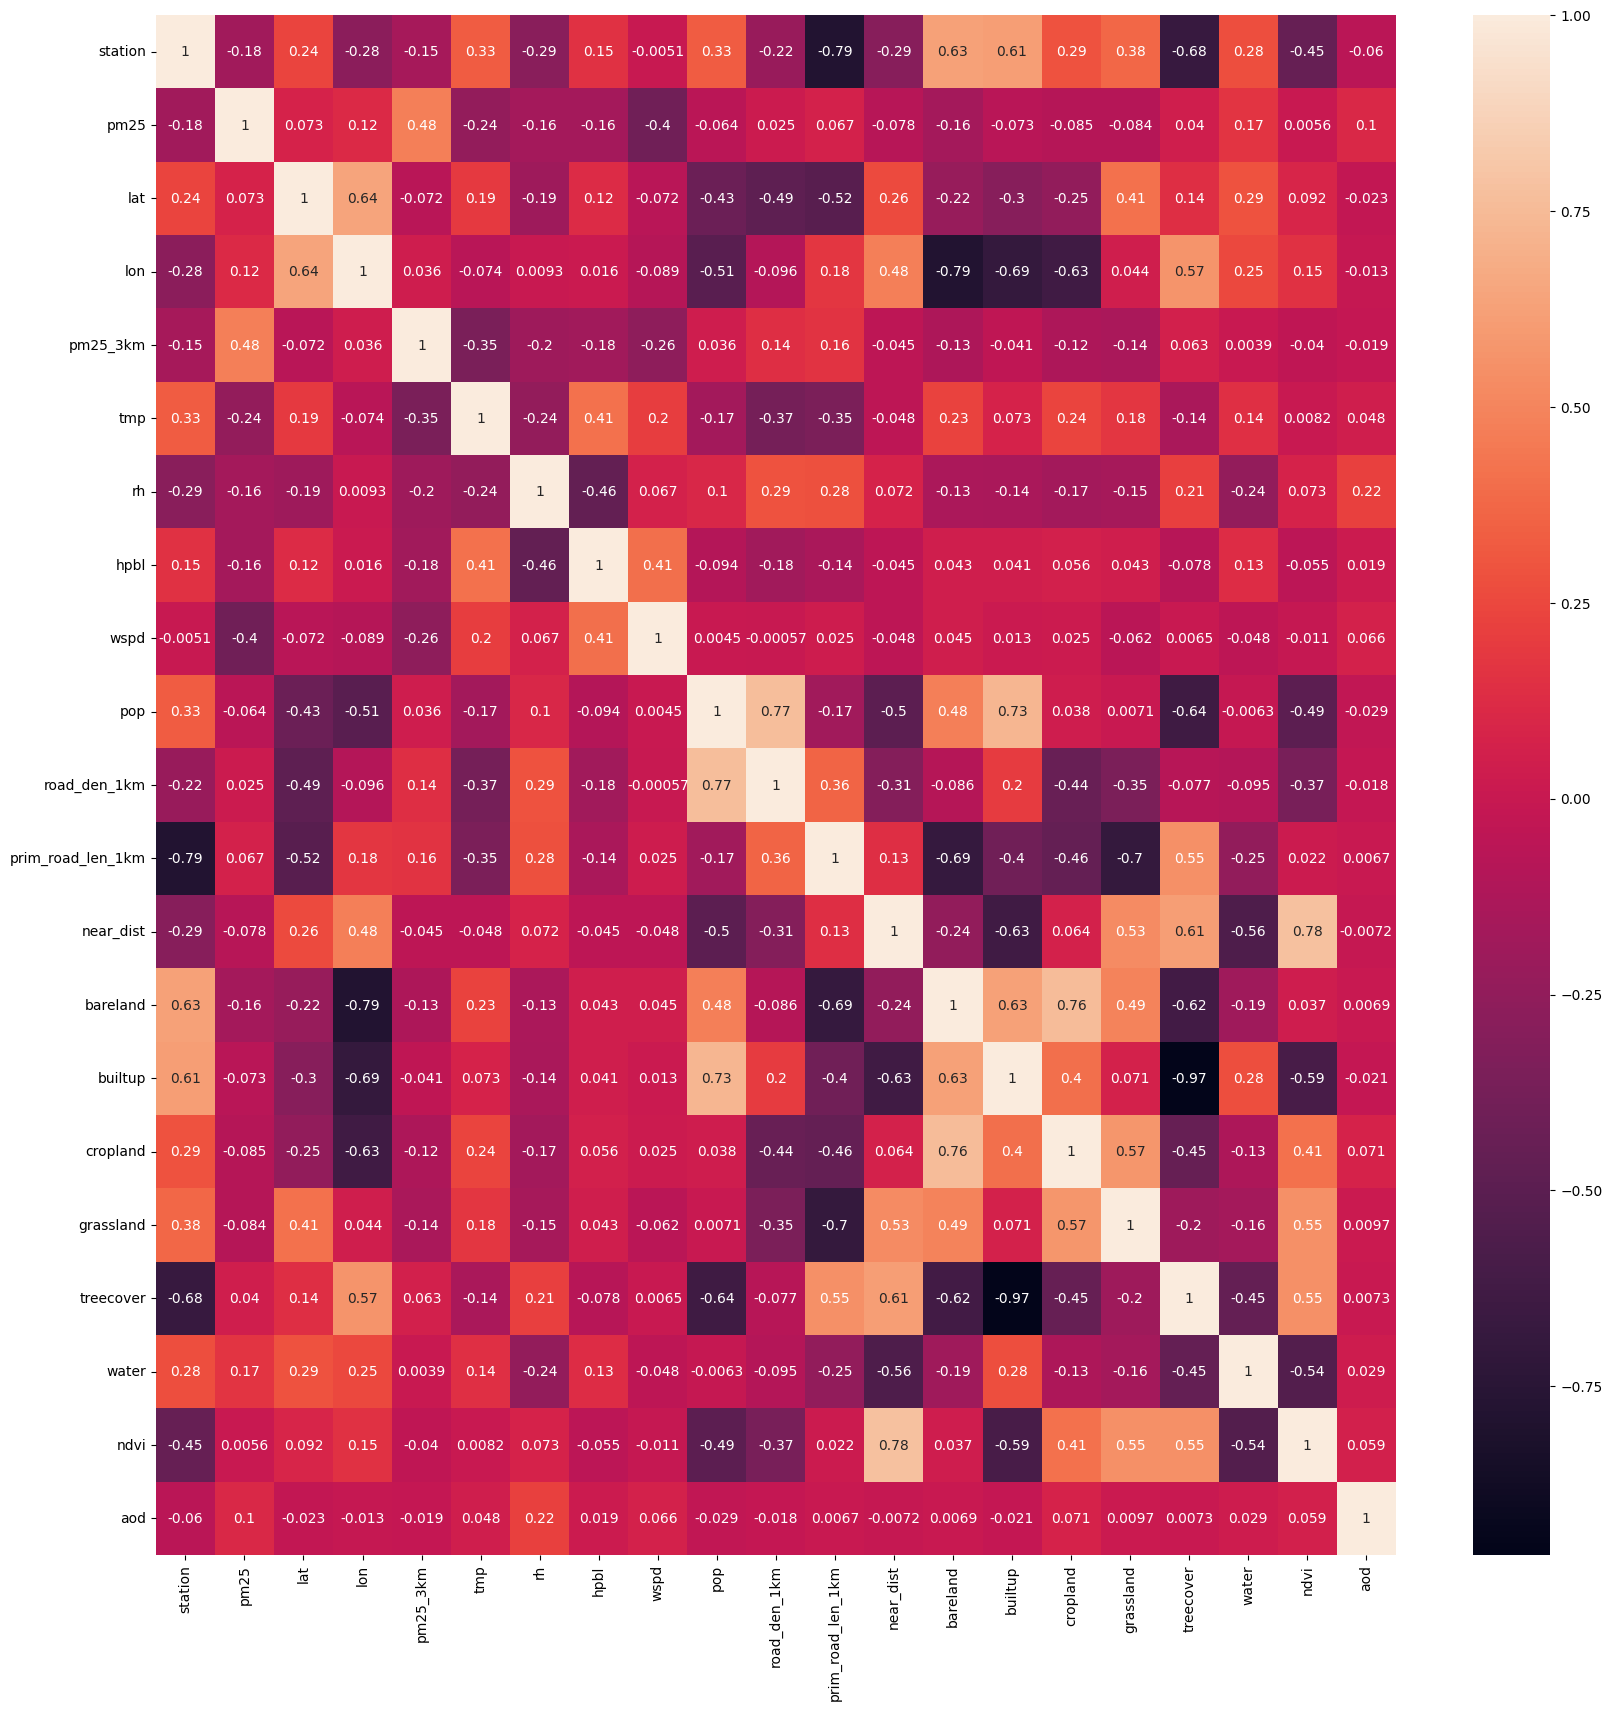

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df_aod_raw.corr(), annot=True, ax=ax)
plt.show()

## Preprocessing

### Define label, static features and dynamic features

In [22]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['pm25_3km', 'hpbl', 'rh', 'aod', 'tmp', 'wspd']
aod_all_stations = [np.int64(201), np.int64(202), np.int64(211), np.int64(212), np.int64(213), np.int64(214), np.int64(215), np.int64(216)]


### Fill "aod" column


Handling for station 201



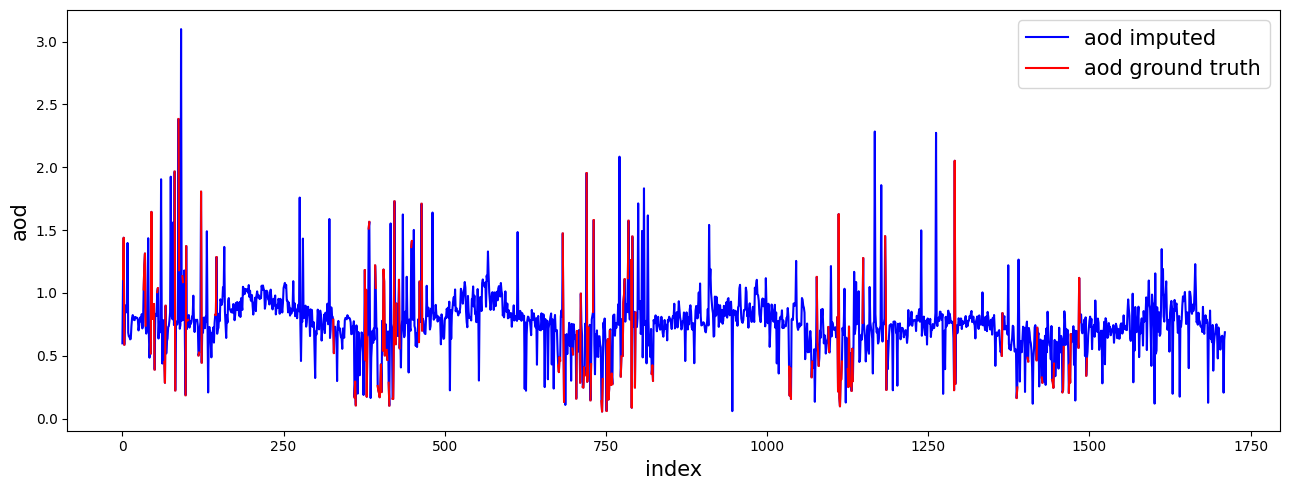


Handling for station 202



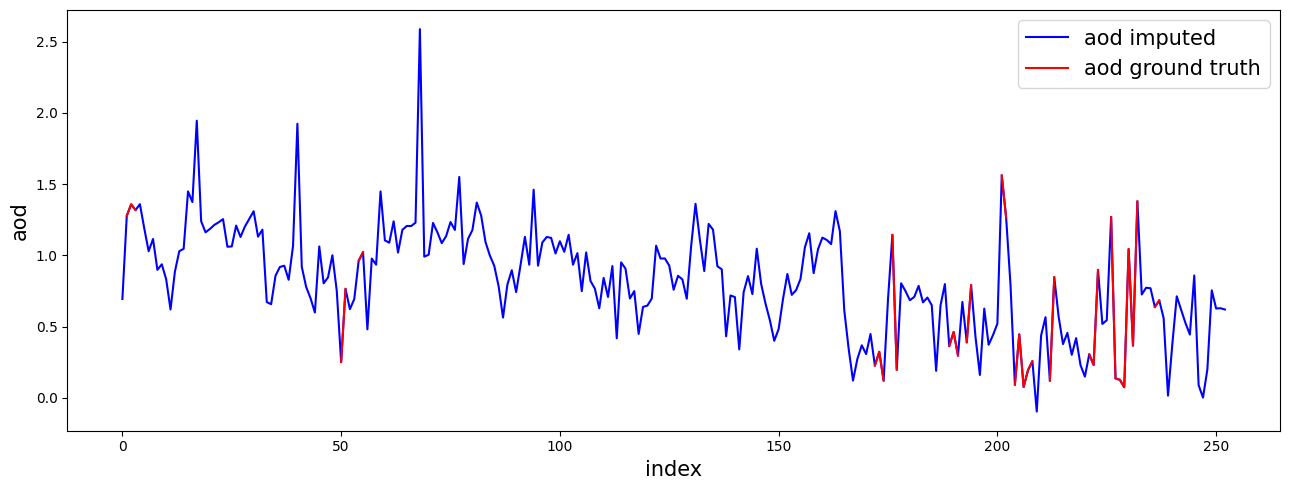


Handling for station 211



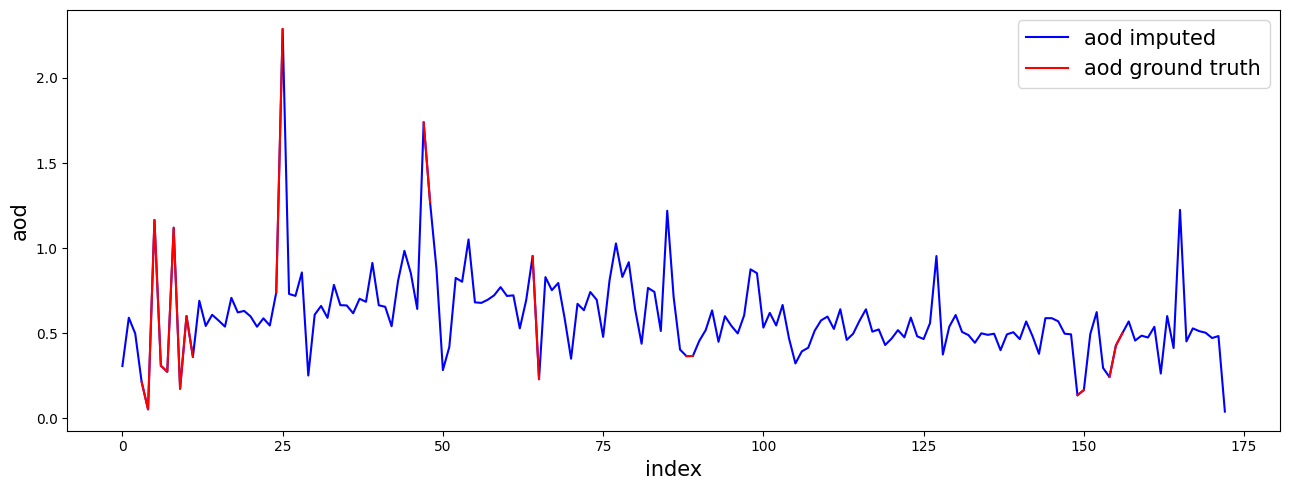


Handling for station 212



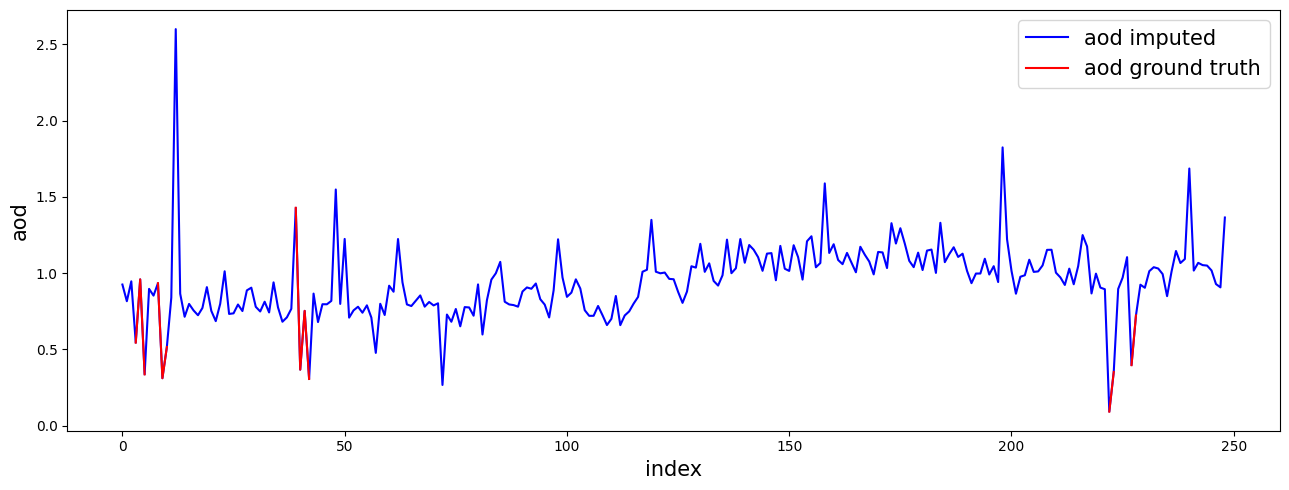


Handling for station 213



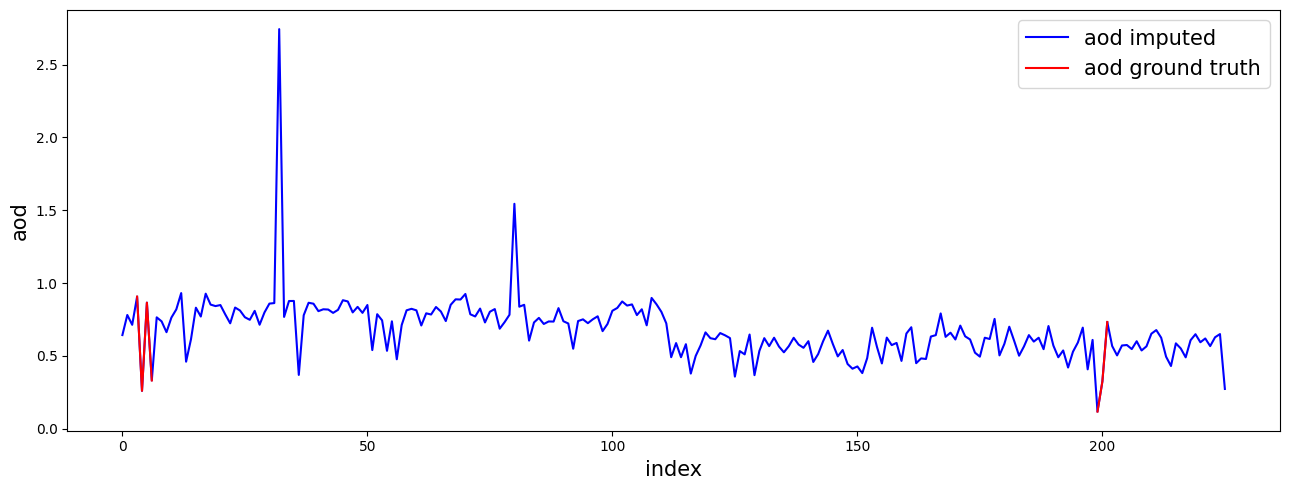


Handling for station 214



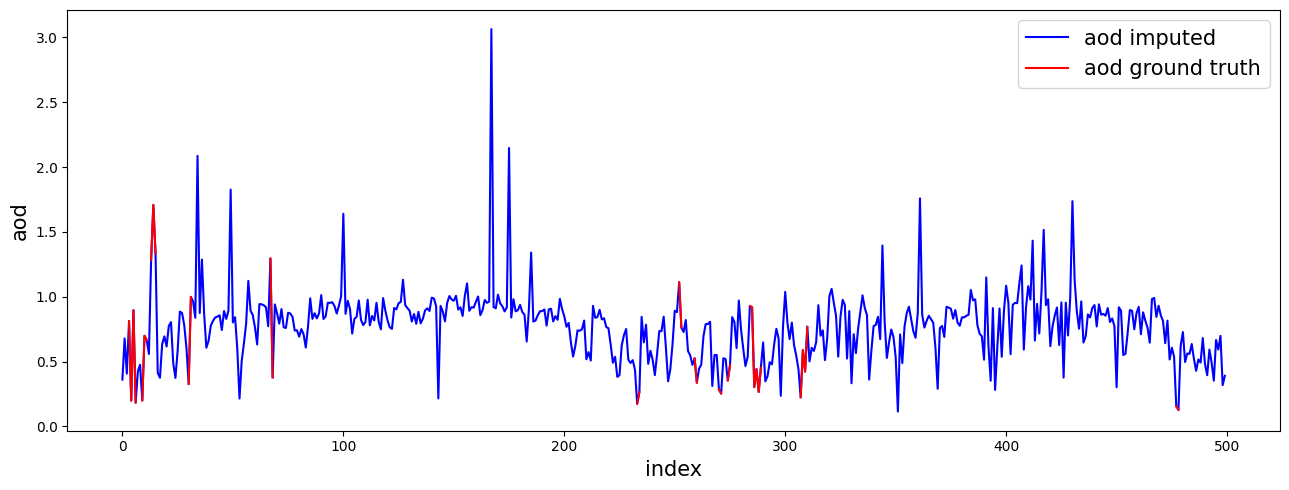


Handling for station 215



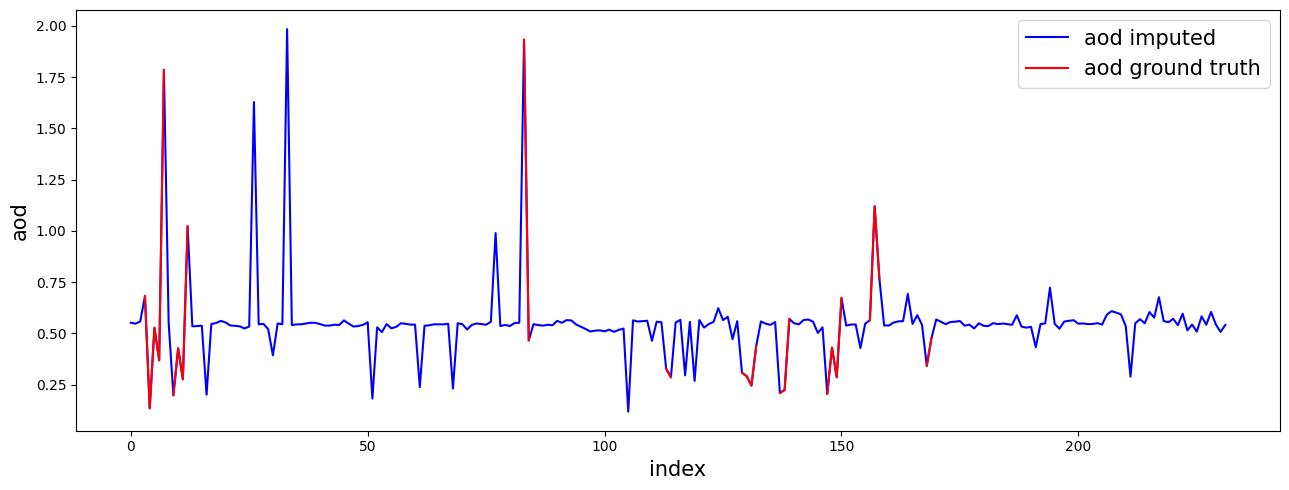


Handling for station 216



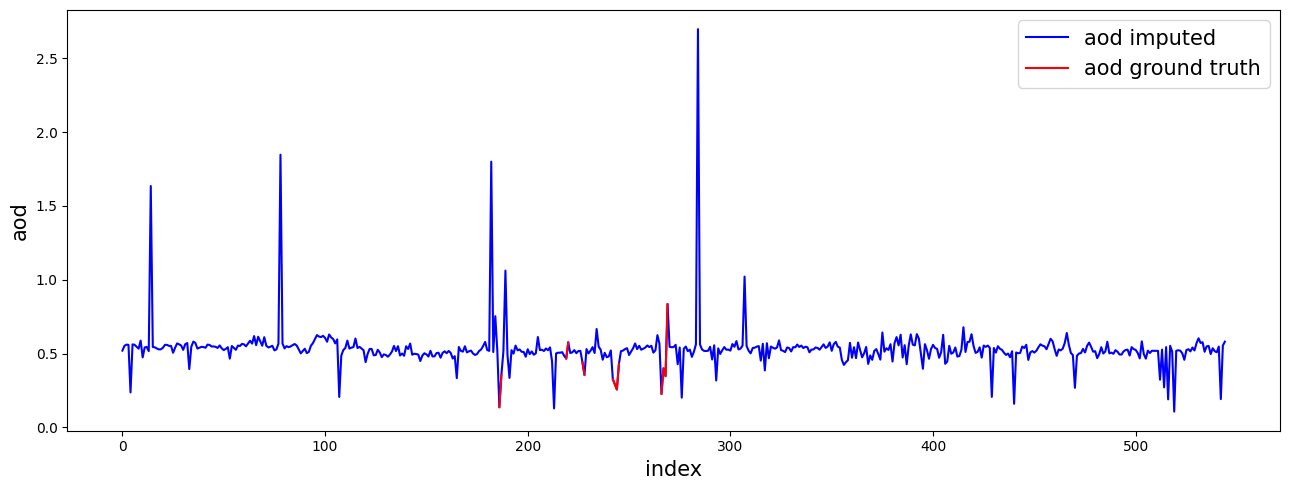

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2018-01-01      201  31.391304  10.783057  106.700606  34.919998  25.204139   
2018-01-02      201  37.458333  10.783057  106.700606  51.830002  24.726431   
2018-01-03      201  68.083333  10.783057  106.700606  38.240002  26.095087   
2018-01-04      201  51.260870  10.783057  106.700606  40.259998  26.514926   
2018-01-05      201  18.909091  10.783057  106.700606  21.690001  25.483535   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2018-01-01  70.056728  455.131335  2.352895  20680.62695  ...   
2018-01-02  73.425826  339.083720  1.903761  20680.62695  ...   
2018-01-03  77.793432  367.190738  1.293329  20680.62695  ...   
2018-01-04  82.982475  462.504210  1.588872  20680.62695  ...   
2018-01-05  93.046504  324.735356  2.505876  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2018-01-01  1876.639945  232011.95950    0.0  2700.122924  0.599173  
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117  
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045  
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595  
2018-01-05  1876.639945  232011.95950    0.0  2700.122924  0.852506  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505  

[3889 rows x 21 columns]

In [23]:
all_stations_df = []

for station in aod_all_stations:
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]

    # Fill "aod" column
    df_aod_current_station_imputed = copy.deepcopy(df_aod_current_station)
    df_aod_current_station_imputed.loc[:, "aod"] = mice(df_aod_current_station_imputed.drop(columns=["station", "pm25"]))["aod"]
    plot_2_data(data1=df_aod_current_station_imputed["aod"],
               datalabel1="aod imputed",
               data2=df_aod_current_station["aod"],
               datalabel2="aod ground truth",
               ylabel="aod",
               xlabel="index")

    # Store file for debugging after filling missing values
    df_aod_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station_imputed)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

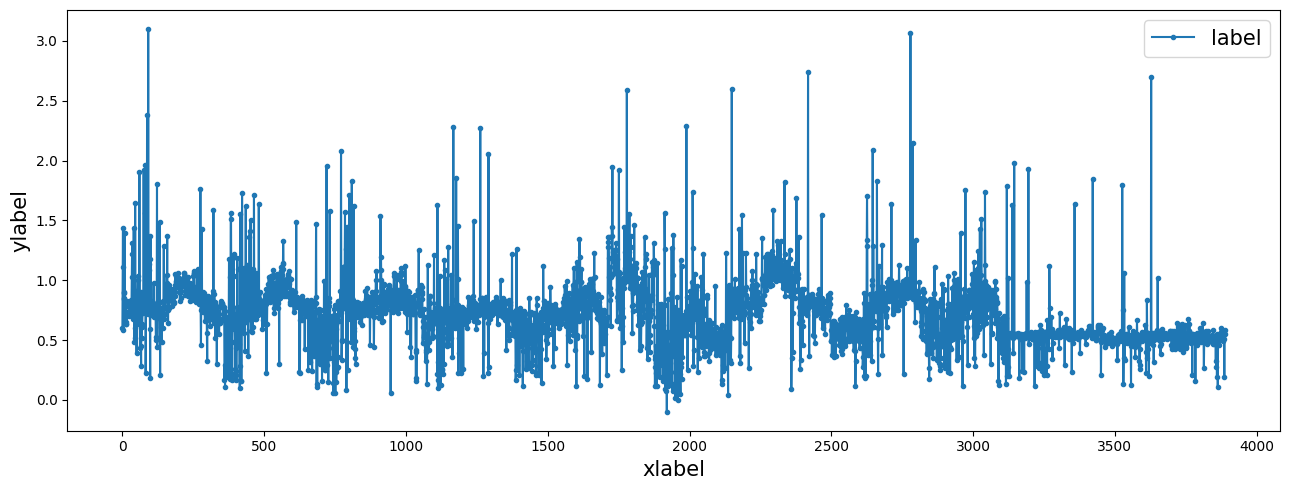

In [24]:
plot_1_data(df_aod["aod"])

In [25]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time, stations, pm25_3km

In [26]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=3889, freq=None)

In [27]:
# Get the station column
aod_station_column = df_aod.loc[:, "station"]
aod_station_column

time
2018-01-01    201
2018-01-02    201
2018-01-03    201
2018-01-04    201
2018-01-05    201
             ... 
2022-12-27    216
2022-12-28    216
2022-12-29    216
2022-12-30    216
2022-12-31    216
Name: station, Length: 3889, dtype: int64

In [28]:
# Get the pm25_3km column
aod_pm25_3km_column = df_aod.loc[:, "pm25_3km"]
aod_pm25_3km_column

time
2018-01-01    34.919998
2018-01-02    51.830002
2018-01-03    38.240002
2018-01-04    40.259998
2018-01-05    21.690001
                ...    
2022-12-27    34.439411
2022-12-28    29.838476
2022-12-29    28.450829
2022-12-30    19.854403
2022-12-31    27.658358
Name: pm25_3km, Length: 3889, dtype: float64

### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [29]:
# Features with pm25_3km
aod_feats = aod_stat_feats + aod_dyn_feats

# Predict without "station" as a feature
# Remove "pm25_3km" also
aod_feats.remove("station")
aod_feats.remove("pm25_3km")
X_aod = df_aod.loc[:, aod_feats]

# Label
y_aod = df_aod.loc[:, aod_label]

In [30]:
X_aod

lat         lon          pop  road_den_1km  \
time                                                           
2018-01-01  10.783057  106.700606  20680.62695     27.462461   
2018-01-02  10.783057  106.700606  20680.62695     27.462461   
2018-01-03  10.783057  106.700606  20680.62695     27.462461   
2018-01-04  10.783057  106.700606  20680.62695     27.462461   
2018-01-05  10.783057  106.700606  20680.62695     27.462461   
...               ...         ...          ...           ...   
2022-12-27  10.780482  106.659511  57523.91406     33.629780   
2022-12-28  10.780482  106.659511  57523.91406     33.629780   
2022-12-29  10.780482  106.659511  57523.91406     33.629780   
2022-12-30  10.780482  106.659511  57523.91406     33.629780   
2022-12-31  10.780482  106.659511  57523.91406     33.629780   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi        hpbl  \
time                                                                    
2018-01-01  1876.639945  232011.95950    0.0  2700.122924  455.131335   
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  339.083720   
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  367.190738   
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  462.504210   
2018-01-05  1876.639945  232011.95950    0.0  2700.122924  324.735356   
...                 ...           ...    ...          ...         ...   
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  457.798645   
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  644.974548   
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  825.517395   
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  680.533081   
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  799.122803   

                   rh       aod        tmp      wspd  
time                                                  
2018-01-01  70.056728  0.599173  25.204139  2.352895  
2018-01-02  73.425826  1.110117  24.726431  1.903761  
2018-01-03  77.793432  1.439045  26.095087  1.293329  
2018-01-04  82.982475  0.588595  26.514926  1.588872  
2018-01-05  93.046504  0.852506  25.483535  2.505876  
...               ...       ...        ...       ...  
2022-12-27  73.973083  0.508564  24.136936  2.002987  
2022-12-28  65.530487  0.547594  25.844296  2.298220  
2022-12-29  67.093735  0.191691  25.841156  2.823764  
2022-12-30  64.868401  0.554055  24.979719  3.893373  
2022-12-31  62.377899  0.580505  25.364861  4.161542  

[3889 rows x 18 columns]

In [31]:
y_aod

pm25
time                 
2018-01-01  31.391304
2018-01-02  37.458333
2018-01-03  68.083333
2018-01-04  51.260870
2018-01-05  18.909091
...               ...
2022-12-27  39.659816
2022-12-28  44.679352
2022-12-29  30.724708
2022-12-30  33.091428
2022-12-31  28.854069

[3889 rows x 1 columns]

### Data normalization

In [32]:
# Scaled features
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

lat       lon       pop  road_den_1km  prim_road_len_1km  \
0     0.326794  0.466551  0.116512      0.471552           0.949821   
1     0.326794  0.466551  0.116512      0.471552           0.949821   
2     0.326794  0.466551  0.116512      0.471552           0.949821   
3     0.326794  0.466551  0.116512      0.471552           0.949821   
4     0.326794  0.466551  0.116512      0.471552           0.949821   
...        ...       ...       ...           ...                ...   
3884  0.306899  0.237227  0.857395      0.785926           0.323578   
3885  0.306899  0.237227  0.857395      0.785926           0.323578   
3886  0.306899  0.237227  0.857395      0.785926           0.323578   
3887  0.306899  0.237227  0.857395      0.785926           0.323578   
3888  0.306899  0.237227  0.857395      0.785926           0.323578   

      near_dist  bareland   builtup  cropland  grassland  treecover  water  \
0      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
1      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
2      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
3      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
4      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
...         ...       ...       ...       ...        ...        ...    ...   
3884   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3885   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3886   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3887   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3888   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   

          ndvi      hpbl        rh       aod       tmp      wspd  
0     0.526821  0.300502  0.468797  0.217912  0.342735  0.170694  
1     0.526821  0.211553  0.543165  0.377783  0.303640  0.110646  
2     0.526821  0.233097  0.639575  0.480703  0.415649  0.029033  
3     0.526821  0.306153  0.754117  0.214603  0.450008  0.068546  
4     0.526821  0.200556  0.976269  0.297179  0.365600  0.191147  
...        ...       ...       ...       ...       ...       ...  
3884  0.085003  0.302546  0.555246  0.189562  0.255396  0.123912  
3885  0.085003  0.446013  0.368885  0.201774  0.395124  0.163384  
3886  0.085003  0.584396  0.403392  0.090414  0.394867  0.233647  
3887  0.085003  0.473268  0.354270  0.203795  0.324368  0.376650  
3888  0.085003  0.564165  0.299295  0.212071  0.355888  0.412504  

[3889 rows x 18 columns]

In [33]:
# Scaled label
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

pm25
0     0.325673
1     0.398696
2     0.767302
3     0.564825
4     0.175435
...        ...
3884  0.425193
3885  0.485609
3886  0.317649
3887  0.346136
3888  0.295134

[3889 rows x 1 columns]

In [34]:
# Dump the scaler for later use
joblib.dump(aod_features_scaler, os.path.join(conf["workspace"]["saved_data_scaler_dir"], "aod_feature_scaler.pkl"))
joblib.dump(aod_label_scaler, os.path.join(conf["workspace"]["saved_data_scaler_dir"], "aod_label_scaler.pkl"))

# Store the preprocessed data to directory
pd.concat((X_aod_scaled, y_aod_scaled), axis=1)\
    .set_index(aod_time_indices)\
    .to_csv(os.path.join(conf["workspace"]["data_to_store_in_hdfs_dir"], "vientham_2018_2022_before_dim_reduction.csv"))

## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25 as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [35]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction': [], 'n_future': []} | {m: [] for m in LSTMPrediction.get_supported_metrics()}
evaluation_board

{'dim_reduction_method': [],
 'dim_after_reduction': [],
 'prediction': [],
 'n_future': [],
 'mae': [],
 'mse': [],
 'rmse': [],
 'r2': [],
 'mape': [],
 'mnbe': [],
 'r_coeff': [],
 'p_value': []}

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from scipy.stats import pearsonr

# Calculate MNBE
def mean_normalized_bias_error(y_pred, y_actual):
    y_pred = np.array(y_pred)
    y_actual = np.array(y_actual)
    return np.mean((y_pred - y_actual) / np.mean(y_actual)) * 100

metrics_calculators = {
    "mae": mean_absolute_error,
    "mse": mean_squared_error,
    "rmse": root_mean_squared_error,
    "r2": r2_score,
    "mape": mean_absolute_percentage_error,
    "mnbe": mean_normalized_bias_error,
    "r_coeff": lambda a,b: pearsonr(a, b)[0]
}

### Model paramaters

In [37]:
range_of_dimension = range(conf["reduction_aod"]["min_number_of_features"], X_aod_scaled.shape[1])
#range_of_dimension = range(15, 16)
print(*range_of_dimension)

#range_of_n_future = range(1, 4)
range_of_n_future = [1]
print(*range_of_n_future)

reduction_n_past, reduction_n_future = conf["reduction_aod"]["n_past"], conf["reduction_aod"]["n_future"]
reduction_epochs, reduction_batch_size = conf["reduction_aod"]["epochs"], conf["reduction_aod"]["batch_size"]
print(reduction_n_past, reduction_n_future, reduction_epochs, reduction_batch_size)

prediction_n_past = conf["prediction_aod"]["n_past"]
prediction_epochs, prediction_batch_size = conf["prediction_aod"]["epochs"], conf["prediction_aod"]["batch_size"]
print(prediction_n_past, prediction_epochs, prediction_batch_size)

saved_model_plot_dir = conf["workspace"]["saved_model_plot_dir"]
saved_model_weight_dir = conf["workspace"]["saved_model_weight_dir"]
print(saved_model_plot_dir, saved_model_weight_dir)

10 11 12 13 14 15 16 17
1
7 7 200 128
7 200 128
/le_thanh_van_118/workspace/hiep_workspace/saved_model_plot /le_thanh_van_118/workspace/hiep_workspace/saved_model_weight


### Prediction without reduction (n_future = 1 to 3)

In [38]:
'''
# Loop every n_future
for prediction_n_future in range(1, 4):
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    lstmpred = LSTMPrediction(X_aod_scaled, y_aod_scaled,
                                aod_label_scaler,
                                val_percentage=0.2, test_percentage=0.2,
                                n_past=prediction_n_past, n_future=prediction_n_future,
                                epochs=prediction_epochs, batch_size=prediction_batch_size,
                                verbose=1,
                                model_name=f"aod_{LSTMPrediction.class_name}_{prediction_n_future}_future")
    lstmpred.dump(saved_model_plot_dir)
    all_days_inv_y_pred, all_days_inv_y_test, metrics, _ = lstmpred.execute(saved_model_weight_dir)
    
    # Visualize the prediction
    plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, prediction_n_future)
    
    # Print out the evaluation board
    evaluation_board['dim_reduction_method'] += ["None"]
    evaluation_board['dim_after_reduction'] += ["N/A"]
    evaluation_board['prediction'] += ["LSTM"]
    evaluation_board['n_future'] += [prediction_n_future]
    for m in LSTMPrediction.get_supported_metrics():
        evaluation_board[m] += [metrics[m][1]]

# Show evaluation board
pd.DataFrame(evaluation_board)
'''

'\n# Loop every n_future\nfor prediction_n_future in range(1, 4):\n    print("\n" + "=" * 100 + "\n")\n    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")\n    lstmpred = LSTMPrediction(X_aod_scaled, y_aod_scaled,\n                                aod_label_scaler,\n                                val_percentage=0.2, test_percentage=0.2,\n                                n_past=prediction_n_past, n_future=prediction_n_future,\n                                epochs=prediction_epochs, batch_size=prediction_batch_size,\n                                verbose=1,\n                                model_name=f"aod_{LSTMPrediction.class_name}_{prediction_n_future}_future")\n    lstmpred.dump(saved_model_plot_dir)\n    all_days_inv_y_pred, all_days_inv_y_test, metrics, _ = lstmpred.execute(saved_model_weight_dir)\n    \n    # Visualize the prediction\n    plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, prediction_n_future)\n    \n    # Print out the evaluation board\n    

### Prediction + LSTM-Seq2Seq (n_future = 1 to 3)

#### Doing the loop



PREDICTION WITH N_FUTURE = 1

LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.1931 - val_loss: 0.1358
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1558 - val_loss: 0.1239
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1124 - val_loss: 0.0906
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0747 - val_loss: 0.0837
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0647 - val_loss: 0.0806
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0543 - val_loss: 0.0721
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0718 - val_loss: 0.0877
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0627 - val_loss: 0.0891
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0532 - val_loss: 0.0794
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0532 - val_loss: 0.0770
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0653 - val_loss: 0.0767
Epoch 11: early stopping
Restoring model weights fro

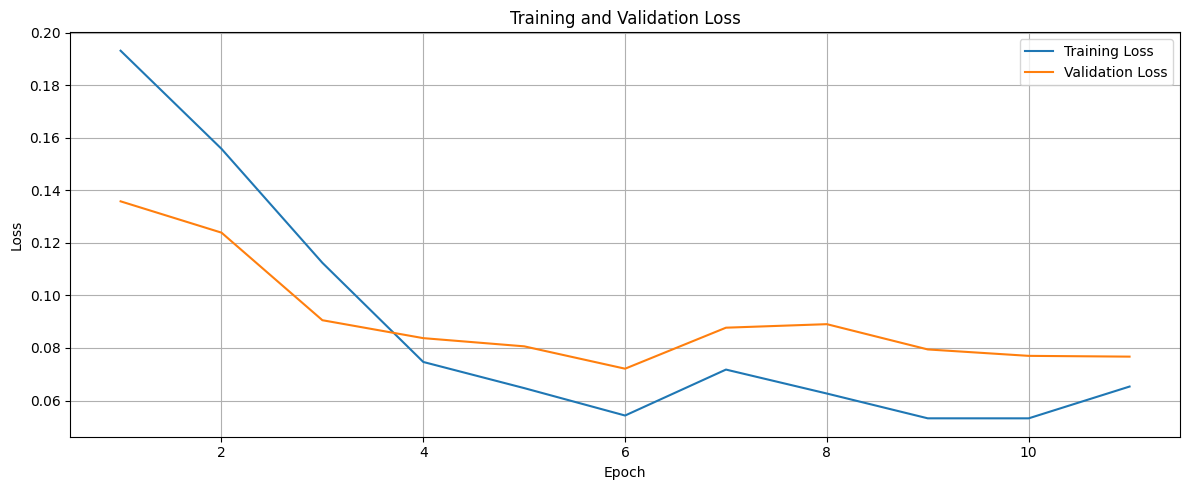

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0722
LSTMSeq2SeqReduction.execute(): mae = 0.07224028557538986
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_LSTMSeq2SeqReduction_1_future_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 100)    │     47,600 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50),      │     30,200 │ lstm[0][0]        │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │        510 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 7, 10)     │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 7, 50)     │     12,200 │ repeat_vector[0]… │
│                     │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 7, 18)     │      1,818 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 458,186 (1.75 MB)

 Trainable params: 152,728 (596.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 305,458 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_1_future_10_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,310 (305.90 KB)

 Trainable params: 78,310 (305.90 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_LSTMSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 64),      │     19,456 │ input_layer_2[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 1, 64)     │          0 │ lstm_4[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 1, 64)     │     33,024 │ repeat_vector_1[… │
│                     │                   │            │ lstm_4[0][1],     │
│                     │                   │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 64)     │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 1, 1)      │         65 │ dropout[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0408 - val_loss: 0.0258
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0236 - val_loss: 0.0207
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0200 - val_loss: 0.0200
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0183 - val_loss: 0.0194
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0173 - val_loss: 0.0170
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0164 - val_loss: 0.0158
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0152 - val_loss: 0.0146
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137 - val_loss: 0.0123
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127 - val_loss: 0.0115
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0131 - val_loss: 0.0110
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

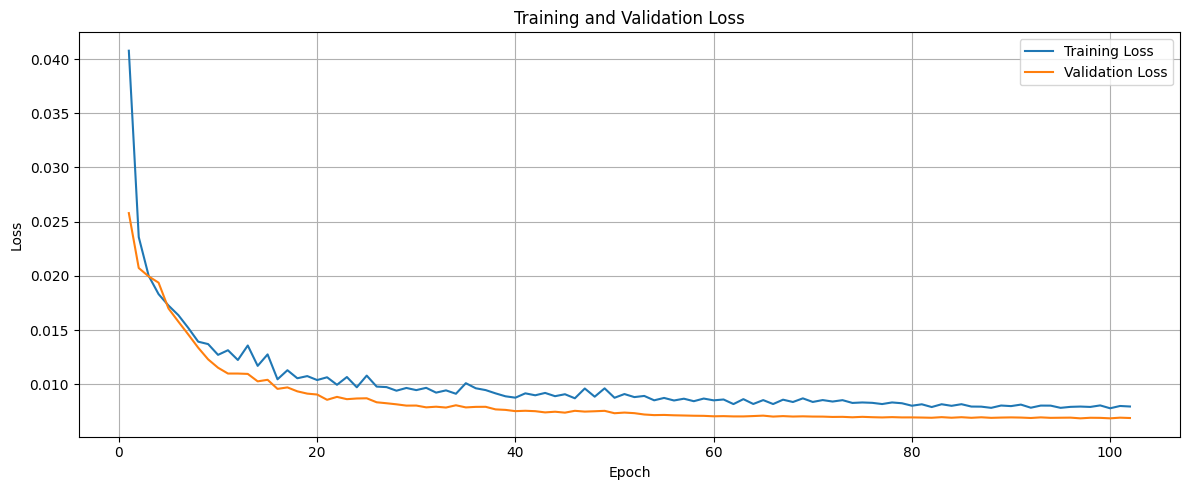

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.2666254817280915
	mse = 30.222569898720113
	rmse = 5.497505788875544
	r2 = -0.9130264441577818
	mape = 0.2328271580466616
	mnbe = 3.635919334379425
	r_coeff = 0.6253068981257259
	p_value = 2.018158625137138e-85
avg_mae = 4.2666254817280915
avg_mse = 30.222569898720113
avg_rmse = 5.497505788875544
avg_r2 = -0.9130264441577818
avg_mape = 0.2328271580466616
avg_mnbe = 3.635919334379425
avg_r_coeff = 0.6253068981257259
avg_p_value = 2.018158625137138e-85
LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.2031 - val_loss: 0.1111
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1076 - val_loss: 0.0960
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0780 - val_loss: 0.0867
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0681 - val_loss: 0.0849
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0582 - val_loss: 0.0845
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0534 - val_loss: 0.0745
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0997 - val_loss: 0.0908
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0638 - val_loss: 0.0884
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0603 - val_loss: 0.0838
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0547 - val_loss: 0.0810
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0501 - val_loss: 0.0777
Epoch 11: early stopping
Restoring model weights fro

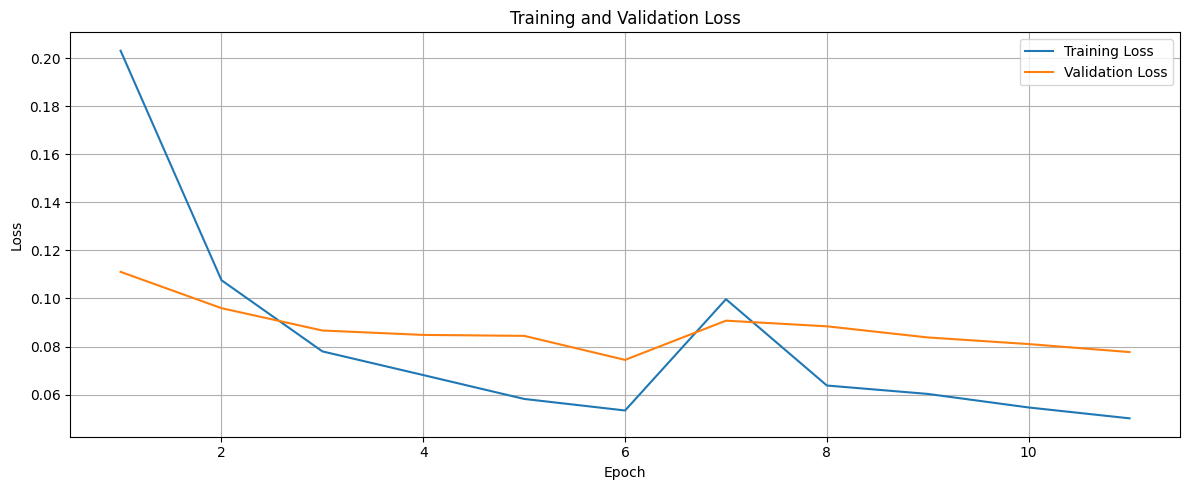

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0747
LSTMSeq2SeqReduction.execute(): mae = 0.07467460632324219
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_LSTMSeq2SeqReduction_1_future_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 7, 100)    │     47,600 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_6[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 11)        │        561 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 7, 11)     │          0 │ dense_3[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 7, 50)     │     12,400 │ repeat_vector_2[… │
│                     │                   │            │ lstm_7[0][1],     │
│                     │                   │            │ lstm_7[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 7, 18)     │      1,818 │ lstm_9[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 458,939 (1.75 MB)

 Trainable params: 152,979 (597.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 305,960 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_1_future_11_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,361 (306.10 KB)

 Trainable params: 78,361 (306.10 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_LSTMSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 64),      │     19,712 │ input_layer_5[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 1, 64)     │          0 │ lstm_10[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_3[… │
│                     │                   │            │ lstm_10[0][1],    │
│                     │                   │            │ lstm_10[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 64)     │          0 │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 1, 1)      │         65 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0386 - val_loss: 0.0165
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0202 - val_loss: 0.0166
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0179 - val_loss: 0.0133
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0160 - val_loss: 0.0122
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0149 - val_loss: 0.0110
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0136 - val_loss: 0.0097
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0122 - val_loss: 0.0086
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0113 - val_loss: 0.0094
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110 - val_loss: 0.0080
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0109 - val_loss: 0.0085
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - val_loss: 0.0079
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

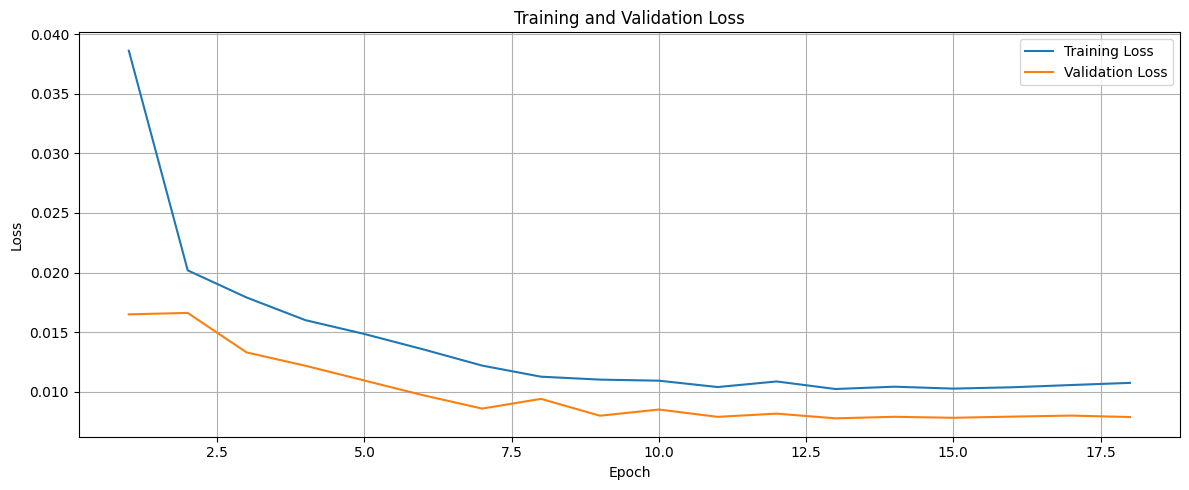

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.856370064518523
	mse = 35.63074700166867
	rmse = 5.969149604564176
	r2 = -2.2955466596452387
	mape = 0.25641552009891844
	mnbe = 6.985587618821743
	r_coeff = 0.5542649529509667
	p_value = 1.0601560478454219e-63
avg_mae = 4.856370064518523
avg_mse = 35.63074700166867
avg_rmse = 5.969149604564176
avg_r2 = -2.2955466596452387
avg_mape = 0.25641552009891844
avg_mnbe = 6.985587618821743
avg_r_coeff = 0.5542649529509667
avg_p_value = 1.0601560478454219e-63
LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.2000 - val_loss: 0.0983
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0979 - val_loss: 0.0969
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0734 - val_loss: 0.0868
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0636 - val_loss: 0.0847
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0565 - val_loss: 0.0790
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0479 - val_loss: 0.0821
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0601 - val_loss: 0.0744
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0382 - val_loss: 0.0638
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0687 - val_loss: 0.0822
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0583 - val_loss: 0.0707
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0488 - val_loss: 0.0682
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

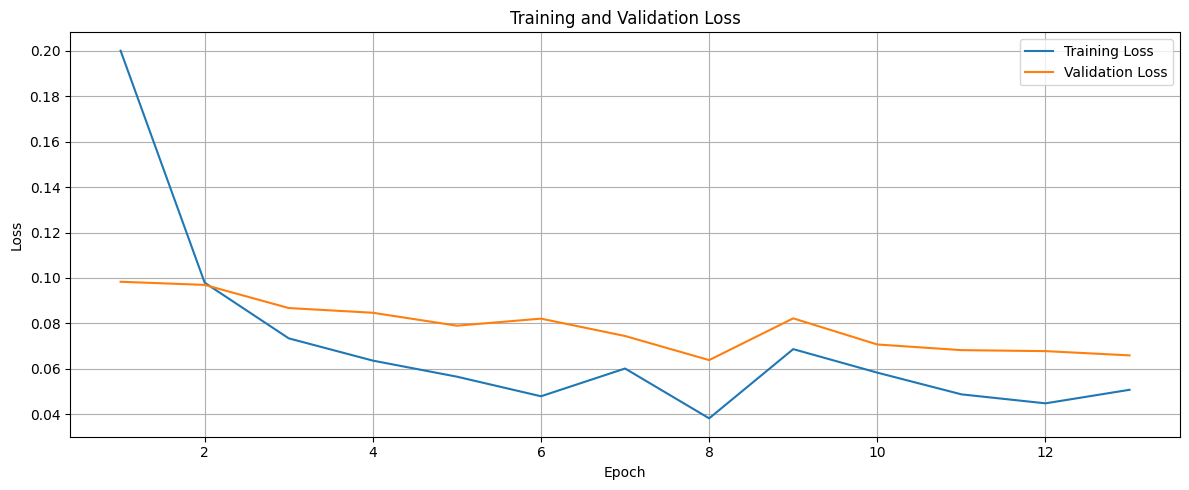

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0534
LSTMSeq2SeqReduction.execute(): mae = 0.053351905196905136
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_LSTMSeq2SeqReduction_1_future_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_12[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 12)        │        612 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 7, 12)     │          0 │ dense_6[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 7, 50)     │     12,600 │ repeat_vector_4[… │
│                     │                   │            │ lstm_13[0][1],    │
│                     │                   │            │ lstm_13[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 7, 18)     │      1,818 │ lstm_15[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 459,692 (1.75 MB)

 Trainable params: 153,230 (598.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,462 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_1_future_12_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,412 (306.30 KB)

 Trainable params: 78,412 (306.30 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_LSTMSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ [(None, 64),      │     19,968 │ input_layer_8[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 1, 64)     │          0 │ lstm_16[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_5[… │
│                     │                   │            │ lstm_16[0][1],    │
│                     │                   │            │ lstm_16[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 64)     │          0 │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 1, 1)      │         65 │ dropout_2[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1087 - val_loss: 0.0170
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0261 - val_loss: 0.0160
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0235 - val_loss: 0.0133
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0216 - val_loss: 0.0127
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0202 - val_loss: 0.0123
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0192 - val_loss: 0.0118
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0175 - val_loss: 0.0114
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0164 - val_loss: 0.0110
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0159 - val_loss: 0.0106
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0148 - val_loss: 0.0102
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0140 - val_loss: 0.0098
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

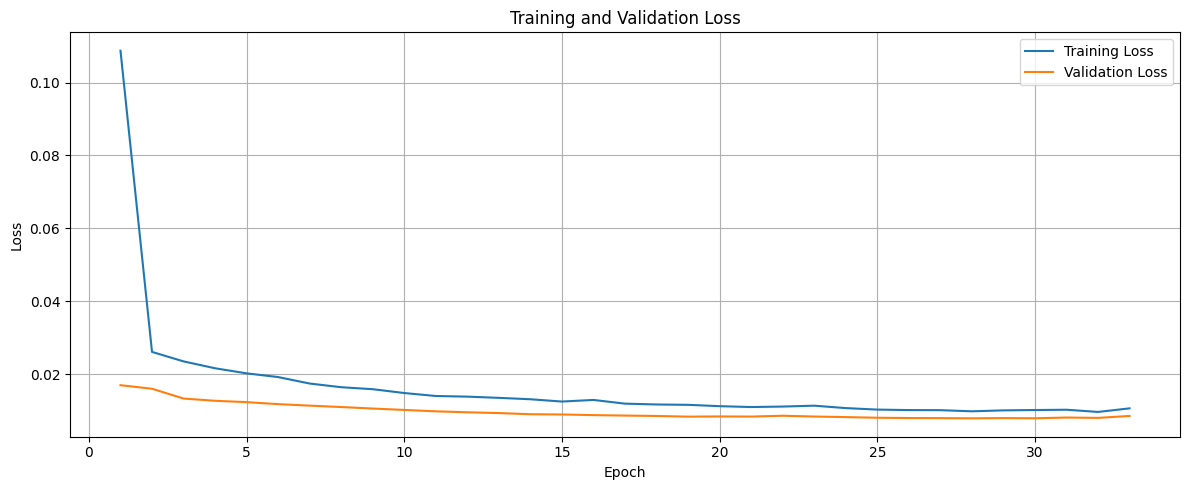

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.727545091647062
	mse = 34.63838631483335
	rmse = 5.885438498092844
	r2 = -2.564717639864209
	mape = 0.2525691050493388
	mnbe = 5.493796243824407
	r_coeff = 0.5685391765846977
	p_value = 1.2037121369871072e-67
avg_mae = 4.727545091647062
avg_mse = 34.63838631483335
avg_rmse = 5.885438498092844
avg_r2 = -2.564717639864209
avg_mape = 0.2525691050493388
avg_mnbe = 5.493796243824407
avg_r_coeff = 0.5685391765846977
avg_p_value = 1.2037121369871072e-67
LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.2357 - val_loss: 0.1239
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1281 - val_loss: 0.0966
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0902 - val_loss: 0.0933
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0716 - val_loss: 0.0843
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0629 - val_loss: 0.0815
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0554 - val_loss: 0.0776
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0527 - val_loss: 0.0840
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0530 - val_loss: 0.0715
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2208 - val_loss: 0.1091
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1012 - val_loss: 0.1055
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0932 - val_loss: 0.0790
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

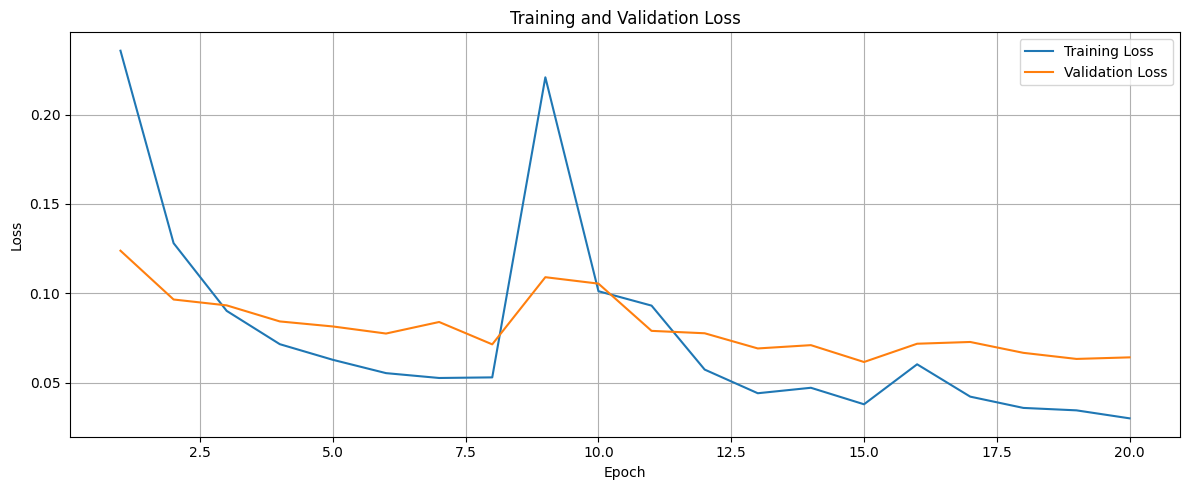

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0576
LSTMSeq2SeqReduction.execute(): mae = 0.05762440338730812
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_LSTMSeq2SeqReduction_1_future_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_18[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 13)        │        663 │ lstm_19[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 7, 13)     │          0 │ dense_9[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 7, 50)     │     12,800 │ repeat_vector_6[… │
│                     │                   │            │ lstm_19[0][1],    │
│                     │                   │            │ lstm_19[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_20[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 7, 18)     │      1,818 │ lstm_21[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 460,445 (1.76 MB)

 Trainable params: 153,481 (599.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,964 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_1_future_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,463 (306.50 KB)

 Trainable params: 78,463 (306.50 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_LSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_11[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 1, 64)     │          0 │ lstm_22[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_7[… │
│                     │                   │            │ lstm_22[0][1],    │
│                     │                   │            │ lstm_22[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1, 64)     │          0 │ lstm_23[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 1, 1)      │         65 │ dropout_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0644 - val_loss: 0.0213
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0309 - val_loss: 0.0169
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0236 - val_loss: 0.0151
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - val_loss: 0.0171
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0197 - val_loss: 0.0128
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0266 - val_loss: 0.0148
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0189 - val_loss: 0.0127
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0232 - val_loss: 0.0125
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0189 - val_loss: 0.0137
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0167 - val_loss: 0.0138
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0159 - val_loss: 0.0133
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

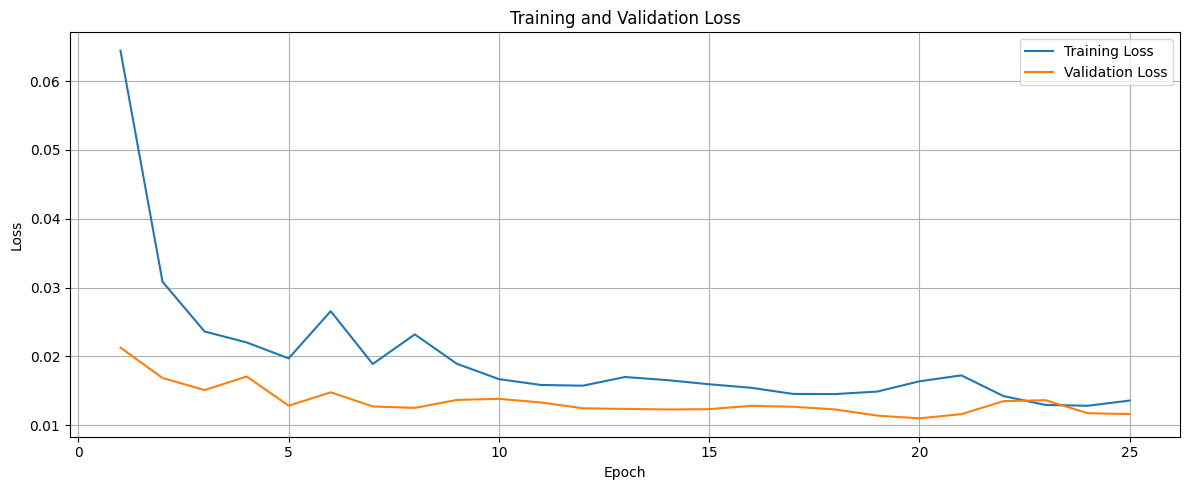

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 6.368380086880676
	mse = 53.89104748580163
	rmse = 7.341052205631127
	r2 = -31.062056621274003
	mape = 0.2991489174070392
	mnbe = 19.67530694344634
	r_coeff = 0.4930100392380306
	p_value = 9.117497796333163e-49
avg_mae = 6.368380086880676
avg_mse = 53.89104748580163
avg_rmse = 7.341052205631127
avg_r2 = -31.062056621274003
avg_mape = 0.2991489174070392
avg_mnbe = 19.67530694344634
avg_r_coeff = 0.4930100392380306
avg_p_value = 9.117497796333163e-49
LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.1788 - val_loss: 0.1159
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0890 - val_loss: 0.0916
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0676 - val_loss: 0.0894
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0638 - val_loss: 0.0821
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0544 - val_loss: 0.0742
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0494 - val_loss: 0.0850
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0470 - val_loss: 0.0684
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0429 - val_loss: 0.0917
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0443 - val_loss: 0.0807
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0432 - val_loss: 0.0649
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0269 - val_loss: 0.0642
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

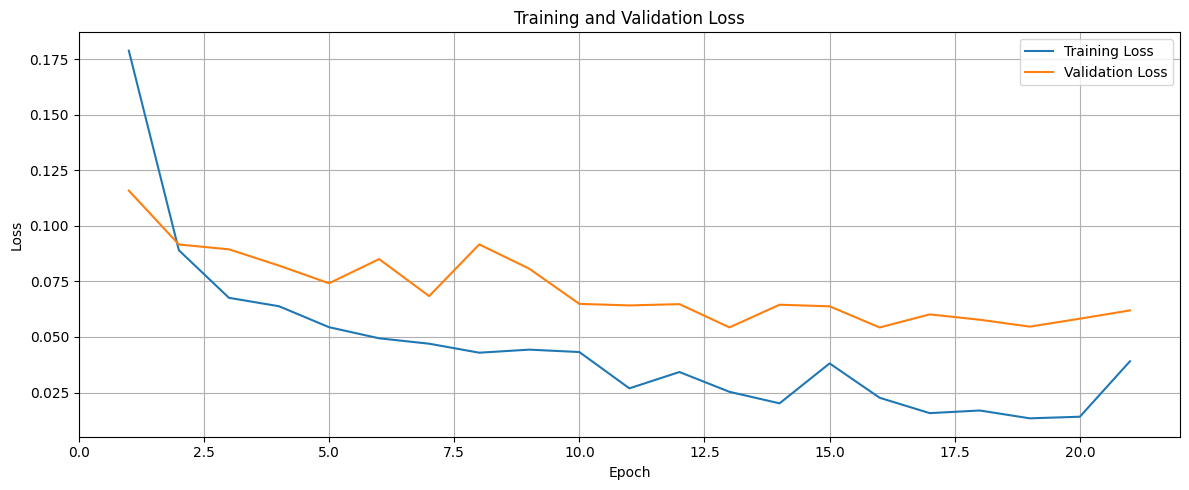

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0394
LSTMSeq2SeqReduction.execute(): mae = 0.03941129893064499
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_LSTMSeq2SeqReduction_1_future_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_24[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 14)        │        714 │ lstm_25[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 7, 14)     │          0 │ dense_12[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 7, 50)     │     13,000 │ repeat_vector_8[… │
│                     │                   │            │ lstm_25[0][1],    │
│                     │                   │            │ lstm_25[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_26[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 7, 18)     │      1,818 │ lstm_27[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,198 (1.76 MB)

 Trainable params: 153,732 (600.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,466 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_1_future_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,514 (306.70 KB)

 Trainable params: 78,514 (306.70 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_14[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_9     │ (None, 1, 64)     │          0 │ lstm_28[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_9[… │
│                     │                   │            │ lstm_28[0][1],    │
│                     │                   │            │ lstm_28[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1, 64)     │          0 │ lstm_29[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 1, 1)      │         65 │ dropout_4[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0288 - val_loss: 0.0237
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0201 - val_loss: 0.0191
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0212 - val_loss: 0.0201
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0200 - val_loss: 0.0177
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0167 - val_loss: 0.0175
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165 - val_loss: 0.0173
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165 - val_loss: 0.0169
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165 - val_loss: 0.0165
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0156 - val_loss: 0.0158
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

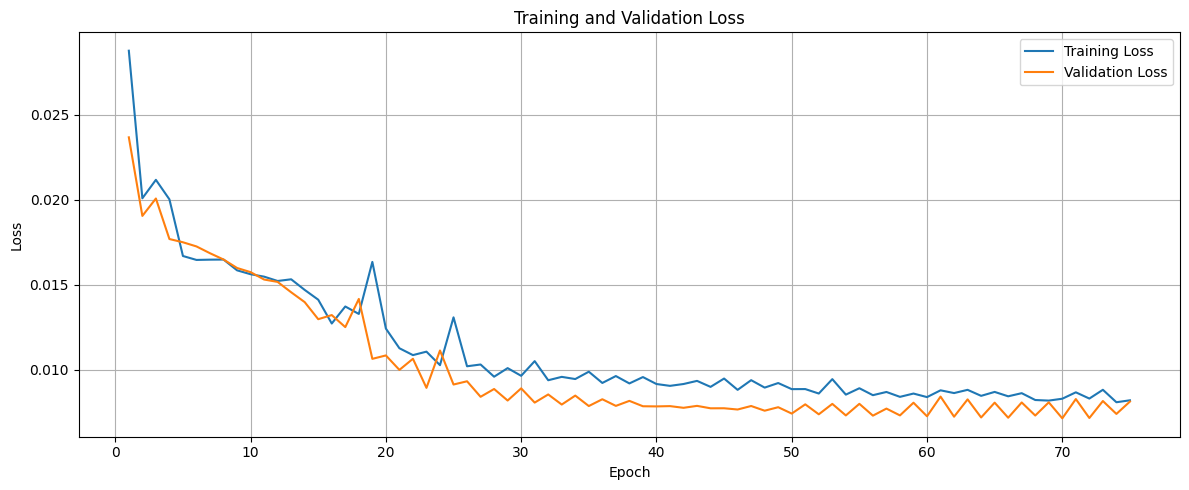

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.646324032799917
	mse = 33.44898548473587
	rmse = 5.783509789456215
	r2 = -1.812302649984415
	mape = 0.24568391926607172
	mnbe = 7.008498494217384
	r_coeff = 0.5964848017815659
	p_value = 5.934384243789544e-76
avg_mae = 4.646324032799917
avg_mse = 33.44898548473587
avg_rmse = 5.783509789456215
avg_r2 = -1.812302649984415
avg_mape = 0.24568391926607172
avg_mnbe = 7.008498494217384
avg_r_coeff = 0.5964848017815659
avg_p_value = 5.934384243789544e-76
LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.2018 - val_loss: 0.1117
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1051 - val_loss: 0.0980
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0849 - val_loss: 0.0869
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0686 - val_loss: 0.0842
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0619 - val_loss: 0.0828
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0558 - val_loss: 0.0799
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0488 - val_loss: 0.0790
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0516 - val_loss: 0.0658
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0495 - val_loss: 0.0614
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0645 - val_loss: 0.0825
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0569 - val_loss: 0.0822
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

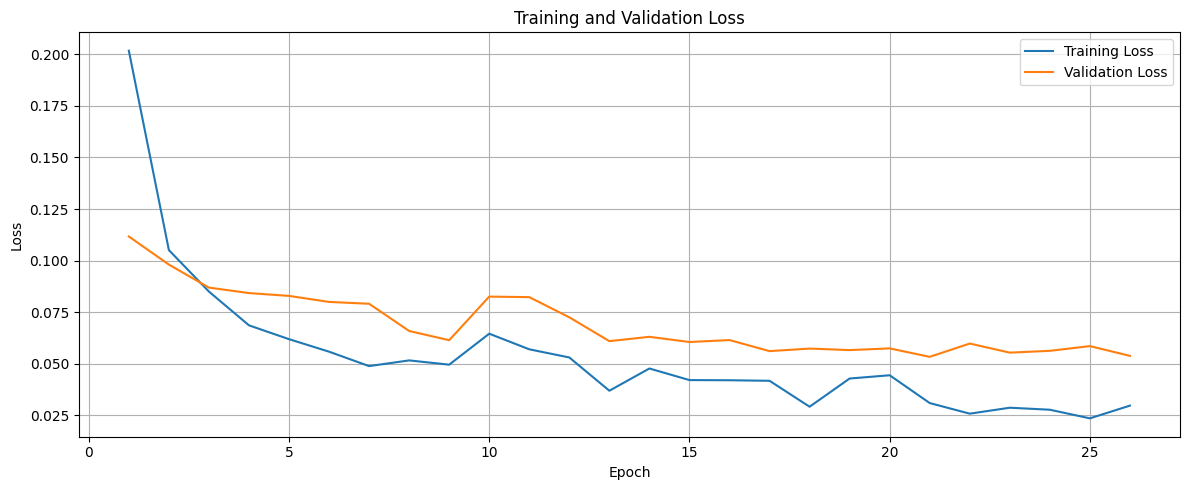

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0444
LSTMSeq2SeqReduction.execute(): mae = 0.044408999383449554
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_LSTMSeq2SeqReduction_1_future_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_30[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 15)        │        765 │ lstm_31[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_10    │ (None, 7, 15)     │          0 │ dense_15[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_10… │
│                     │                   │            │ lstm_31[0][1],    │
│                     │                   │            │ lstm_31[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_32[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 7, 18)     │      1,818 │ lstm_33[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,951 (1.76 MB)

 Trainable params: 153,983 (601.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,968 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_1_future_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,565 (306.89 KB)

 Trainable params: 78,565 (306.89 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_34 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_17[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_11    │ (None, 1, 64)     │          0 │ lstm_34[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_11… │
│                     │                   │            │ lstm_34[0][1],    │
│                     │                   │            │ lstm_34[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 64)     │          0 │ lstm_35[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, 1, 1)      │         65 │ dropout_5[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0795 - val_loss: 0.0346
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0296 - val_loss: 0.0164
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0217 - val_loss: 0.0157
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0196 - val_loss: 0.0151
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0191 - val_loss: 0.0150
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0186 - val_loss: 0.0151
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0192 - val_loss: 0.0138
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0162 - val_loss: 0.0136
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157 - val_loss: 0.0131
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0156 - val_loss: 0.0129
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0159 - val_loss: 0.0124
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

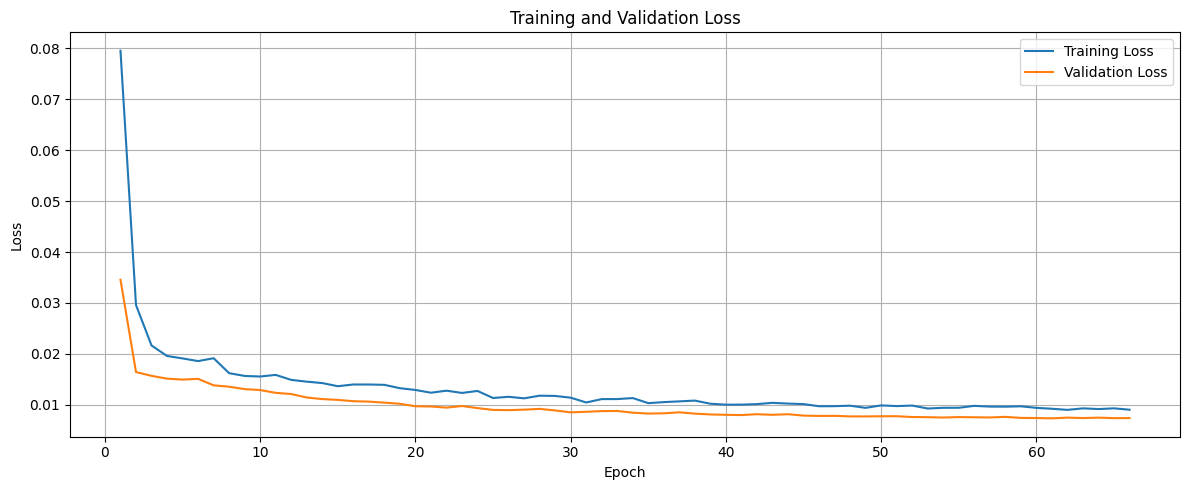

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.489900118161225
	mse = 32.35032228599447
	rmse = 5.687734371961693
	r2 = -1.8064247297413685
	mape = 0.24366921925485088
	mnbe = 3.9394862659417473
	r_coeff = 0.5985433311423718
	p_value = 1.3454036441981657e-76
avg_mae = 4.489900118161225
avg_mse = 32.35032228599447
avg_rmse = 5.687734371961693
avg_r2 = -1.8064247297413685
avg_mape = 0.24366921925485088
avg_mnbe = 3.9394862659417473
avg_r_coeff = 0.5985433311423718
avg_p_value = 1.3454036441981657e-76
LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.2007 - val_loss: 0.1121
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0982 - val_loss: 0.0901
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0693 - val_loss: 0.0874
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0630 - val_loss: 0.0808
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0545 - val_loss: 0.0742
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0516 - val_loss: 0.0790
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0466 - val_loss: 0.0626
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0427 - val_loss: 0.0651
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0361 - val_loss: 0.0614
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0597 - val_loss: 0.0615
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0470 - val_loss: 0.0642
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

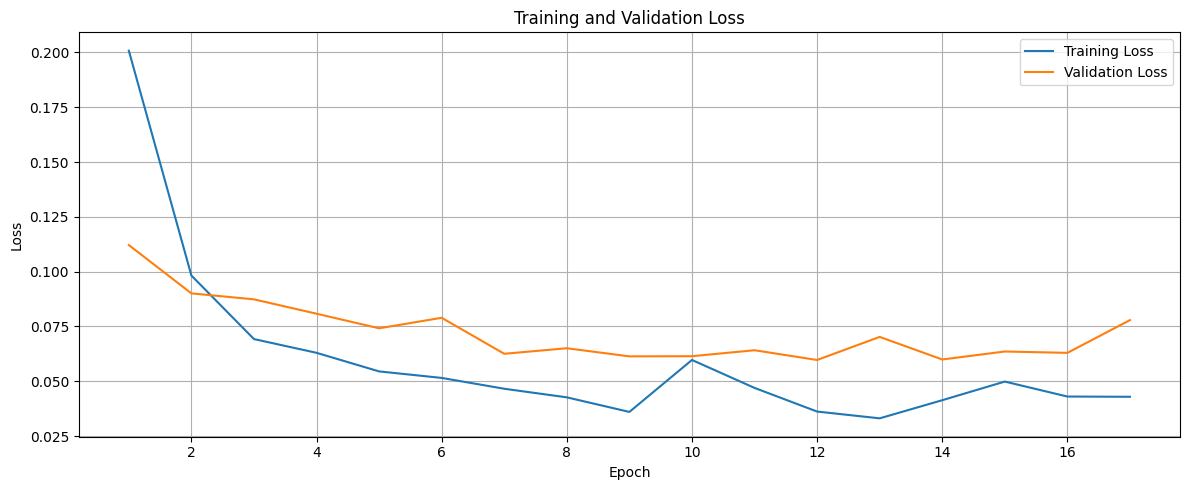

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0468
LSTMSeq2SeqReduction.execute(): mae = 0.0468197837471962
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_LSTMSeq2SeqReduction_1_future_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_36[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 16)        │        816 │ lstm_37[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_12    │ (None, 7, 16)     │          0 │ dense_18[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_12… │
│                     │                   │            │ lstm_37[0][1],    │
│                     │                   │            │ lstm_37[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_38[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 7, 18)     │      1,818 │ lstm_39[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 462,704 (1.77 MB)

 Trainable params: 154,234 (602.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,470 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_1_future_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,616 (307.09 KB)

 Trainable params: 78,616 (307.09 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_LSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_40 (LSTM)      │ [(None, 64),      │     20,992 │ input_layer_20[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_13    │ (None, 1, 64)     │          0 │ lstm_40[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_13… │
│                     │                   │            │ lstm_40[0][1],    │
│                     │                   │            │ lstm_40[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 1, 64)     │          0 │ lstm_41[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, 1, 1)      │         65 │ dropout_6[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,081 (211.25 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0410 - val_loss: 0.0204
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0257 - val_loss: 0.0204
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0242 - val_loss: 0.0186
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0208 - val_loss: 0.0170
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0193 - val_loss: 0.0161
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0171 - val_loss: 0.0160
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0159 - val_loss: 0.0151
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0160 - val_loss: 0.0152
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0159 - val_loss: 0.0143
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0146 - val_loss: 0.0142
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0150 - val_loss: 0.0138
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

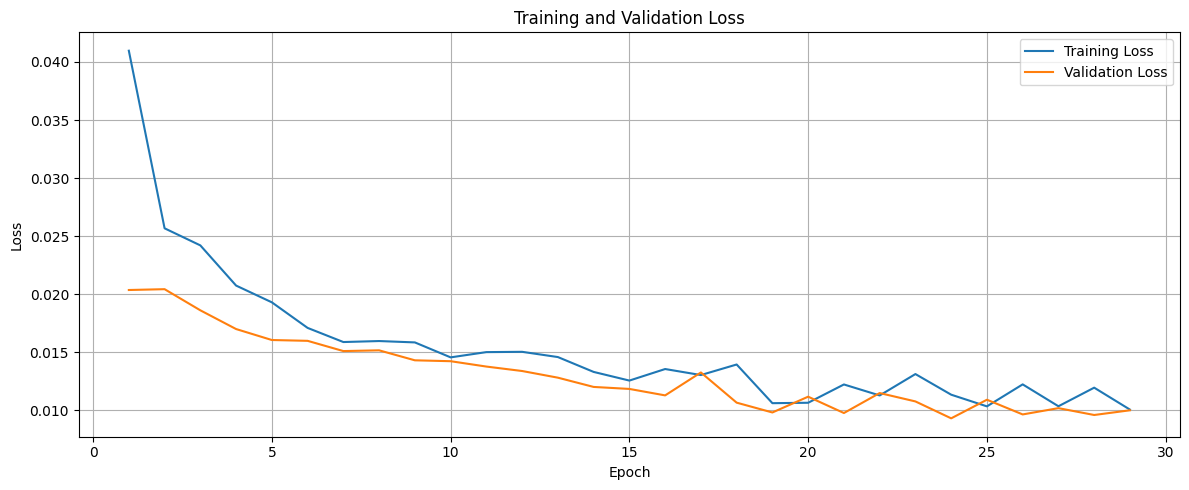

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 5.153453629627067
	mse = 39.8048020736965
	rmse = 6.309104696682129
	r2 = -4.962706760242379
	mape = 0.2653505713536545
	mnbe = 8.661043893959716
	r_coeff = 0.4982645116881742
	p_value = 6.234377324841192e-50
avg_mae = 5.153453629627067
avg_mse = 39.8048020736965
avg_rmse = 6.309104696682129
avg_r2 = -4.962706760242379
avg_mape = 0.2653505713536545
avg_mnbe = 8.661043893959716
avg_r_coeff = 0.4982645116881742
avg_p_value = 6.234377324841192e-50
LSTMSeq2SeqReduction._prepare_data(): is called
LSTMSeq2SeqReduction._define_model(): is called
LSTMSeq2SeqReduction.execute(): is called
LSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.2111 - val_loss: 0.1121
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0969 - val_loss: 0.0950
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0741 - val_loss: 0.0908
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0658 - val_loss: 0.0790
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0524 - val_loss: 0.0677
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1037 - val_loss: 0.1046
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0726 - val_loss: 0.0960
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0640 - val_loss: 0.0770
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0477 - val_loss: 0.0724
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0659 - val_loss: 0.0778
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


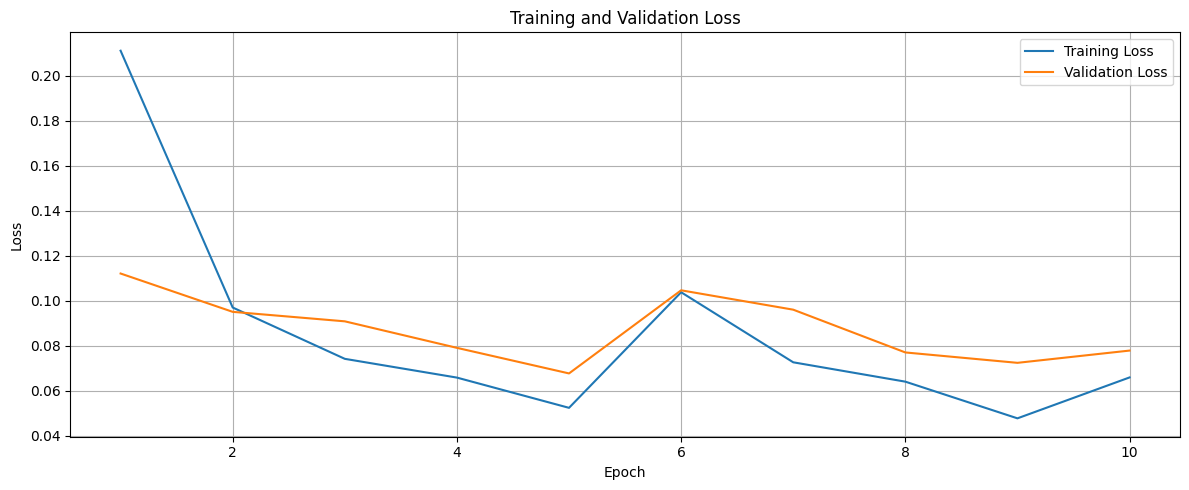

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0539
LSTMSeq2SeqReduction.execute(): mae = 0.053881485015153885
LSTMSeq2SeqReduction._define_encoder_model(): is called
LSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_LSTMSeq2SeqReduction_1_future_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_43 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_42[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 17)        │        867 │ lstm_43[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_14    │ (None, 7, 17)     │          0 │ dense_21[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_44 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_14… │
│                     │                   │            │ lstm_43[0][1],    │
│                     │                   │            │ lstm_43[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_45 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_44[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 7, 18)     │      1,818 │ lstm_45[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,457 (1.77 MB)

 Trainable params: 154,485 (603.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,972 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_1_future_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,667 (307.29 KB)

 Trainable params: 78,667 (307.29 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_LSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_46 (LSTM)      │ [(None, 64),      │     21,248 │ input_layer_23[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_15    │ (None, 1, 64)     │          0 │ lstm_46[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_47 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_15… │
│                     │                   │            │ lstm_46[0][1],    │
│                     │                   │            │ lstm_46[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1, 64)     │          0 │ lstm_47[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 1, 1)      │         65 │ dropout_7[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,337 (212.25 KB)

 Trainable params: 54,337 (212.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0322 - val_loss: 0.0238
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0230 - val_loss: 0.0178
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0220 - val_loss: 0.0157
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0196 - val_loss: 0.0177
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0198 - val_loss: 0.0146
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0167 - val_loss: 0.0144
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0159 - val_loss: 0.0140
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0152 - val_loss: 0.0130
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0146 - val_loss: 0.0123
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0141 - val_loss: 0.0119
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0140 - val_loss: 0.0113
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

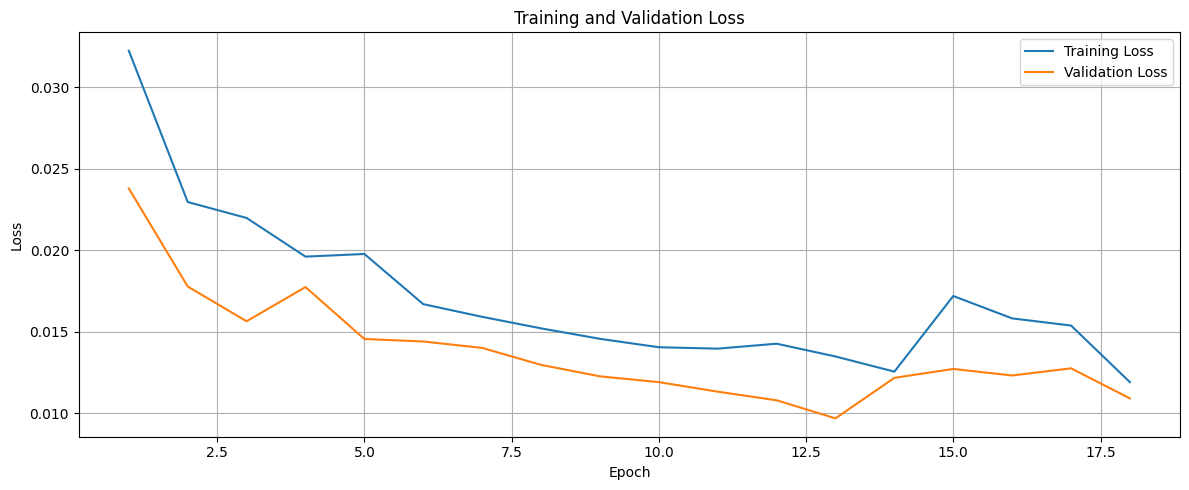

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 5.420634661488769
	mse = 41.16152809515938
	rmse = 6.4157250638691945
	r2 = -8.051091201890019
	mape = 0.2738296109236039
	mnbe = 11.543438301861041
	r_coeff = 0.5495140595101453
	p_value = 1.97912548342705e-62
avg_mae = 5.420634661488769
avg_mse = 41.16152809515938
avg_rmse = 6.4157250638691945
avg_r2 = -8.051091201890019
avg_mape = 0.2738296109236039
avg_mnbe = 11.543438301861041
avg_r_coeff = 0.5495140595101453
avg_p_value = 1.97912548342705e-62
Choosing the best result

dict_keys([10, 11, 12, 13, 14, 15, 16, 17])
N = 10
mae = 4.2666254817280915
mse = 30.222569898720113
rmse = 5.497505788875544
r2 = -0.9130264441577818
mape = 0.2328271580466616
mnbe = 3.635919334379425
r_coeff = 0.6253068981257259
p_val

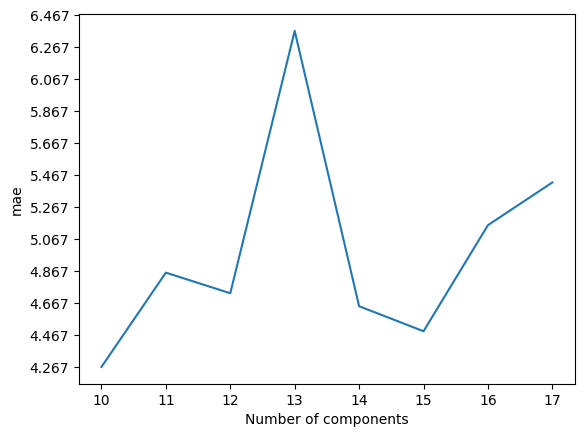

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


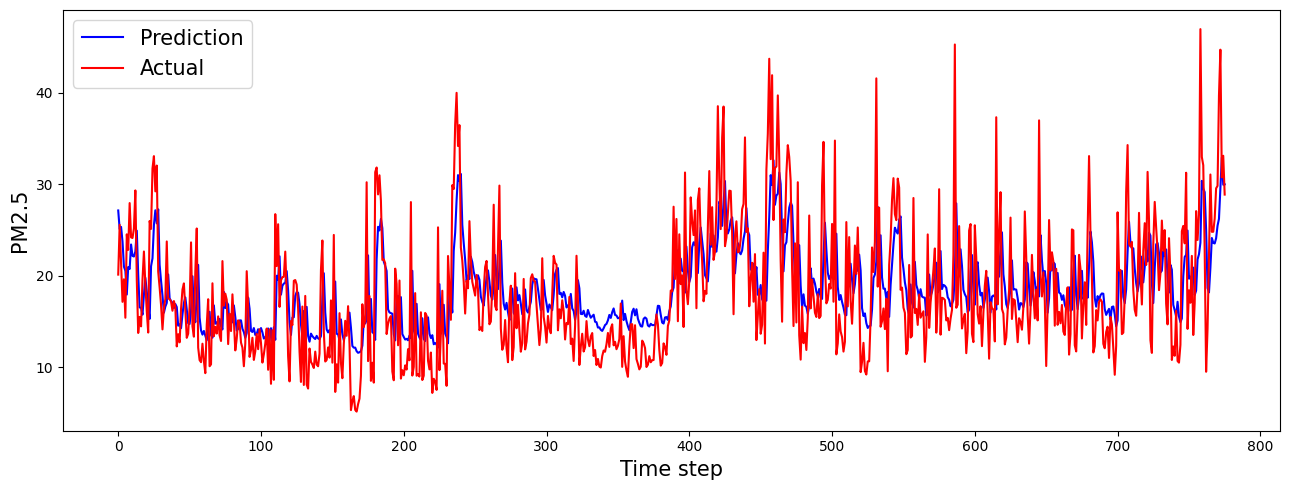

dim_reduction_method  dim_after_reduction prediction  n_future       mae  \
0         LSTM-Seq2Seq                   10       LSTM         1  4.266625   

        mse      rmse        r2      mape      mnbe   r_coeff       p_value  
0  30.22257  5.497506 -0.913026  0.232827  3.635919  0.625307  2.018159e-85

In [39]:
# Loop every n_future
lstms2s_n_future_mapper = {}

for prediction_n_future in range_of_n_future:
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    loopresults = generate_loopresults(X_aod_scaled, y_aod_scaled,
                                       aod_label_scaler,
                                       range_of_dimension,
                                       LSTMSeq2SeqReduction,
                                       LSTMPrediction,
                                       "aod", "aod",
                                       reduction_n_past, reduction_n_future,
                                       reduction_epochs, reduction_batch_size,
                                       prediction_n_past, prediction_n_future,
                                       prediction_epochs, prediction_batch_size,
                                       saved_model_weight_dir, saved_model_plot_dir)
    best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path = choose_the_best(loopresults, "mae", prediction_n_future)
    
    # Update the evaluation board
    evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
    evaluation_board['dim_after_reduction'] += [best_num_of_components]
    evaluation_board['n_future'] += [prediction_n_future]
    evaluation_board['prediction'] += ["LSTM"]
    for metric, value in best_metrics.items():
        evaluation_board[metric] += [value]
    display(pd.DataFrame(evaluation_board))

    # Update n_future mapper
    lstms2s_n_future_mapper[prediction_n_future] = (best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path)

#### Prepare reduced data

In [40]:
# Create the mapper for inference data
lstms2s_n_future_inference_mapper = {}

# Loop over n_future mapper
for prediction_n_future, (best_encoded_data, _, best_encoder_model_path, best_prediction_model_path) in lstms2s_n_future_mapper.items():
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    
    # Copy the best reduction model to target directory
    shutil.copy(best_encoder_model_path, conf["workspace"]["best_model_weight_dir"])
    shutil.copy(best_prediction_model_path, conf["workspace"]["best_model_weight_dir"])
    
    # Inference LSTM
    pred_pm25_from_df_lstms2s_reduced = inferenceLSTM(best_encoded_data, y_aod_scaled,
                                                        prediction_n_past, prediction_n_future,
                                                        best_prediction_model_path, verbose=1)
    inv_pred_pm25_from_df_lstms2s_reduced = aod_label_scaler.inverse_transform(np.squeeze(pred_pm25_from_df_lstms2s_reduced, axis=-1))
    print(inv_pred_pm25_from_df_lstms2s_reduced.shape)
    
    # Prepare the reduced data
    df_lstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices,
                                            (aod_station_column, "station"),
                                            *[(inv_pred_pm25_from_df_lstms2s_reduced[:, day], f"predicted_pm25_day_{day+1}") for day in range(inv_pred_pm25_from_df_lstms2s_reduced.shape[-1])],
                                            (aod_pm25_3km_column, "pm25_3km"))
    df_lstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data_dir"], f"df_lstms2s_reduced_2018_2022_{prediction_n_future}_day.csv"))
    df_lstms2s_reduced.to_csv(os.path.join(conf["workspace"]["data_to_store_in_hdfs_dir"], f"vientham_2018_2022_reduced_with_lstms2s_{prediction_n_future}_day.csv"))
    display(df_lstms2s_reduced)

    # Update the n_future inference mapper
    lstms2s_n_future_inference_mapper[prediction_n_future] = df_lstms2s_reduced



PREDICTION WITH N_FUTURE = 1

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(3889, 1)


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.489796      -0.177419      -0.765973      -0.598416   
2018-01-02       0.489796      -0.177419      -0.765973      -0.598416   
2018-01-03       0.489962      -0.176321      -0.766717      -0.598846   
2018-01-04       0.493727      -0.174859      -0.770975      -0.601781   
2018-01-05       0.500468      -0.174837      -0.779143      -0.607914   
...                   ...            ...            ...            ...   
2022-12-27       0.153421       0.190665      -0.625220       0.049071   
2022-12-28       0.154886       0.189853      -0.620505       0.047570   
2022-12-29       0.153389       0.188149      -0.607169       0.051123   
2022-12-30       0.155749       0.185176      -0.599093       0.050896   
2022-12-31       0.155102       0.186135      -0.601394       0.052386   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.757174       0.947610      -0.314270      -0.554964   
2018-01-02       0.757174       0.947610      -0.314270      -0.554964   
2018-01-03       0.757432       0.947243      -0.315298      -0.555919   
2018-01-04       0.761680       0.948708      -0.317895      -0.559793   
2018-01-05       0.768141       0.954858      -0.320292      -0.567112   
...                   ...            ...            ...            ...   
2022-12-27       0.146593       0.084710      -0.177837      -0.460472   
2022-12-28       0.148155       0.087118      -0.177559      -0.457876   
2022-12-29       0.147694       0.085139      -0.173705      -0.450706   
2022-12-30       0.149940       0.088328      -0.168847      -0.446143   
2022-12-31       0.148197       0.086988      -0.166869      -0.447430   

            aod_feature_9  aod_feature_10  station  predicted_pm25_day_1  \
time                                                                       
2018-01-01      -0.821853       -1.055227      201             27.902506   
2018-01-02      -0.821853       -1.055227      201             27.902506   
2018-01-03      -0.821016       -1.054394      201             31.087383   
2018-01-04      -0.823254       -1.057459      201             44.500076   
2018-01-05      -0.830260       -1.065643      201             43.217327   
...                   ...             ...      ...                   ...   
2022-12-27      -0.718445       -0.931378      216             26.200703   
2022-12-28      -0.714801       -0.926239      216             29.569895   
2022-12-29      -0.706728       -0.916770      216             32.898983   
2022-12-30      -0.705536       -0.914518      216             29.928232   
2022-12-31      -0.711049       -0.919959      216             29.970425   

             pm25_3km  
time                   
2018-01-01  34.919998  
2018-01-02  51.830002  
2018-01-03  38.240002  
2018-01-04  40.259998  
2018-01-05  21.690001  
...               ...  
2022-12-27  34.439411  
2022-12-28  29.838476  
2022-12-29  28.450829  
2022-12-30  19.854403  
2022-12-31  27.658358  

[3889 rows x 13 columns]

#### Compare MAE with pm25_3km



PREDICTION WITH N_FUTURE = 1

(776, 1)
(776, 1)


Day 1:

current_day_inv_y_pred.shape =  (776,)
test_len =  776
On test data:
Metrics between actual and pm25_3km
mae: 6.785086281801943
mse: 87.2793385941348
rmse: 9.34234117307513
r2: -0.7928541596397412
mape: 0.41985536540161267
mnbe: -6.396618152257187
r_coeff: 0.30791322778668884
Metrics between actual and predicted
mae: 4.2666254817280915
mse: 30.222569898720113
rmse: 5.497505788875544
r2: 0.37918113231939166
mape: 0.26776085277756156
mnbe: -3.508358159315392
r_coeff: 0.6253068981257259


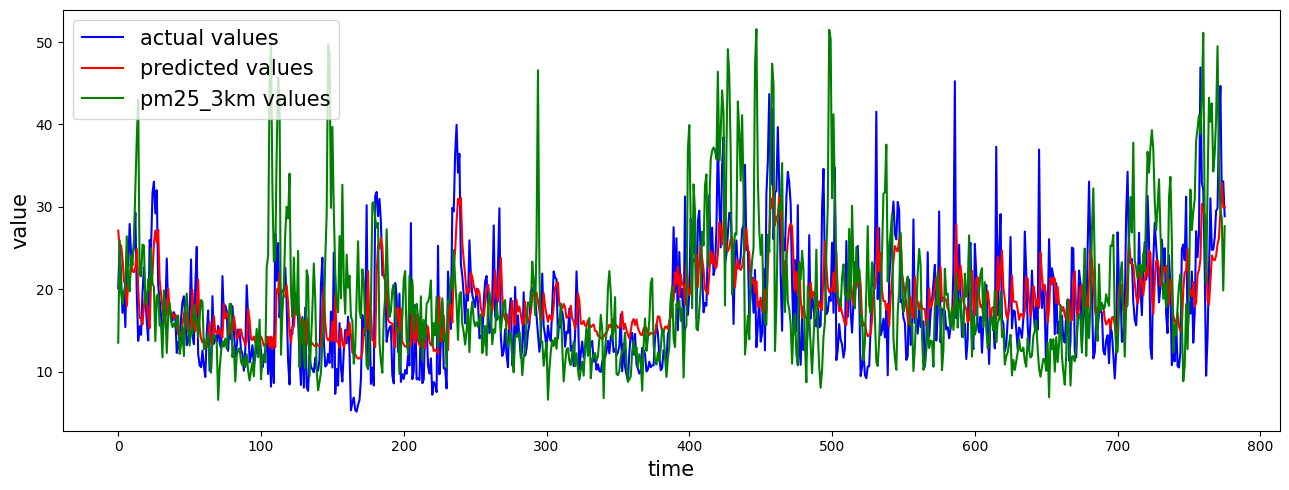

On entire data:
mae: 7.875957292759844
mse: 113.65471755090876
rmse: 10.660896657922764
r2: -0.07128729764249964
mape: 0.34821379393500074
mnbe: 14.79075075838297
r_coeff: 0.4754473311691296
Metrics between actual and predicted
mae: 5.261115660177888
mse: 52.986521828531025
rmse: 7.279184145804462
r2: 0.5005593344091819
mape: 0.239181765506954
mnbe: 5.895961388068391
r_coeff: 0.7204624985153267


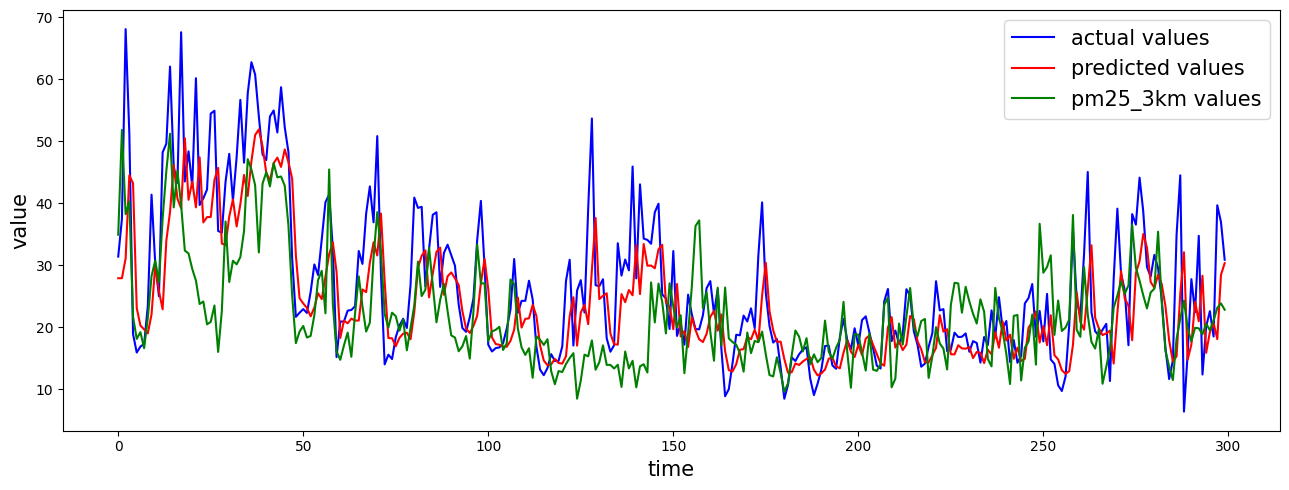

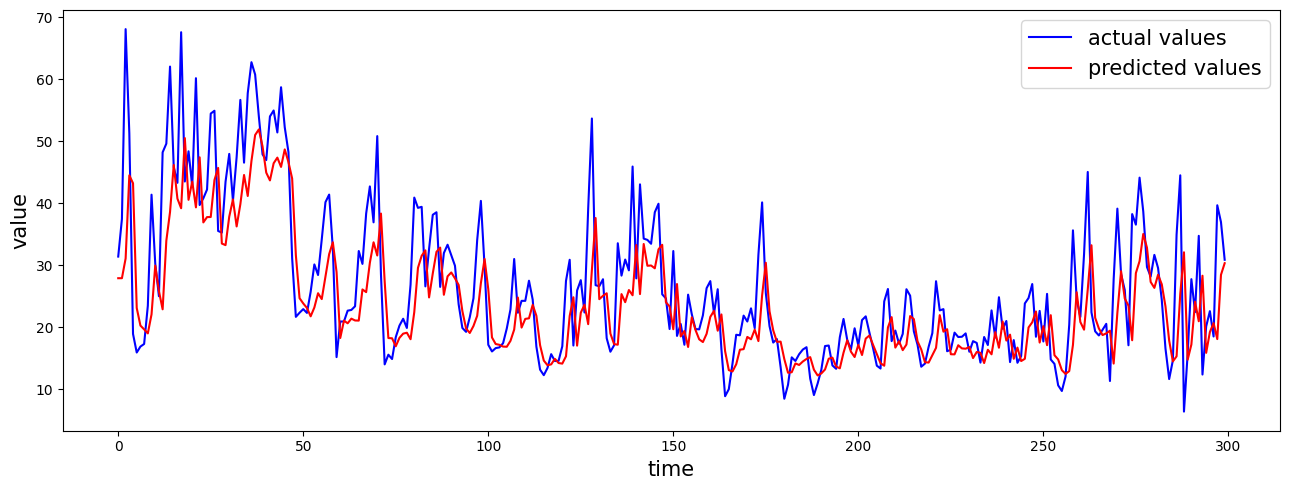

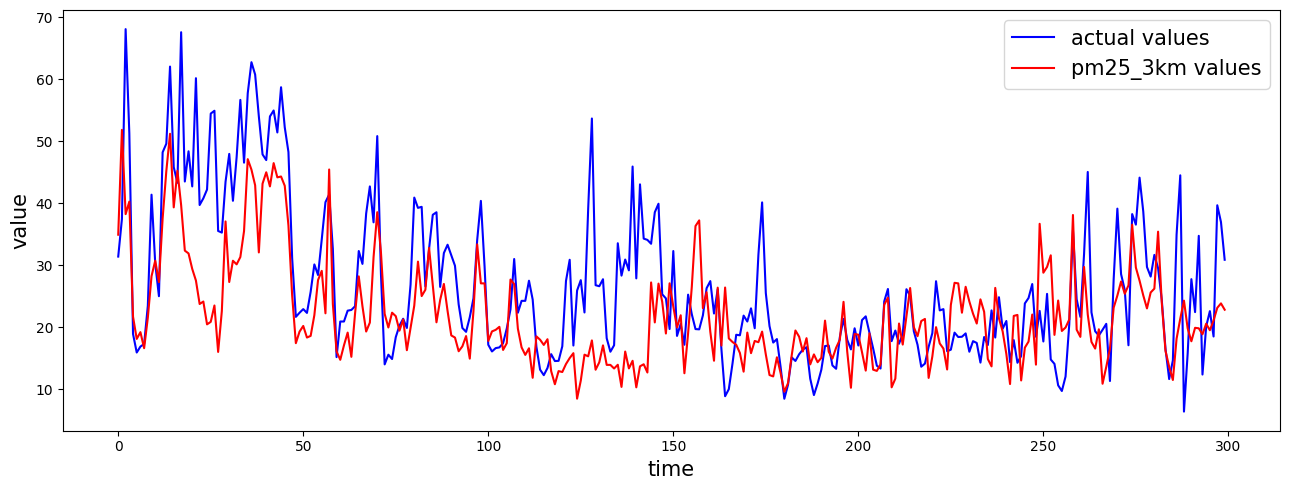

In [41]:
for prediction_n_future, (best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path) in lstms2s_n_future_mapper.items():
    
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    
    # Compare test set only
    all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
    df_lstms2s_reduced = lstms2s_n_future_inference_mapper[prediction_n_future]

    print(all_days_inv_y_pred.shape)
    print(all_days_inv_y_test.shape)
    
    for day in range(prediction_n_future):
        
        print("\n" + "=" * 50 + "\n")
        print(f"Day {day+1}:\n")
        
        current_day_inv_y_pred = all_days_inv_y_pred[:, day]
        current_day_inv_y_test = all_days_inv_y_test[:, day]
        print("current_day_inv_y_pred.shape = ", current_day_inv_y_pred.shape)
        
        test_len = current_day_inv_y_test.shape[0]
        print("test_len = ", test_len)
        
        aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
        
        # Compare test dataset
        print("On test data:")
        print("Metrics between actual and pm25_3km")
        for metric, calculator in metrics_calculators.items():
           print(f"{metric}: {calculator(current_day_inv_y_test, aod_pm25_3km_column_test)}")
        print("Metrics between actual and predicted")
        for metric, calculator in metrics_calculators.items():
           print(f"{metric}: {calculator(current_day_inv_y_test, current_day_inv_y_pred)}")
        plot_3_data(data1=current_day_inv_y_test,
                   datalabel1="actual values",
                   data2=current_day_inv_y_pred,
                   datalabel2="predicted values",
                   data3=aod_pm25_3km_column_test,
                   datalabel3="pm25_3km values",
                   ylabel="value",
                   xlabel="time")
        
        # Compare entire dataset
        print("On entire data:")
        current_day_inv_pred_pm25_from_df_lstms2s_reduced = df_lstms2s_reduced.loc[:, f"predicted_pm25_day_{day+1}"]
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(y_aod.iloc[:, 0], aod_pm25_3km_column)}")
        print("Metrics between actual and predicted")
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(y_aod.iloc[:, 0], current_day_inv_pred_pm25_from_df_lstms2s_reduced)}")
        plot_3_data(data1=y_aod.head(300),
                   datalabel1="actual values",
                   data2=current_day_inv_pred_pm25_from_df_lstms2s_reduced[:300],
                   datalabel2="predicted values",
                   data3=aod_pm25_3km_column.head(300),
                   datalabel3="pm25_3km values",
                   ylabel="value",
                   xlabel="time")
        plot_2_data(data1=y_aod.head(300),
                   datalabel1="actual values",
                   data2=current_day_inv_pred_pm25_from_df_lstms2s_reduced[:300],
                   datalabel2="predicted values",
                   ylabel="value",
                   xlabel="time")
        plot_2_data(data1=y_aod.head(300),
                   datalabel1="actual values",
                   data2=aod_pm25_3km_column.head(300),
                   datalabel2="pm25_3km values",
                   ylabel="value",
                   xlabel="time")

#### Compare MAE with CMAQ pm25

On entire data:
Metrics between actual and cmaq
mae: 8.394844716269084
mse: 131.531765285845
rmse: 11.468729889828472
r2: -0.5079937316171277
mape: 0.4083535368071802
mnbe: 5.784401798824349
r_coeff: 0.257722298418209
Metrics between actual and predicted
mae: 5.526255384494347
mse: 53.44074809715255
rmse: 7.310317920388453
r2: 0.38730911906868004
mape: 0.2748874396325038
mnbe: 3.458669434600702
r_coeff: 0.6275863648834483


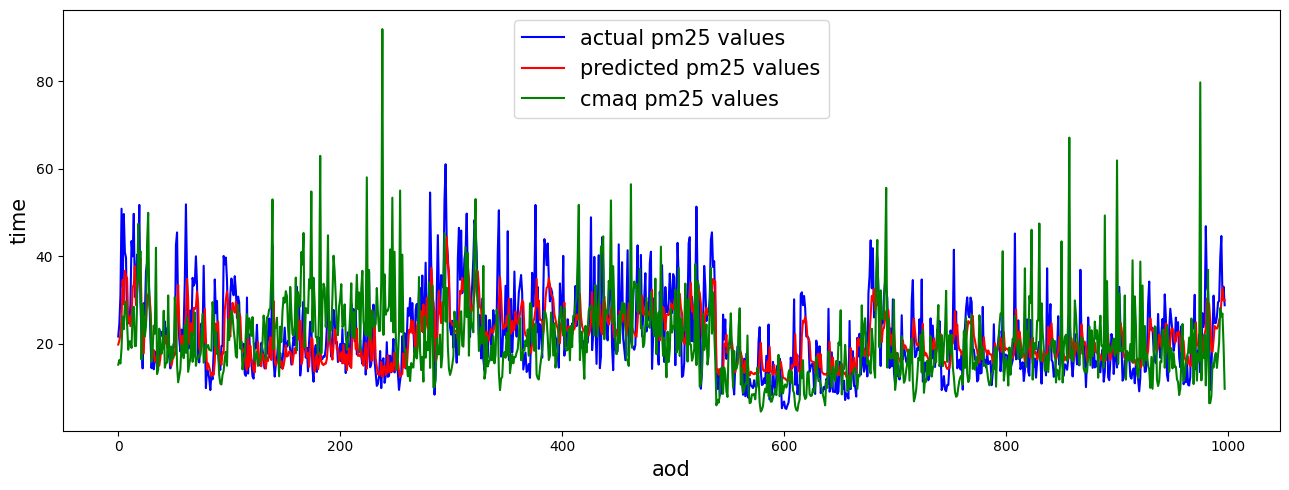

In [42]:
# Remove station 202 for original data
# Only get data in 2022 for AOD
df_aod_dropped_202 = df_aod[df_aod["station"] != 202]
df_aod_dropped_202 = df_aod_dropped_202.loc[((df_aod_dropped_202.index >= "2022-01-01") & (df_aod_dropped_202.index <= "2022-12-31"))]

# After removing 2018-2021 data in AOD, some stations are missing
# so we have so adapt the CMAQ data to fit with AOD data
all_cmaq_data = []
for station in df_aod_dropped_202["station"].unique():
    df_aod_current_station = df_aod_dropped_202[df_aod_dropped_202["station"] == station]
    df_cmaq_current_station = df_cmaq_daily[df_cmaq_daily["station"] == station]
    all_cmaq_data.append(df_cmaq_current_station.loc[df_aod_current_station.index])
df_cmaq_dropped = pd.concat(all_cmaq_data, axis=0)

# Loop over n_future
for prediction_n_future, df_lstms2s_reduced in lstms2s_n_future_inference_mapper.items():
    df_lstms2s_reduced_dropped_202 = df_lstms2s_reduced[df_lstms2s_reduced["station"] != 202]
    time_mask = ((df_lstms2s_reduced_dropped_202.index >= "2022-01-01") & (df_lstms2s_reduced_dropped_202.index <= "2022-12-31"))
    df_lstms2s_reduced_dropped_202 = df_lstms2s_reduced_dropped_202.loc[time_mask]
    
    for day in range(prediction_n_future):
        actual = df_aod_dropped_202["pm25"]
        pred = df_lstms2s_reduced_dropped_202.loc[:, f"predicted_pm25_day_{day+1}"]
        cmaq = df_cmaq_dropped["pm25"]
        
        # Compare entire dataset
        print("On entire data:")
        print("Metrics between actual and cmaq")
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(actual, cmaq)}")
        print("Metrics between actual and predicted")
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(actual, pred)}")
        
        # Compare entire dataset
        plot_3_data(data1=actual,
                   datalabel1="actual pm25 values",
                   data2=pred,
                   datalabel2="predicted pm25 values",
                   data3=cmaq,
                   datalabel3="cmaq pm25 values",
                   ylabel="time",
                   xlabel="aod")

### Prediction + GRU-Seq2Seq (n_future = 1 to 3)

#### Doing the loop



PREDICTION WITH N_FUTURE = 1

GRUSeq2SeqReduction._prepare_data(): is called
GRUSeq2SeqReduction._define_model(): is called
GRUSeq2SeqReduction.execute(): is called
GRUSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.1925 - val_loss: 0.0851
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0868 - val_loss: 0.0868
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0646 - val_loss: 0.0832
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0608 - val_loss: 0.0823
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0565 - val_loss: 0.0785
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0481 - val_loss: 0.0675
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0414 - val_loss: 0.0844
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0481 - val_loss: 0.0657
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0390 - val_loss: 0.0598
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0311 - val_loss: 0.0557
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0272 - val_loss: 0.0541
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

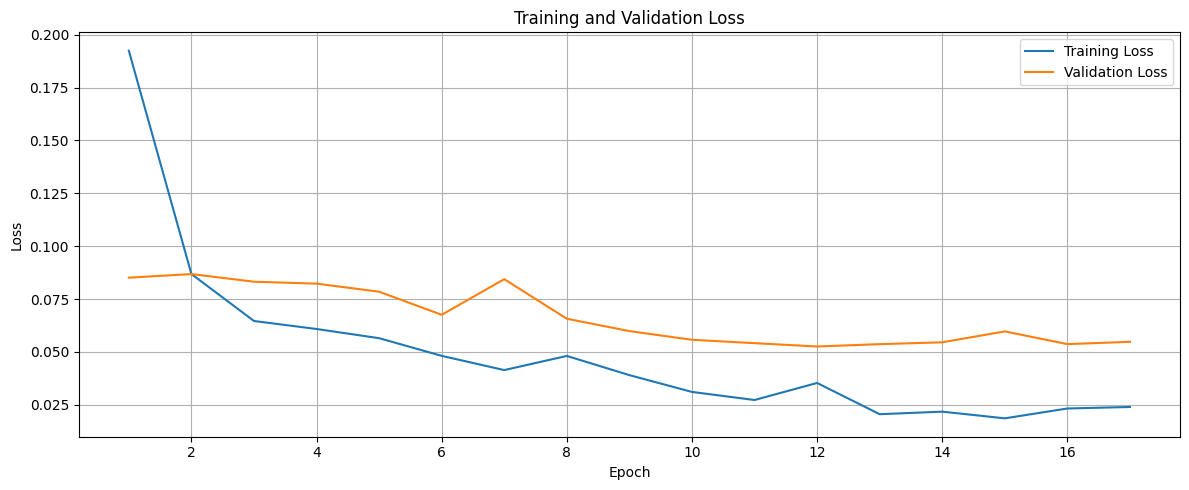

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0434
GRUSeq2SeqReduction.execute(): mae = 0.043377555906772614
GRUSeq2SeqReduction._define_encoder_model(): is called
GRUSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_GRUSeq2SeqReduction_1_future_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 7, 100)    │     36,000 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 50),      │     22,800 │ gru[0][0]         │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 10)        │        510 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_16    │ (None, 7, 10)     │          0 │ dense_24[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 7, 50)     │      9,300 │ repeat_vector_16… │
│                     │                   │            │ gru_1[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_16 │ (None, 7, 18)     │      1,818 │ gru_3[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 348,086 (1.33 MB)

 Trainable params: 116,028 (453.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,058 (906.48 KB)

None


Model: "aod_GRUSeq2SeqReduction_1_future_10_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,310 (231.68 KB)

 Trainable params: 59,310 (231.68 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_GRUSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_48 (LSTM)      │ [(None, 64),      │     19,456 │ input_layer_26[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_17    │ (None, 1, 64)     │          0 │ lstm_48[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_49 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_17… │
│                     │                   │            │ lstm_48[0][1],    │
│                     │                   │            │ lstm_48[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 1, 64)     │          0 │ lstm_49[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, 1, 1)      │         65 │ dropout_8[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0435 - val_loss: 0.0120
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0159 - val_loss: 0.0110
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138 - val_loss: 0.0101
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0123 - val_loss: 0.0094
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0112 - val_loss: 0.0088
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0107 - val_loss: 0.0084
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0103 - val_loss: 0.0081
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105 - val_loss: 0.0081
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0104 - val_loss: 0.0080
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099 - val_loss: 0.0079
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0100 - val_loss: 0.0079
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

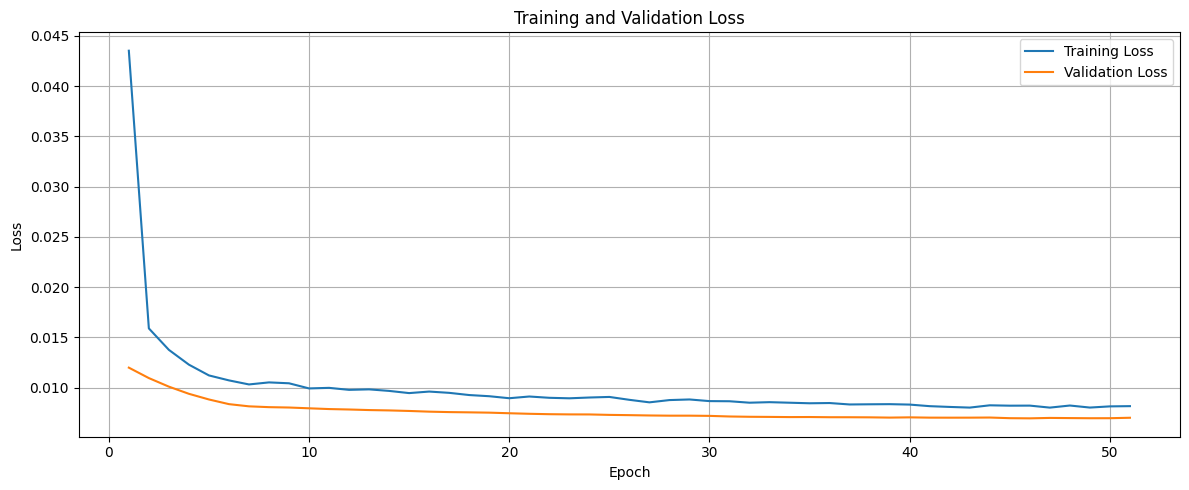

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.577415122800859
	mse = 32.215581603111175
	rmse = 5.675877165963969
	r2 = -1.1292139396754606
	mape = 0.24038674184724343
	mnbe = 8.203581611154643
	r_coeff = 0.6219733415153095
	p_value = 2.8240403166780165e-84
avg_mae = 4.577415122800859
avg_mse = 32.215581603111175
avg_rmse = 5.675877165963969
avg_r2 = -1.1292139396754606
avg_mape = 0.24038674184724343
avg_mnbe = 8.203581611154643
avg_r_coeff = 0.6219733415153095
avg_p_value = 2.8240403166780165e-84
GRUSeq2SeqReduction._prepare_data(): is called
GRUSeq2SeqReduction._define_model(): is called
GRUSeq2SeqReduction.execute(): is called
GRUSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.1935 - val_loss: 0.0908
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0777 - val_loss: 0.0874
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0658 - val_loss: 0.0804
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0606 - val_loss: 0.0794
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0557 - val_loss: 0.0739
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0459 - val_loss: 0.0601
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0363 - val_loss: 0.0676
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0359 - val_loss: 0.0530
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0347 - val_loss: 0.0621
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0460 - val_loss: 0.0599
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0276 - val_loss: 0.0525
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

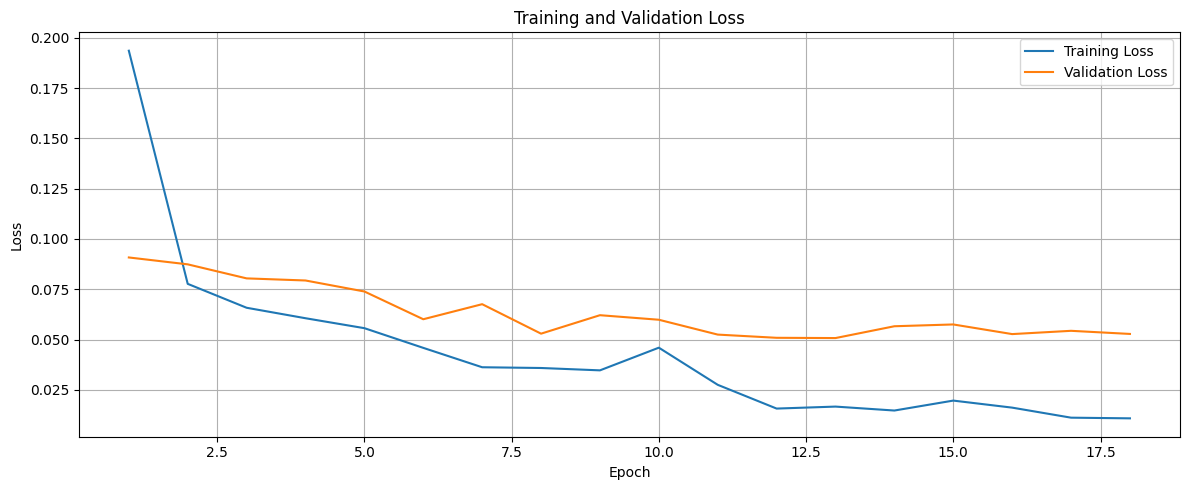

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0401
GRUSeq2SeqReduction.execute(): mae = 0.040114276111125946
GRUSeq2SeqReduction._define_encoder_model(): is called
GRUSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_GRUSeq2SeqReduction_1_future_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 7, 100)    │     36,000 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 50),      │     22,800 │ gru_4[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 11)        │        561 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_18    │ (None, 7, 11)     │          0 │ dense_27[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 7, 50)     │      9,450 │ repeat_vector_18… │
│                     │                   │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, 7, 18)     │      1,818 │ gru_7[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 348,689 (1.33 MB)

 Trainable params: 116,229 (454.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,460 (908.05 KB)

None


Model: "aod_GRUSeq2SeqReduction_1_future_11_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,361 (231.88 KB)

 Trainable params: 59,361 (231.88 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_GRUSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_50 (LSTM)      │ [(None, 64),      │     19,712 │ input_layer_29[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_19    │ (None, 1, 64)     │          0 │ lstm_50[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_51 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_19… │
│                     │                   │            │ lstm_50[0][1],    │
│                     │                   │            │ lstm_50[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 1, 64)     │          0 │ lstm_51[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, 1, 1)      │         65 │ dropout_9[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0342 - val_loss: 0.0116
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0142 - val_loss: 0.0099
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0124 - val_loss: 0.0099
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0107 - val_loss: 0.0084
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - val_loss: 0.0080
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - val_loss: 0.0078
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0098 - val_loss: 0.0077
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0094 - val_loss: 0.0074
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0095 - val_loss: 0.0074
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

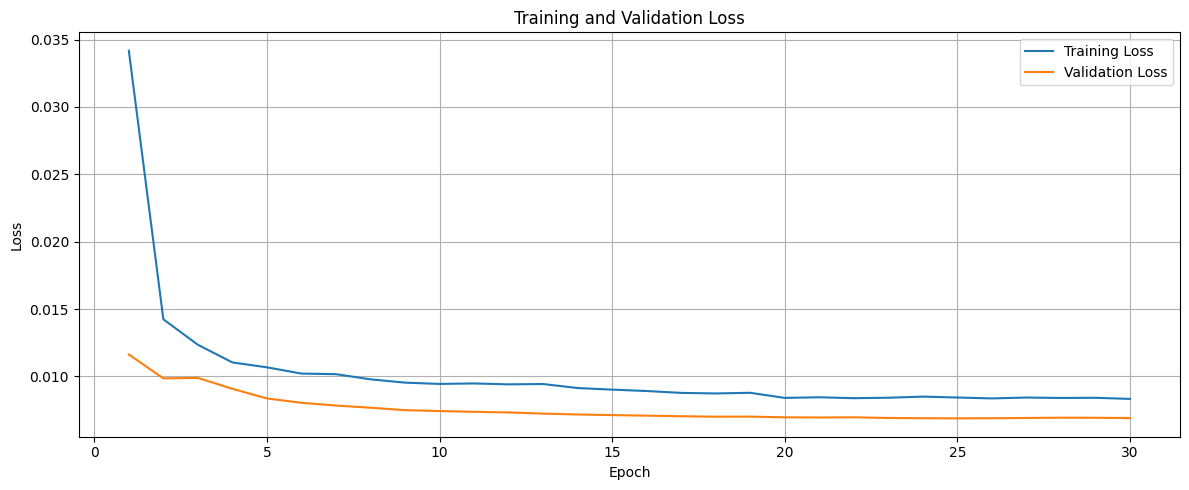

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.303118545984484
	mse = 30.78170982356702
	rmse = 5.548126694981561
	r2 = -0.610900768589606
	mape = 0.2340481684987932
	mnbe = 4.303225184837256
	r_coeff = 0.6164638490438442
	p_value = 2.0639265677830398e-82
avg_mae = 4.303118545984484
avg_mse = 30.78170982356702
avg_rmse = 5.548126694981561
avg_r2 = -0.610900768589606
avg_mape = 0.2340481684987932
avg_mnbe = 4.303225184837256
avg_r_coeff = 0.6164638490438442
avg_p_value = 2.0639265677830398e-82
GRUSeq2SeqReduction._prepare_data(): is called
GRUSeq2SeqReduction._define_model(): is called
GRUSeq2SeqReduction.execute(): is called
GRUSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.1944 - val_loss: 0.0886
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0702 - val_loss: 0.0877
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0653 - val_loss: 0.0840
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0632 - val_loss: 0.0820
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0592 - val_loss: 0.0812
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0519 - val_loss: 0.0777
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0420 - val_loss: 0.0751
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0383 - val_loss: 0.0590
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1061 - val_loss: 0.0715
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0582 - val_loss: 0.0659
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0406 - val_loss: 0.0618
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

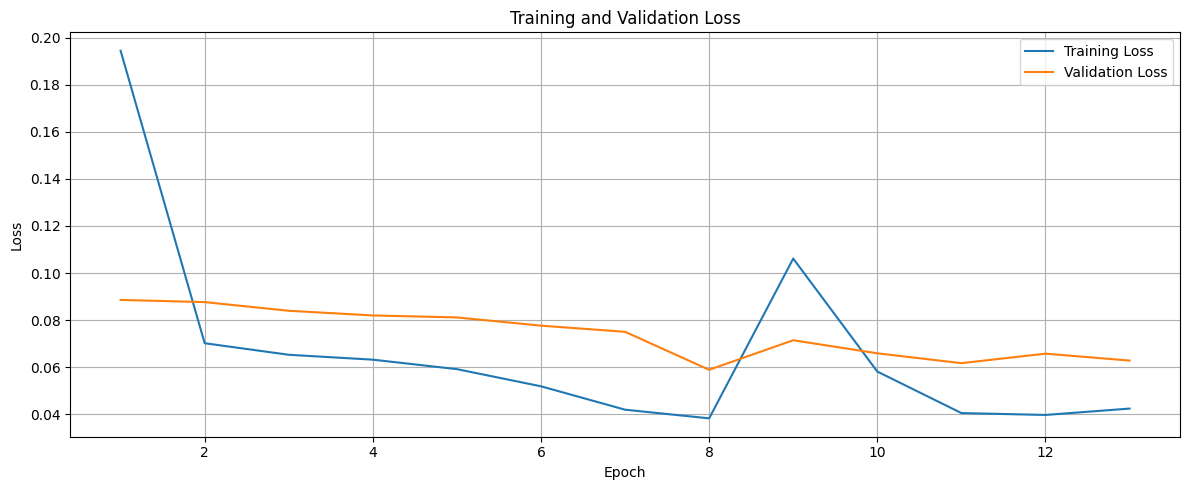

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0571
GRUSeq2SeqReduction.execute(): mae = 0.05713815987110138
GRUSeq2SeqReduction._define_encoder_model(): is called
GRUSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_GRUSeq2SeqReduction_1_future_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 7, 100)    │     36,000 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ [(None, 50),      │     22,800 │ gru_8[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 12)        │        612 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_20    │ (None, 7, 12)     │          0 │ dense_30[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 7, 50)     │      9,600 │ repeat_vector_20… │
│                     │                   │            │ gru_9[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, 7, 18)     │      1,818 │ gru_11[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,292 (1.33 MB)

 Trainable params: 116,430 (454.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,862 (909.62 KB)

None


Model: "aod_GRUSeq2SeqReduction_1_future_12_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,412 (232.08 KB)

 Trainable params: 59,412 (232.08 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_GRUSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_52 (LSTM)      │ [(None, 64),      │     19,968 │ input_layer_32[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_21    │ (None, 1, 64)     │          0 │ lstm_52[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_53 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_21… │
│                     │                   │            │ lstm_52[0][1],    │
│                     │                   │            │ lstm_52[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1, 64)     │          0 │ lstm_53[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, 1, 1)      │         65 │ dropout_10[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0515 - val_loss: 0.0113
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0162 - val_loss: 0.0105
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0139 - val_loss: 0.0099
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127 - val_loss: 0.0092
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - val_loss: 0.0088
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - val_loss: 0.0079
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0104 - val_loss: 0.0077
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0077
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

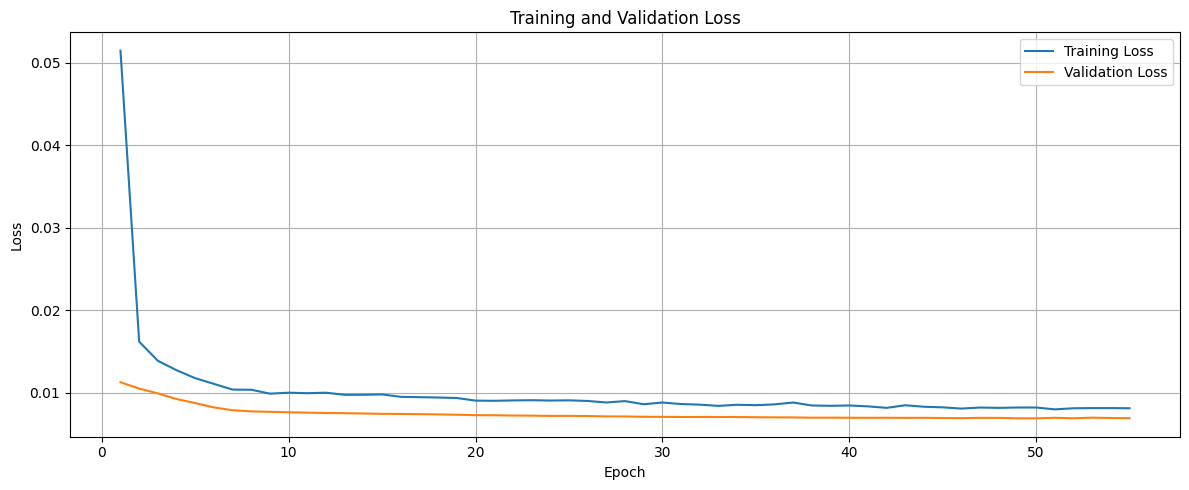

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.364997947634771
	mse = 30.958232302697482
	rmse = 5.564012248611381
	r2 = -0.7944392768979163
	mape = 0.2345565647393991
	mnbe = 5.599233084389272
	r_coeff = 0.6208292052052726
	p_value = 6.934011411197559e-84
avg_mae = 4.364997947634771
avg_mse = 30.958232302697482
avg_rmse = 5.564012248611381
avg_r2 = -0.7944392768979163
avg_mape = 0.2345565647393991
avg_mnbe = 5.599233084389272
avg_r_coeff = 0.6208292052052726
avg_p_value = 6.934011411197559e-84
GRUSeq2SeqReduction._prepare_data(): is called
GRUSeq2SeqReduction._define_model(): is called
GRUSeq2SeqReduction.execute(): is called
GRUSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.1880 - val_loss: 0.1048
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0798 - val_loss: 0.0862
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0654 - val_loss: 0.0824
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0597 - val_loss: 0.0816
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0542 - val_loss: 0.0782
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0454 - val_loss: 0.0716
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0397 - val_loss: 0.0712
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0520 - val_loss: 0.0746
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0556 - val_loss: 0.0686
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0497 - val_loss: 0.0662
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0357 - val_loss: 0.0582
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

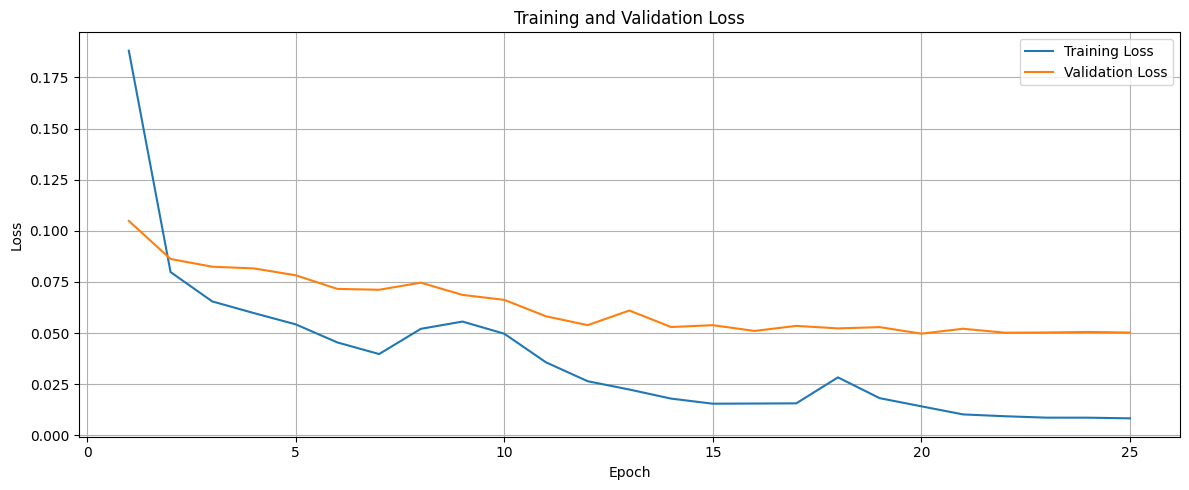

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0394
GRUSeq2SeqReduction.execute(): mae = 0.039426289498806
GRUSeq2SeqReduction._define_encoder_model(): is called
GRUSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_GRUSeq2SeqReduction_1_future_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ [(None, 50),      │     22,800 │ gru_12[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 13)        │        663 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_22    │ (None, 7, 13)     │          0 │ dense_33[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 7, 50)     │      9,750 │ repeat_vector_22… │
│                     │                   │            │ gru_13[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, 7, 18)     │      1,818 │ gru_15[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,895 (1.33 MB)

 Trainable params: 116,631 (455.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,264 (911.19 KB)

None


Model: "aod_GRUSeq2SeqReduction_1_future_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,463 (232.28 KB)

 Trainable params: 59,463 (232.28 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_GRUSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_54 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_35[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_23    │ (None, 1, 64)     │          0 │ lstm_54[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_55 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_23… │
│                     │                   │            │ lstm_54[0][1],    │
│                     │                   │            │ lstm_54[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 1, 64)     │          0 │ lstm_55[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, 1, 1)      │         65 │ dropout_11[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0382 - val_loss: 0.0115
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0150 - val_loss: 0.0108
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0135 - val_loss: 0.0102
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0123 - val_loss: 0.0093
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - val_loss: 0.0087
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0108 - val_loss: 0.0084
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0107 - val_loss: 0.0083
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0104 - val_loss: 0.0081
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0100 - val_loss: 0.0079
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0078
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0100 - val_loss: 0.0077
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

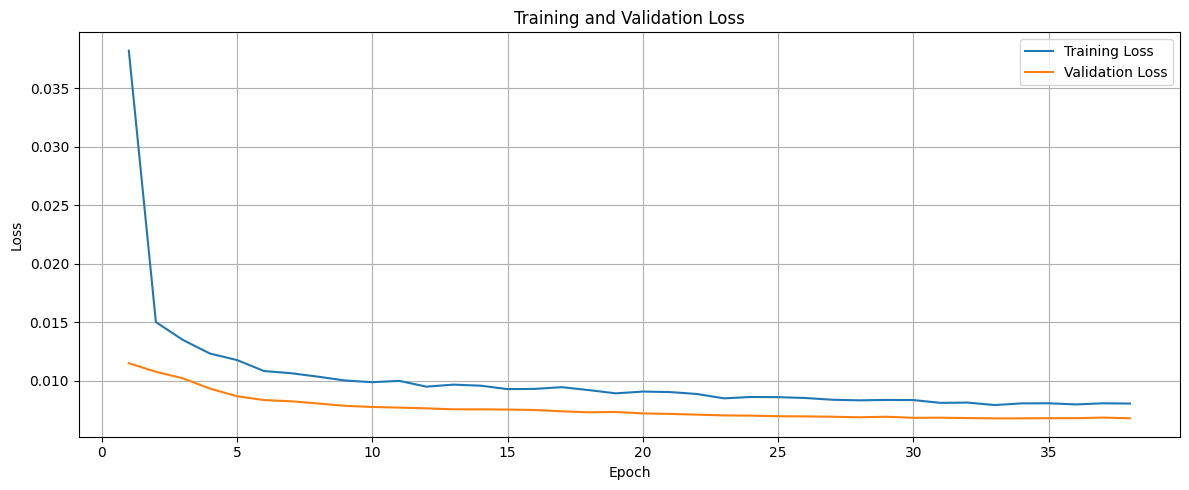

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.24951128591639
	mse = 30.515059468208943
	rmse = 5.524043760526245
	r2 = -0.5405228959131694
	mape = 0.23133141963026127
	mnbe = 4.121178609527081
	r_coeff = 0.6202436961764176
	p_value = 1.0964780027248504e-83
avg_mae = 4.24951128591639
avg_mse = 30.515059468208943
avg_rmse = 5.524043760526245
avg_r2 = -0.5405228959131694
avg_mape = 0.23133141963026127
avg_mnbe = 4.121178609527081
avg_r_coeff = 0.6202436961764176
avg_p_value = 1.0964780027248504e-83
GRUSeq2SeqReduction._prepare_data(): is called
GRUSeq2SeqReduction._define_model(): is called
GRUSeq2SeqReduction.execute(): is called
GRUSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.1894 - val_loss: 0.0879
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0768 - val_loss: 0.0851
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0619 - val_loss: 0.0831
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0574 - val_loss: 0.0784
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0499 - val_loss: 0.0694
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0415 - val_loss: 0.0849
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0517 - val_loss: 0.0750
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0426 - val_loss: 0.0641
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0275 - val_loss: 0.0588
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0404 - val_loss: 0.0615
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0275 - val_loss: 0.0596
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

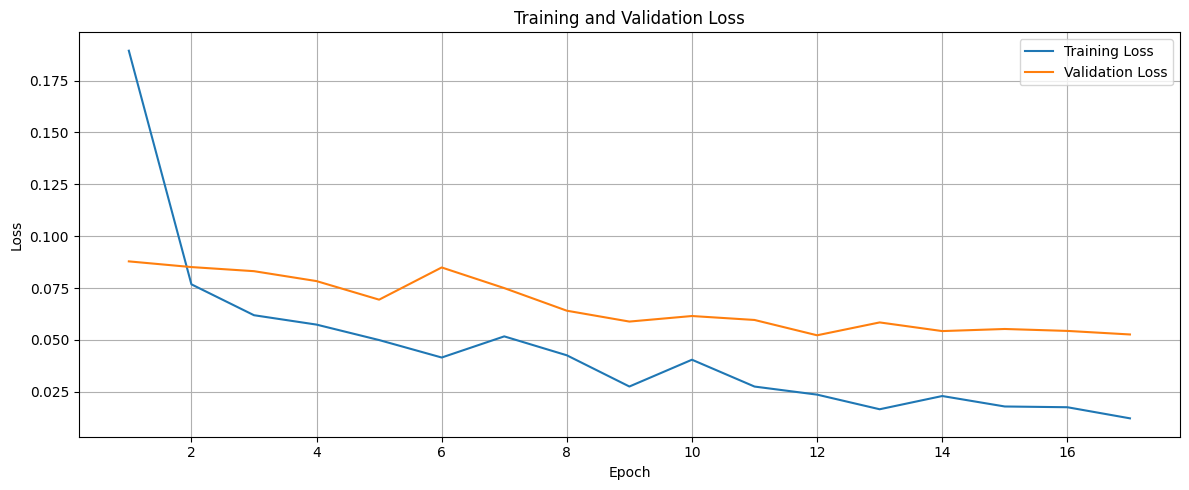

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0391
GRUSeq2SeqReduction.execute(): mae = 0.03906536102294922
GRUSeq2SeqReduction._define_encoder_model(): is called
GRUSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_GRUSeq2SeqReduction_1_future_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ [(None, 50),      │     22,800 │ gru_16[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 14)        │        714 │ gru_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_24    │ (None, 7, 14)     │          0 │ dense_36[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 7, 50)     │      9,900 │ repeat_vector_24… │
│                     │                   │            │ gru_17[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, 7, 18)     │      1,818 │ gru_19[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 350,498 (1.34 MB)

 Trainable params: 116,832 (456.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,666 (912.76 KB)

None


Model: "aod_GRUSeq2SeqReduction_1_future_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,514 (232.48 KB)

 Trainable params: 59,514 (232.48 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_56 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_38[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_25    │ (None, 1, 64)     │          0 │ lstm_56[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_57 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_25… │
│                     │                   │            │ lstm_56[0][1],    │
│                     │                   │            │ lstm_56[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 1, 64)     │          0 │ lstm_57[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, 1, 1)      │         65 │ dropout_12[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0411 - val_loss: 0.0116
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0162 - val_loss: 0.0109
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0135 - val_loss: 0.0096
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0117 - val_loss: 0.0088
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105 - val_loss: 0.0084
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0108 - val_loss: 0.0080
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0100 - val_loss: 0.0077
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0101 - val_loss: 0.0076
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0096 - val_loss: 0.0076
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

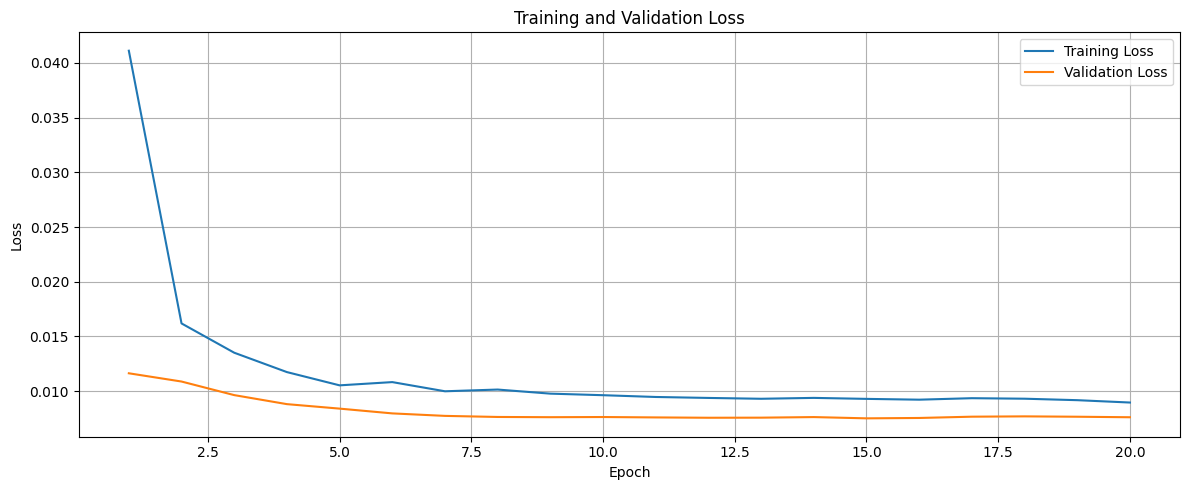

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.318246069767342
	mse = 32.486372093526604
	rmse = 5.6996817537057805
	r2 = -1.3411367587345082
	mape = 0.24482025215572809
	mnbe = -0.7451179395185258
	r_coeff = 0.5788496704472217
	p_value = 1.284745512186019e-70
avg_mae = 4.318246069767342
avg_mse = 32.486372093526604
avg_rmse = 5.6996817537057805
avg_r2 = -1.3411367587345082
avg_mape = 0.24482025215572809
avg_mnbe = -0.7451179395185258
avg_r_coeff = 0.5788496704472217
avg_p_value = 1.284745512186019e-70
GRUSeq2SeqReduction._prepare_data(): is called
GRUSeq2SeqReduction._define_model(): is called
GRUSeq2SeqReduction.execute(): is called
GRUSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.1914 - val_loss: 0.1181
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0753 - val_loss: 0.0832
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0669 - val_loss: 0.0821
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0610 - val_loss: 0.0781
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0550 - val_loss: 0.0699
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0433 - val_loss: 0.0637
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0360 - val_loss: 0.0587
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0395 - val_loss: 0.0732
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0557 - val_loss: 0.0798
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0552 - val_loss: 0.0800
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0461 - val_loss: 0.0669
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

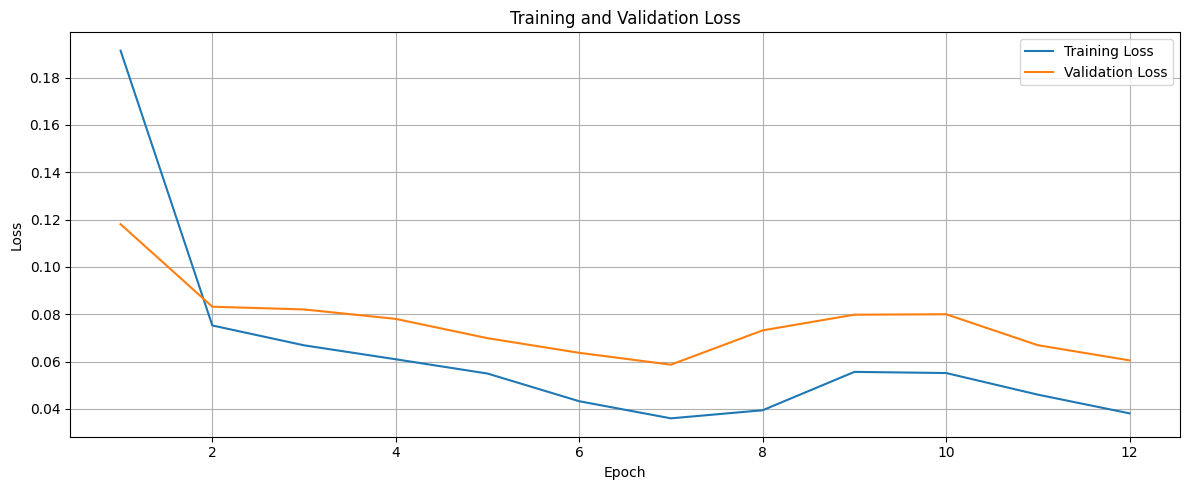

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0620
GRUSeq2SeqReduction.execute(): mae = 0.061953771859407425
GRUSeq2SeqReduction._define_encoder_model(): is called
GRUSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_GRUSeq2SeqReduction_1_future_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_20 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_21 (GRU)        │ [(None, 50),      │     22,800 │ gru_20[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 15)        │        765 │ gru_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_26    │ (None, 7, 15)     │          0 │ dense_39[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_22 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_26… │
│                     │                   │            │ gru_21[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_23 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, 7, 18)     │      1,818 │ gru_23[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,101 (1.34 MB)

 Trainable params: 117,033 (457.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,068 (914.33 KB)

None


Model: "aod_GRUSeq2SeqReduction_1_future_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,565 (232.68 KB)

 Trainable params: 59,565 (232.68 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_58 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_41[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_27    │ (None, 1, 64)     │          0 │ lstm_58[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_59 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_27… │
│                     │                   │            │ lstm_58[0][1],    │
│                     │                   │            │ lstm_58[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 1, 64)     │          0 │ lstm_59[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 1, 1)      │         65 │ dropout_13[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0319 - val_loss: 0.0118
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0135 - val_loss: 0.0094
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0125 - val_loss: 0.0088
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0101 - val_loss: 0.0077
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0096 - val_loss: 0.0076
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0096 - val_loss: 0.0073
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - val_loss: 0.0073
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - val_loss: 0.0072
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091 - val_loss: 0.0072
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

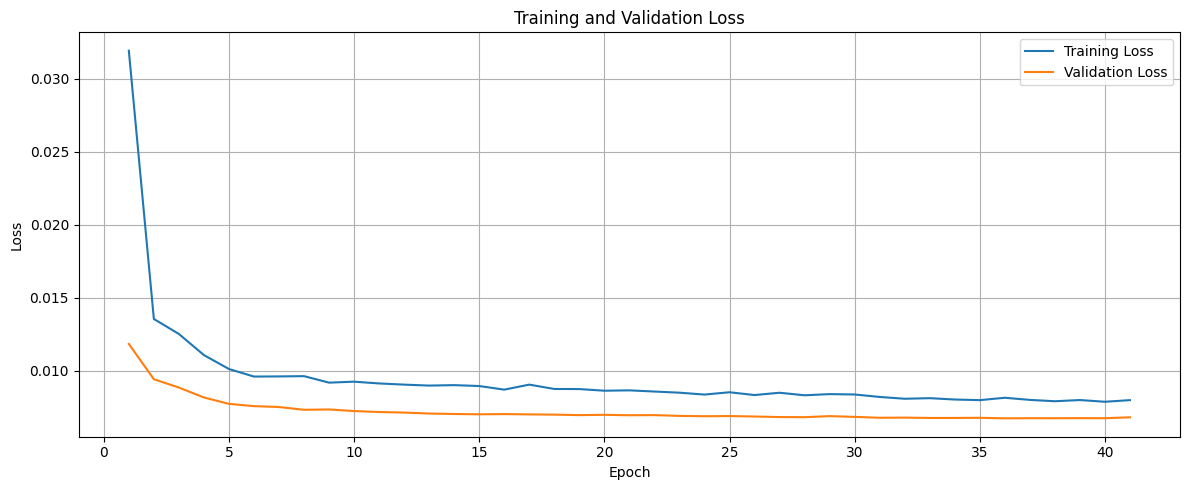

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.230620296469671
	mse = 30.235433278869884
	rmse = 5.498675593165129
	r2 = -0.6602150814867926
	mape = 0.23092113273478482
	mnbe = 3.5506167218543445
	r_coeff = 0.6223820293367165
	p_value = 2.0470519246802962e-84
avg_mae = 4.230620296469671
avg_mse = 30.235433278869884
avg_rmse = 5.498675593165129
avg_r2 = -0.6602150814867926
avg_mape = 0.23092113273478482
avg_mnbe = 3.5506167218543445
avg_r_coeff = 0.6223820293367165
avg_p_value = 2.0470519246802962e-84
GRUSeq2SeqReduction._prepare_data(): is called
GRUSeq2SeqReduction._define_model(): is called
GRUSeq2SeqReduction.execute(): is called
GRUSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.1848 - val_loss: 0.1084
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0780 - val_loss: 0.0864
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0618 - val_loss: 0.0847
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0595 - val_loss: 0.0835
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0552 - val_loss: 0.0799
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0457 - val_loss: 0.0750
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0442 - val_loss: 0.0637
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0600 - val_loss: 0.0718
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0553 - val_loss: 0.0817
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0389 - val_loss: 0.0686
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0349 - val_loss: 0.0753
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

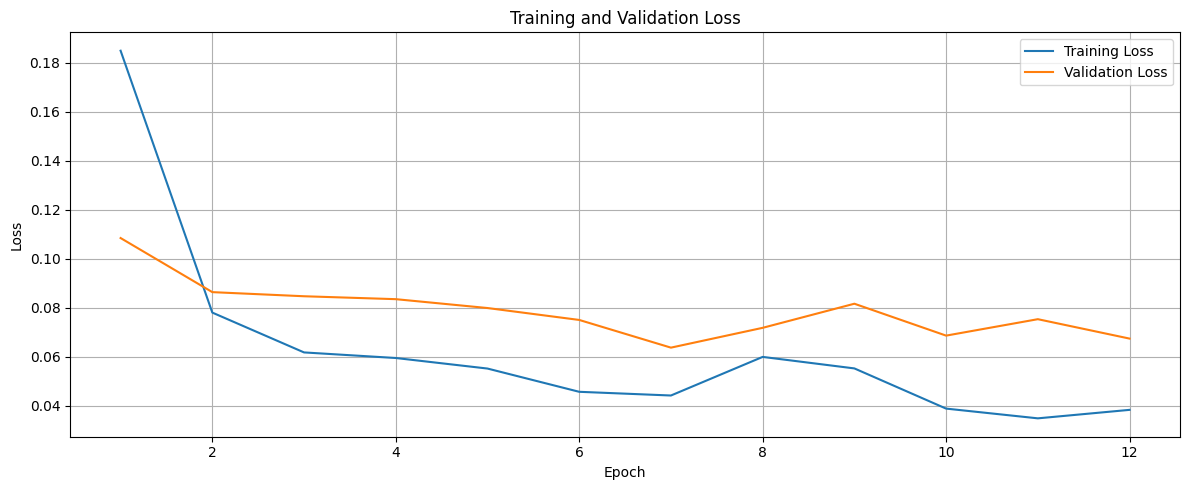

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0659
GRUSeq2SeqReduction.execute(): mae = 0.06585032492876053
GRUSeq2SeqReduction._define_encoder_model(): is called
GRUSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_GRUSeq2SeqReduction_1_future_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_24 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_42[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_25 (GRU)        │ [(None, 50),      │     22,800 │ gru_24[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 16)        │        816 │ gru_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_28    │ (None, 7, 16)     │          0 │ dense_42[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_26 (GRU)        │ (None, 7, 50)     │     10,200 │ repeat_vector_28… │
│                     │                   │            │ gru_25[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_27 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, 7, 18)     │      1,818 │ gru_27[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,704 (1.34 MB)

 Trainable params: 117,234 (457.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,470 (915.90 KB)

None


Model: "aod_GRUSeq2SeqReduction_1_future_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,616 (232.88 KB)

 Trainable params: 59,616 (232.88 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_GRUSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_60 (LSTM)      │ [(None, 64),      │     20,992 │ input_layer_44[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_29    │ (None, 1, 64)     │          0 │ lstm_60[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_61 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_29… │
│                     │                   │            │ lstm_60[0][1],    │
│                     │                   │            │ lstm_60[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 1, 64)     │          0 │ lstm_61[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, 1, 1)      │         65 │ dropout_14[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,081 (211.25 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0340 - val_loss: 0.0121
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0143 - val_loss: 0.0097
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127 - val_loss: 0.0092
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113 - val_loss: 0.0084
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105 - val_loss: 0.0079
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0100 - val_loss: 0.0075
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0103 - val_loss: 0.0075
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - val_loss: 0.0075
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - val_loss: 0.0076
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0075
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0097 - val_loss: 0.0075
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

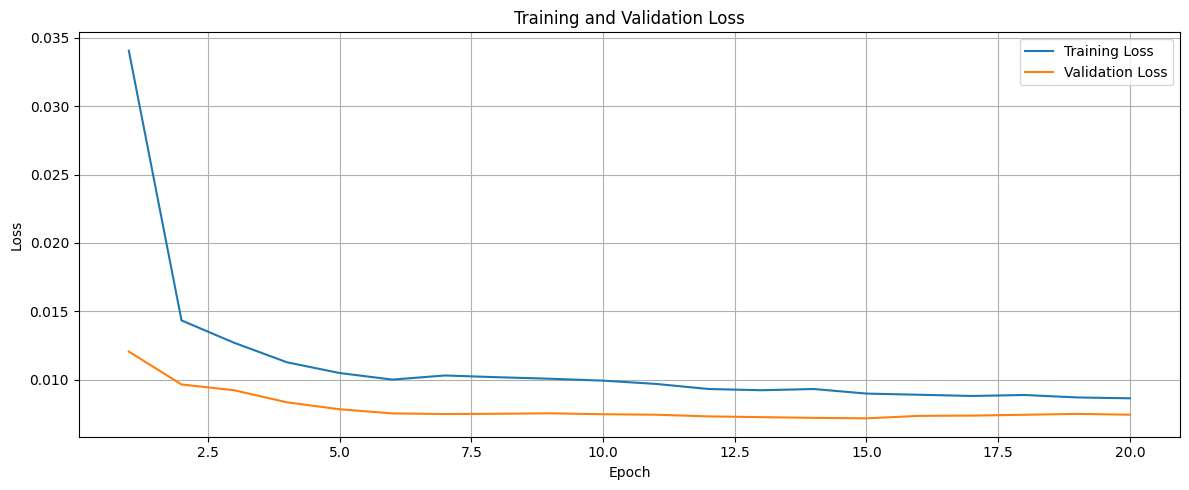

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.558640990568917
	mse = 33.425492886253316
	rmse = 5.78147843429804
	r2 = -1.0068713275158068
	mape = 0.2434949513864255
	mnbe = 5.805603788500586
	r_coeff = 0.5793801595717893
	p_value = 8.975204987606704e-71
avg_mae = 4.558640990568917
avg_mse = 33.425492886253316
avg_rmse = 5.78147843429804
avg_r2 = -1.0068713275158068
avg_mape = 0.2434949513864255
avg_mnbe = 5.805603788500586
avg_r_coeff = 0.5793801595717893
avg_p_value = 8.975204987606704e-71
GRUSeq2SeqReduction._prepare_data(): is called
GRUSeq2SeqReduction._define_model(): is called
GRUSeq2SeqReduction.execute(): is called
GRUSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.2006 - val_loss: 0.1030
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0760 - val_loss: 0.0842
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0641 - val_loss: 0.0836
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0583 - val_loss: 0.0813
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0531 - val_loss: 0.0740
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0430 - val_loss: 0.0665
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0343 - val_loss: 0.0622
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0292 - val_loss: 0.0726
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0597 - val_loss: 0.0696
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0339 - val_loss: 0.0577
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0235 - val_loss: 0.0593
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

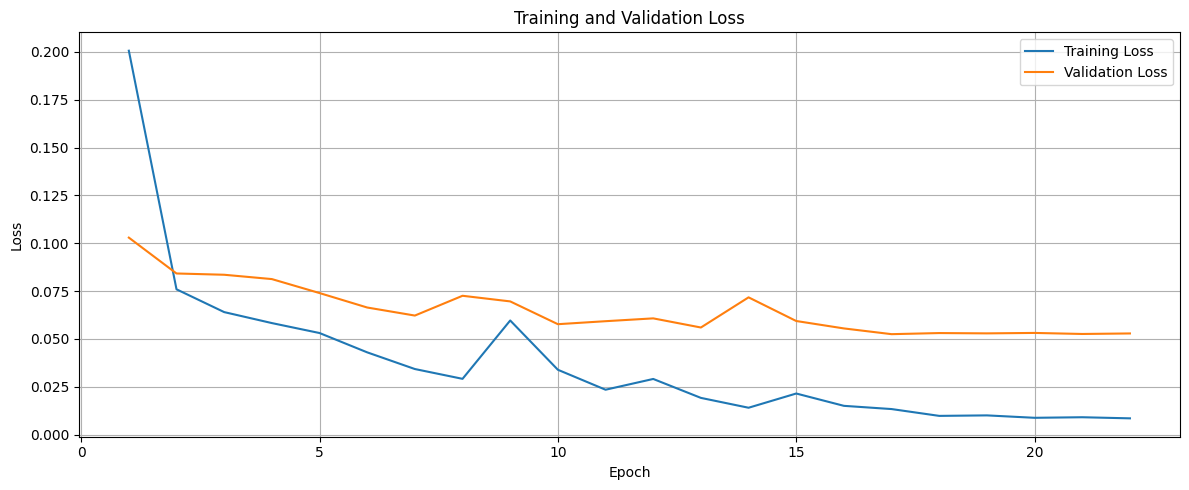

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0398
GRUSeq2SeqReduction.execute(): mae = 0.039807047694921494
GRUSeq2SeqReduction._define_encoder_model(): is called
GRUSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "aod_GRUSeq2SeqReduction_1_future_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_28 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_45[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_29 (GRU)        │ [(None, 50),      │     22,800 │ gru_28[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 17)        │        867 │ gru_29[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_30    │ (None, 7, 17)     │          0 │ dense_45[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_30 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_30… │
│                     │                   │            │ gru_29[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_31 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, 7, 18)     │      1,818 │ gru_31[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,307 (1.34 MB)

 Trainable params: 117,435 (458.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,872 (917.47 KB)

None


Model: "aod_GRUSeq2SeqReduction_1_future_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_28 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,667 (233.07 KB)

 Trainable params: 59,667 (233.07 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_GRUSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_47      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_62 (LSTM)      │ [(None, 64),      │     21,248 │ input_layer_47[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_31    │ (None, 1, 64)     │          0 │ lstm_62[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_63 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_31… │
│                     │                   │            │ lstm_62[0][1],    │
│                     │                   │            │ lstm_62[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 1, 64)     │          0 │ lstm_63[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_31 │ (None, 1, 1)      │         65 │ dropout_15[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,337 (212.25 KB)

 Trainable params: 54,337 (212.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0350 - val_loss: 0.0126
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0160 - val_loss: 0.0113
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136 - val_loss: 0.0099
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0125 - val_loss: 0.0091
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0111 - val_loss: 0.0084
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - val_loss: 0.0078
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099 - val_loss: 0.0077
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0097 - val_loss: 0.0076
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0094 - val_loss: 0.0075
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

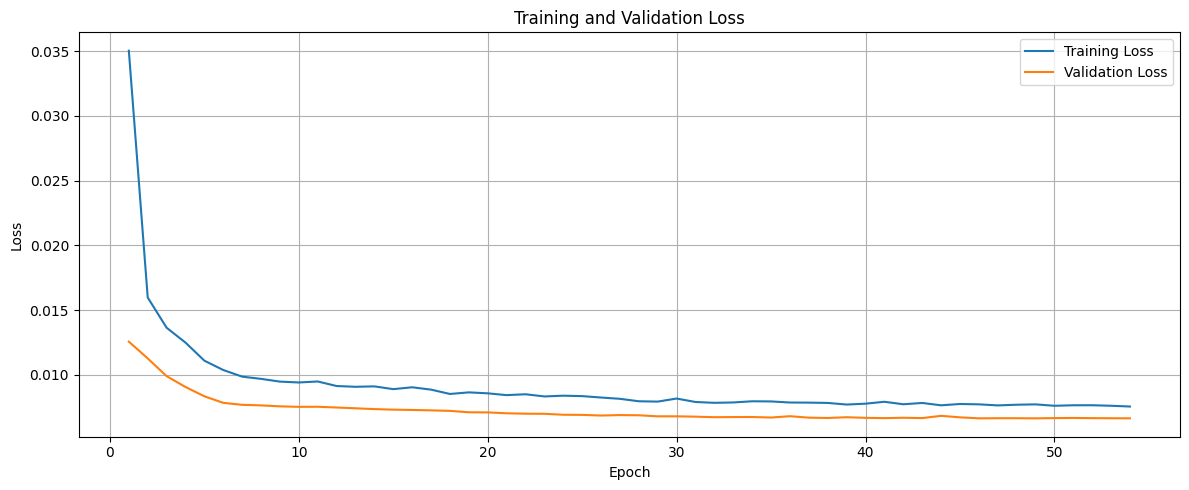

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.098606507833549
	mse = 29.835779482283563
	rmse = 5.462213789507287
	r2 = -0.3574933749439011
	mape = 0.22792290340111404
	mnbe = 1.8427804486464199
	r_coeff = 0.6257037704913879
	p_value = 1.4709632968415285e-85
avg_mae = 4.098606507833549
avg_mse = 29.835779482283563
avg_rmse = 5.462213789507287
avg_r2 = -0.3574933749439011
avg_mape = 0.22792290340111404
avg_mnbe = 1.8427804486464199
avg_r_coeff = 0.6257037704913879
avg_p_value = 1.4709632968415285e-85
Choosing the best result

dict_keys([10, 11, 12, 13, 14, 15, 16, 17])
N = 10
mae = 4.577415122800859
mse = 32.215581603111175
rmse = 5.675877165963969
r2 = -1.1292139396754606
mape = 0.24038674184724343
mnbe = 8.203581611154643
r_coeff = 0.62197334151530

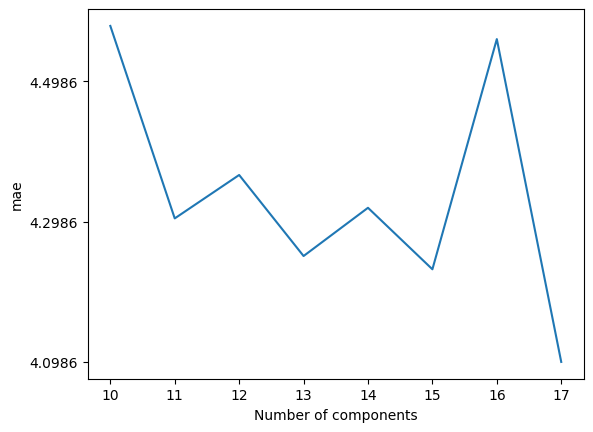

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


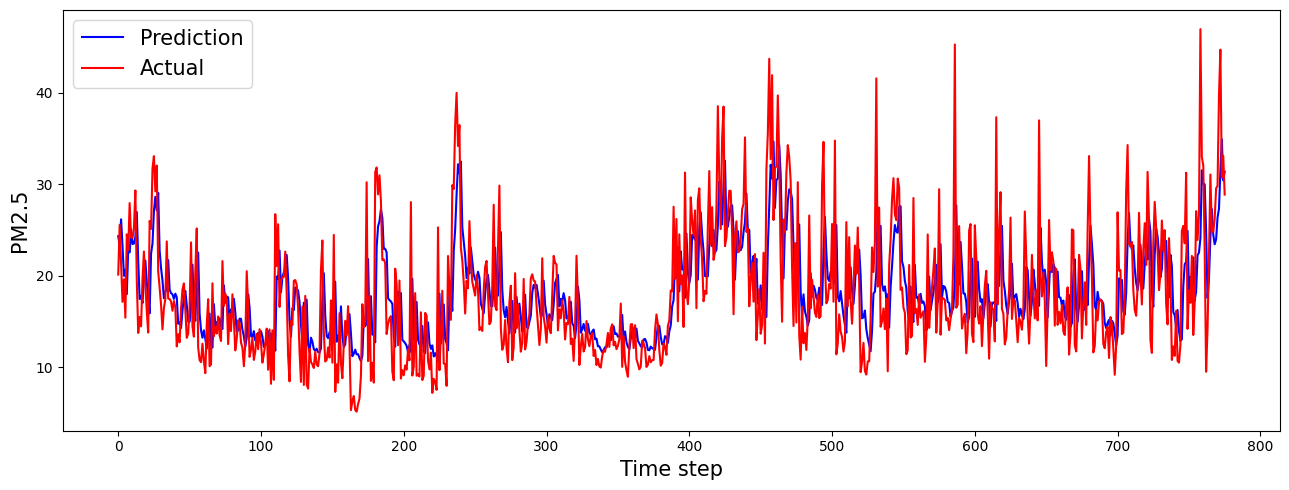

dim_reduction_method  dim_after_reduction prediction  n_future       mae  \
0         LSTM-Seq2Seq                   10       LSTM         1  4.266625   
1          GRU-Seq2Seq                   17       LSTM         1  4.098607   

         mse      rmse        r2      mape      mnbe   r_coeff       p_value  
0  30.222570  5.497506 -0.913026  0.232827  3.635919  0.625307  2.018159e-85  
1  29.835779  5.462214 -0.357493  0.227923  1.842780  0.625704  1.470963e-85

In [43]:
# Loop every n_future
grus2s_n_future_mapper = {}

for prediction_n_future in range_of_n_future:
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    loopresults = generate_loopresults(X_aod_scaled, y_aod_scaled,
                                       aod_label_scaler,
                                       range_of_dimension,
                                       GRUSeq2SeqReduction,
                                       LSTMPrediction,
                                       "aod", "aod",
                                       reduction_n_past, reduction_n_future,
                                       reduction_epochs, reduction_batch_size,
                                       prediction_n_past, prediction_n_future,
                                       prediction_epochs, prediction_batch_size,
                                       saved_model_weight_dir, saved_model_plot_dir)
    best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path = choose_the_best(loopresults, "mae", prediction_n_future)
    
    # Update the evaluation board
    evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
    evaluation_board['dim_after_reduction'] += [best_num_of_components]
    evaluation_board['n_future'] += [prediction_n_future]
    evaluation_board['prediction'] += ["LSTM"]
    for metric, value in best_metrics.items():
        evaluation_board[metric] += [value]
    display(pd.DataFrame(evaluation_board))

    # Update n_future mapper
    grus2s_n_future_mapper[prediction_n_future] = (best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path)

#### Prepare reduced data

In [44]:
# Create the mapper for inference data
grus2s_n_future_inference_mapper = {}

# Loop over n_future mapper
for prediction_n_future, (best_encoded_data, _, best_encoder_model_path, best_prediction_model_path) in grus2s_n_future_mapper.items():
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    
    # Copy the best reduction model to target directory
    shutil.copy(best_encoder_model_path, conf["workspace"]["best_model_weight_dir"])
    shutil.copy(best_prediction_model_path, conf["workspace"]["best_model_weight_dir"])
    
    # Inference LSTM
    pred_pm25_from_df_grus2s_reduced = inferenceLSTM(best_encoded_data, y_aod_scaled,
                                                        prediction_n_past, prediction_n_future,
                                                        best_prediction_model_path, verbose=1)
    inv_pred_pm25_from_df_grus2s_reduced = aod_label_scaler.inverse_transform(np.squeeze(pred_pm25_from_df_grus2s_reduced, axis=-1))
    print(inv_pred_pm25_from_df_grus2s_reduced.shape)
    
    # Prepare the reduced data
    df_grus2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices,
                                            (aod_station_column, "station"),
                                            *[(inv_pred_pm25_from_df_grus2s_reduced[:, day], f"predicted_pm25_day_{day+1}") for day in range(inv_pred_pm25_from_df_grus2s_reduced.shape[-1])],
                                            (aod_pm25_3km_column, "pm25_3km"))
    df_grus2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data_dir"], f"df_grus2s_reduced_2018_2022_{prediction_n_future}_day.csv"))
    df_grus2s_reduced.to_csv(os.path.join(conf["workspace"]["data_to_store_in_hdfs_dir"], f"vientham_2018_2022_reduced_with_grus2s_{prediction_n_future}_day.csv"))
    display(df_grus2s_reduced)

    # Update the n_future inference mapper
    grus2s_n_future_inference_mapper[prediction_n_future] = df_grus2s_reduced



PREDICTION WITH N_FUTURE = 1

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(3889, 1)


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.014773       0.279897       0.040188       0.057026   
2018-01-02       0.014773       0.279897       0.040188       0.057026   
2018-01-03       0.014746       0.279260       0.040021       0.057109   
2018-01-04       0.014588       0.280773       0.039746       0.057110   
2018-01-05       0.014525       0.283811       0.039913       0.056974   
...                   ...            ...            ...            ...   
2022-12-27       0.053571       0.083456       0.066063       0.070749   
2022-12-28       0.053482       0.083732       0.065967       0.070489   
2022-12-29       0.053367       0.083803       0.066003       0.070299   
2022-12-30       0.053178       0.083959       0.066402       0.070377   
2022-12-31       0.053132       0.083719       0.066925       0.070970   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.063676       0.022538       0.013828       0.063475   
2018-01-02       0.063676       0.022538       0.013828       0.063475   
2018-01-03       0.063895       0.022501       0.013815       0.063307   
2018-01-04       0.064002       0.022343       0.013606       0.063102   
2018-01-05       0.063880       0.022200       0.013302       0.062938   
...                   ...            ...            ...            ...   
2022-12-27       0.088218       0.026322       0.049923       0.097914   
2022-12-28       0.088529       0.026265       0.049605       0.097318   
2022-12-29       0.088401       0.026313       0.049590       0.097608   
2022-12-30       0.088550       0.026409       0.049358       0.098010   
2022-12-31       0.088998       0.026350       0.049475       0.098533   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.021113        0.017811        0.150278        0.054249   
2018-01-02       0.021113        0.017811        0.150278        0.054249   
2018-01-03       0.021081        0.017707        0.150822        0.054222   
2018-01-04       0.020939        0.017459        0.151100        0.054019   
2018-01-05       0.020815        0.017267        0.149893        0.054113   
...                   ...             ...             ...             ...   
2022-12-27       0.044465        0.047912        0.055062        0.073233   
2022-12-28       0.044338        0.047593        0.055545        0.073737   
2022-12-29       0.044444        0.047823        0.055493        0.073623   
2022-12-30       0.044504        0.047989        0.055402        0.073531   
2022-12-31       0.044557        0.048078        0.054816        0.073195   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2018-01-01        0.023975        0.038172        0.055324        0.076232   
2018-01-02        0.023975        0.038172        0.055324        0.076232   
2018-01-03        0.023894        0.038173        0.055327        0.076704   
2018-01-04        0.023605        0.037890        0.055104        0.077320   
2018-01-05        0.023306        0.037678        0.054656        0.077558   
...                    ...             ...             ...             ...   
2022-12-27        0.043304        0.077248        0.039542        0.060528   
2022-12-28        0.043074        0.077416        0.039765        0.060737   
2022-12-29        0.043133        0.077120        0.039723        0.060782   
2022-12-30        0.043020        0.076609        0.039623        0.060716   
2022-12-31        0.042974        0.076291        0.039504        0.060266   

            aod_feature_17  station  predicted_pm25_day_1   pm25_3km 

#### Compare MAE with pm25_3km



PREDICTION WITH N_FUTURE = 1

(776, 1)
(776, 1)


Day 1:

current_day_inv_y_pred.shape =  (776,)
test_len =  776
On test data:
Metrics between actual and pm25_3km
mae: 6.785086281801943
mse: 87.2793385941348
rmse: 9.34234117307513
r2: -0.7928541596397412
mape: 0.41985536540161267
mnbe: -6.396618152257187
r_coeff: 0.30791322778668884
Metrics between actual and predicted
mae: 4.098606507833549
mse: 29.835779482283563
rmse: 5.462213789507287
r2: 0.3871264125906111
mape: 0.24971187934682826
mnbe: -1.8094365238870398
r_coeff: 0.625703770491388


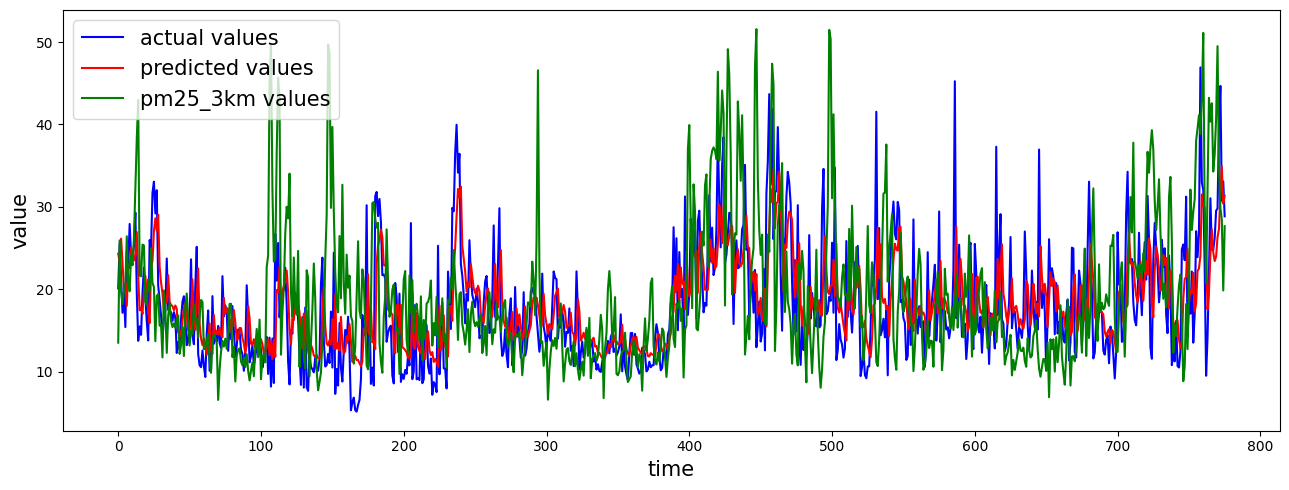

On entire data:
mae: 7.875957292759844
mse: 113.65471755090876
rmse: 10.660896657922764
r2: -0.07128729764249964
mape: 0.34821379393500074
mnbe: 14.79075075838297
r_coeff: 0.4754473311691296
Metrics between actual and predicted
mae: 5.061341905445716
mse: 49.66724086721902
rmse: 7.047498908635532
r2: 0.5318462321973652
mape: 0.2327076336619468
mnbe: 3.3181341069456494
r_coeff: 0.73303717106482


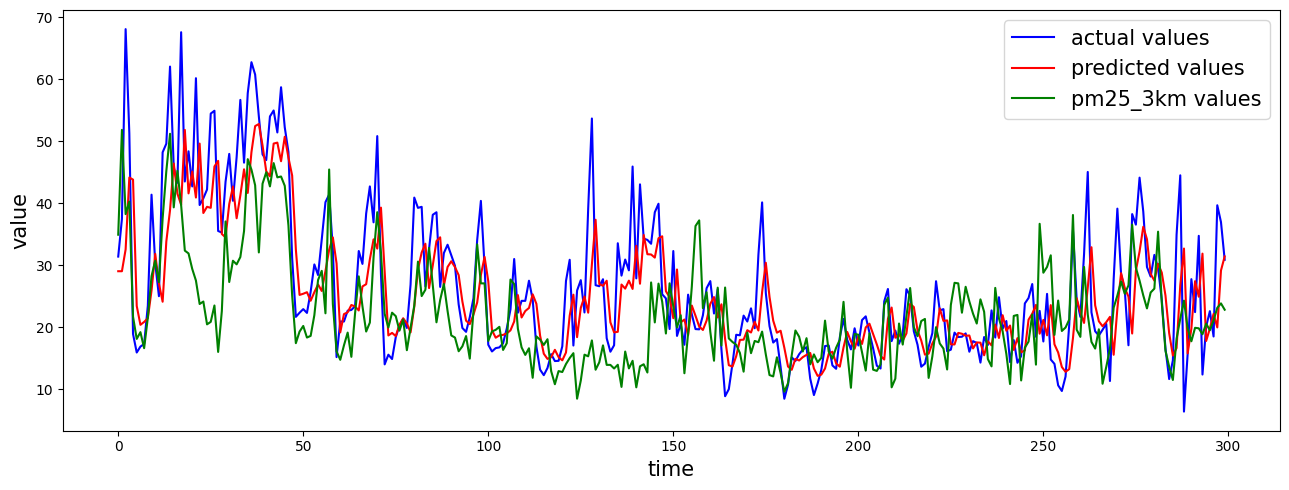

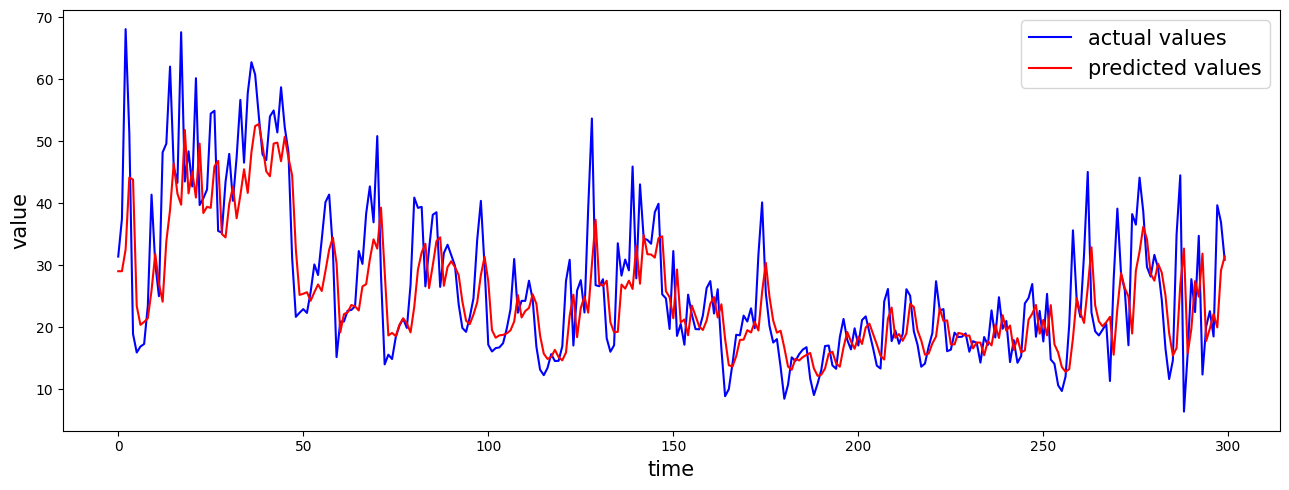

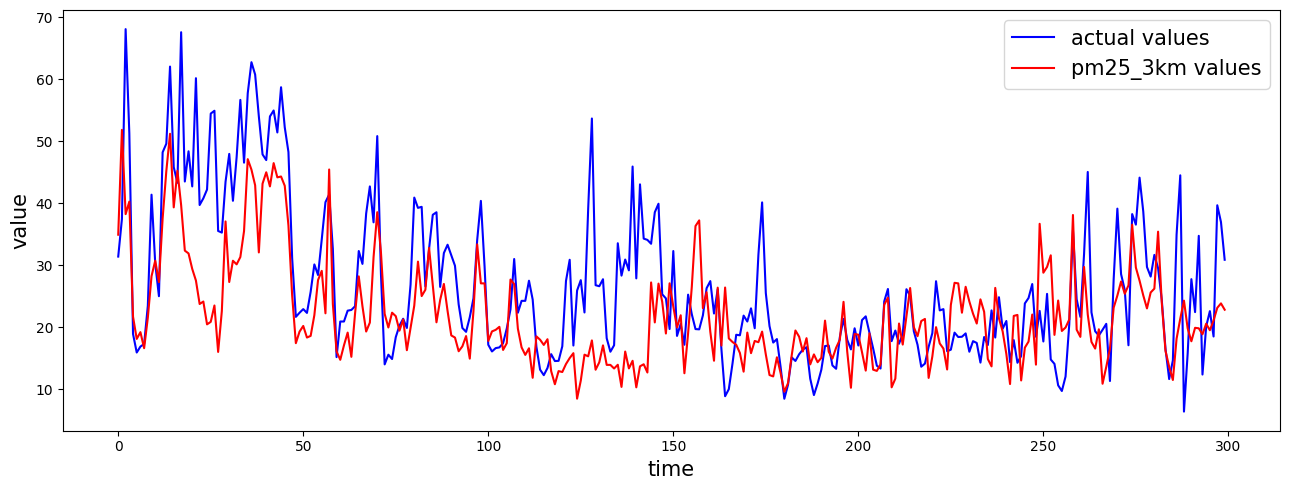

In [45]:

for prediction_n_future, (best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path) in grus2s_n_future_mapper.items():
    
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    
    # Compare test set only
    all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
    df_grus2s_reduced = grus2s_n_future_inference_mapper[prediction_n_future]

    print(all_days_inv_y_pred.shape)
    print(all_days_inv_y_test.shape)
    
    for day in range(prediction_n_future):
        
        print("\n" + "=" * 50 + "\n")
        print(f"Day {day+1}:\n")
        
        current_day_inv_y_pred = all_days_inv_y_pred[:, day]
        current_day_inv_y_test = all_days_inv_y_test[:, day]
        print("current_day_inv_y_pred.shape = ", current_day_inv_y_pred.shape)
        
        test_len = current_day_inv_y_test.shape[0]
        print("test_len = ", test_len)
        
        aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
        
        # Compare test dataset
        print("On test data:")
        print("Metrics between actual and pm25_3km")
        for metric, calculator in metrics_calculators.items():
           print(f"{metric}: {calculator(current_day_inv_y_test, aod_pm25_3km_column_test)}")
        print("Metrics between actual and predicted")
        for metric, calculator in metrics_calculators.items():
           print(f"{metric}: {calculator(current_day_inv_y_test, current_day_inv_y_pred)}")
        plot_3_data(data1=current_day_inv_y_test,
                   datalabel1="actual values",
                   data2=current_day_inv_y_pred,
                   datalabel2="predicted values",
                   data3=aod_pm25_3km_column_test,
                   datalabel3="pm25_3km values",
                   ylabel="value",
                   xlabel="time")
        
        # Compare entire dataset
        print("On entire data:")
        current_day_inv_pred_pm25_from_df_grus2s_reduced = df_grus2s_reduced.loc[:, f"predicted_pm25_day_{day+1}"]
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(y_aod.iloc[:, 0], aod_pm25_3km_column)}")
        print("Metrics between actual and predicted")
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(y_aod.iloc[:, 0], current_day_inv_pred_pm25_from_df_grus2s_reduced)}")
        plot_3_data(data1=y_aod.head(300),
                   datalabel1="actual values",
                   data2=current_day_inv_pred_pm25_from_df_grus2s_reduced[:300],
                   datalabel2="predicted values",
                   data3=aod_pm25_3km_column.head(300),
                   datalabel3="pm25_3km values",
                   ylabel="value",
                   xlabel="time")
        plot_2_data(data1=y_aod.head(300),
                   datalabel1="actual values",
                   data2=current_day_inv_pred_pm25_from_df_grus2s_reduced[:300],
                   datalabel2="predicted values",
                   ylabel="value",
                   xlabel="time")
        plot_2_data(data1=y_aod.head(300),
                   datalabel1="actual values",
                   data2=aod_pm25_3km_column.head(300),
                   datalabel2="pm25_3km values",
                   ylabel="value",
                   xlabel="time")

#### Compare MAE with CMAQ pm25

On entire data:
Metrics between actual and cmaq
mae: 8.394844716269084
mse: 131.531765285845
rmse: 11.468729889828472
r2: -0.5079937316171277
mape: 0.4083535368071802
mnbe: 5.784401798824349
r_coeff: 0.257722298418209
Metrics between actual and predicted
mae: 5.398702638509815
mse: 51.72015298739128
rmse: 7.1916724749804395
r2: 0.4070355070977041
mape: 0.2691055611521528
mnbe: 2.2752465163937945
r_coeff: 0.6404954307579335


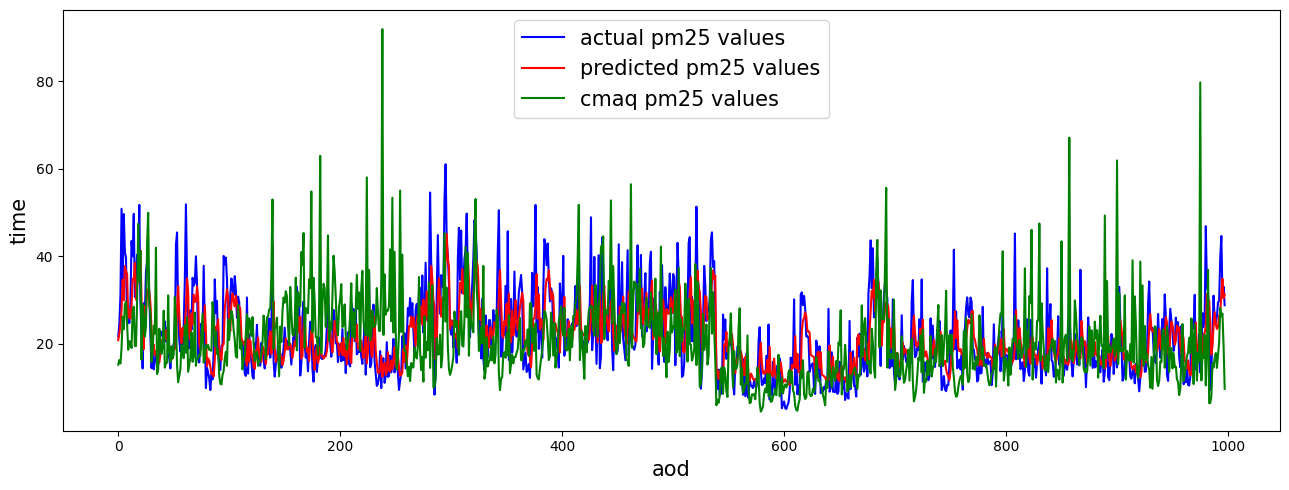

In [46]:

# Remove station 202 for original data
# Only get data in 2022 for AOD
df_aod_dropped_202 = df_aod[df_aod["station"] != 202]
df_aod_dropped_202 = df_aod_dropped_202.loc[((df_aod_dropped_202.index >= "2022-01-01") & (df_aod_dropped_202.index <= "2022-12-31"))]

# After removing 2018-2021 data in AOD, some stations are missing
# so we have so adapt the CMAQ data to fit with AOD data
all_cmaq_data = []
for station in df_aod_dropped_202["station"].unique():
    df_aod_current_station = df_aod_dropped_202[df_aod_dropped_202["station"] == station]
    df_cmaq_current_station = df_cmaq_daily[df_cmaq_daily["station"] == station]
    all_cmaq_data.append(df_cmaq_current_station.loc[df_aod_current_station.index])
df_cmaq_dropped = pd.concat(all_cmaq_data, axis=0)

# Loop over n_future
for prediction_n_future, df_grus2s_reduced in grus2s_n_future_inference_mapper.items():
    df_grus2s_reduced_dropped_202 = df_grus2s_reduced[df_grus2s_reduced["station"] != 202]
    time_mask = ((df_grus2s_reduced_dropped_202.index >= "2022-01-01") & (df_grus2s_reduced_dropped_202.index <= "2022-12-31"))
    df_grus2s_reduced_dropped_202 = df_grus2s_reduced_dropped_202.loc[time_mask]
    
    for day in range(prediction_n_future):
        actual = df_aod_dropped_202["pm25"]
        pred = df_grus2s_reduced_dropped_202.loc[:, f"predicted_pm25_day_{day+1}"]
        cmaq = df_cmaq_dropped["pm25"]
        
        # Compare entire dataset
        print("On entire data:")
        print("Metrics between actual and cmaq")
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(actual, cmaq)}")
        print("Metrics between actual and predicted")
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(actual, pred)}")
        
        # Compare entire dataset
        plot_3_data(data1=actual,
                   datalabel1="actual pm25 values",
                   data2=pred,
                   datalabel2="predicted pm25 values",
                   data3=cmaq,
                   datalabel3="cmaq pm25 values",
                   ylabel="time",
                   xlabel="aod")

### Prediction + CNN-LSTM Seq2seq (n_future = 1 to 3)

#### Doing the loop



PREDICTION WITH N_FUTURE = 1

CNNLSTMSeq2SeqReduction._prepare_data(): is called
CNNLSTMSeq2SeqReduction._define_model(): is called
CNNLSTMSeq2SeqReduction.execute(): is called
CNNLSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.1787 - val_loss: 0.0989
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1086 - val_loss: 0.0960
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0940 - val_loss: 0.0817
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0749 - val_loss: 0.0789
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0658 - val_loss: 0.0810
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0624 - val_loss: 0.0828
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0600 - val_loss: 0.0834
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0582 - val_loss: 0.0848
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0517 - val_loss: 0.0830
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


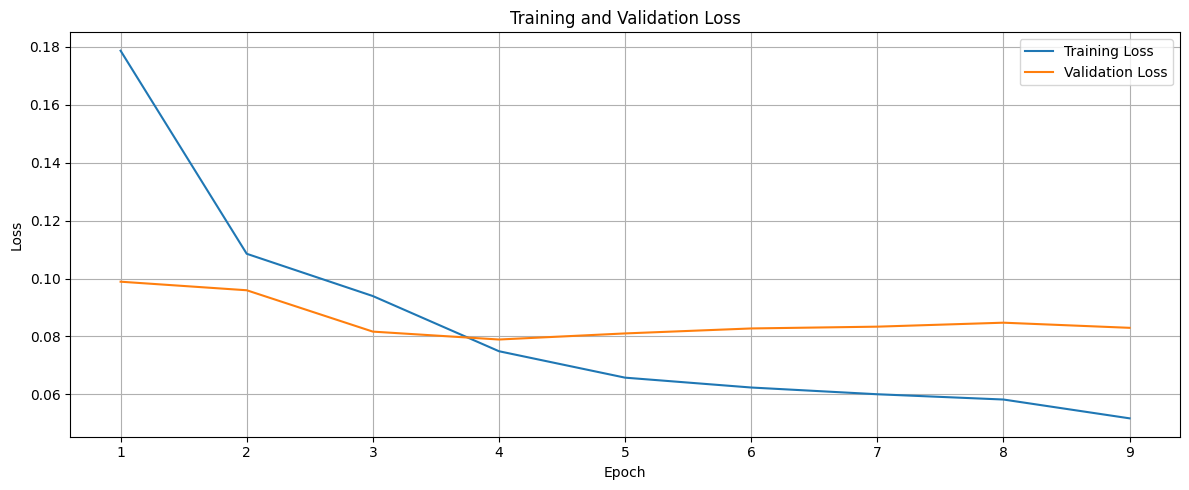

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0719
CNNLSTMSeq2SeqReduction.execute(): mae = 0.07186684012413025
CNNLSTMSeq2SeqReduction._define_encoder_model(): is called
CNNLSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_72      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 6, 128)    │      4,736 │ input_layer_72[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_32    │ (None, 3, 128)    │          0 │ conv1d_32[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 2, 64)     │     16,448 │ max_pooling1d_32… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 1, 64)     │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 64)        │          0 │ max_pooling1d_33… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_56    │ (None, 7, 64)     │          0 │ flatten_8[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_112 (LSTM)     │ (None, 7, 100)    │     66,000 │ repeat_vector_56… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_113 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_112[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 10)        │        510 │ lstm_113[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_57    │ (None, 7, 10)     │          0 │ dense_80[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_114 (LSTM)     │ (None, 7, 50)     │     12,200 │ repeat_vector_57… │
│                     │                   │            │ lstm_113[0][1],   │
│                     │                   │            │ lstm_113[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_115 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_114[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_56 │ (None, 7, 24)     │      2,424 │ lstm_115[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_57 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 580,106 (2.21 MB)

 Trainable params: 193,368 (755.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 386,738 (1.48 MB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_10_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_73 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 6, 128)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_56 (RepeatVector) │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_112 (LSTM)                 │ (None, 7, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_113 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,894 (460.52 KB)

 Trainable params: 117,894 (460.52 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_CNNLSTMSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_74      │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_116 (LSTM)     │ [(None, 64),      │     19,456 │ input_layer_74[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_58    │ (None, 1, 64)     │          0 │ lstm_116[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_117 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_58… │
│                     │                   │            │ lstm_116[0][1],   │
│                     │                   │            │ lstm_116[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 1, 64)     │          0 │ lstm_117[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_58 │ (None, 1, 1)      │         65 │ dropout_24[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0283 - val_loss: 0.0161
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0194 - val_loss: 0.0117
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0163 - val_loss: 0.0107
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0143 - val_loss: 0.0097
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0131 - val_loss: 0.0091
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0123 - val_loss: 0.0087
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0115 - val_loss: 0.0087
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0110 - val_loss: 0.0081
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0110 - val_loss: 0.0082
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - val_loss: 0.0079
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - val_loss: 0.0079
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

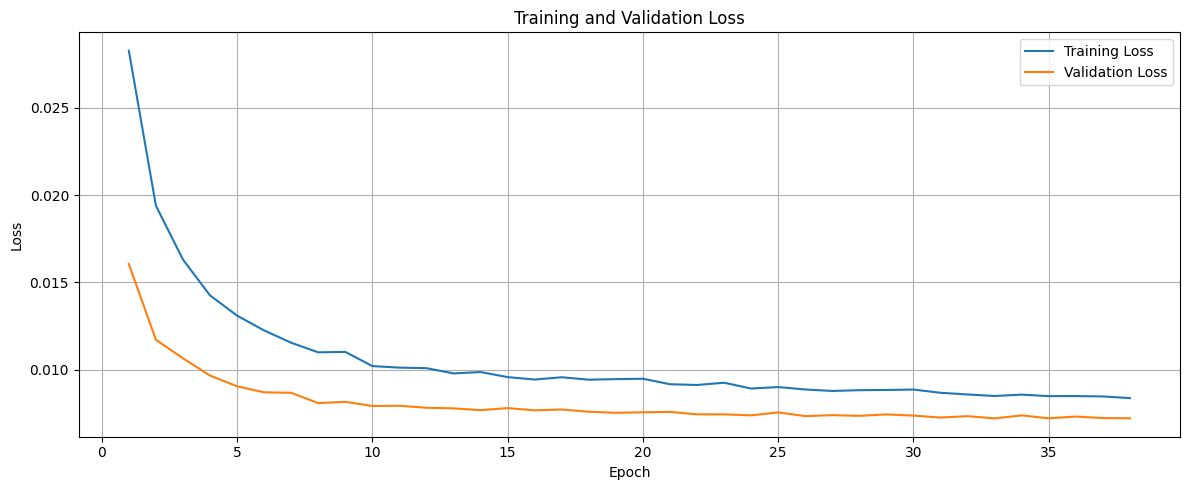

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.694393648064155
	mse = 34.3069620297465
	rmse = 5.857214528233237
	r2 = -1.0941725978780759
	mape = 0.24375168147518564
	mnbe = 8.809550366755877
	r_coeff = 0.5887420743884318
	p_value = 1.4333320832966224e-73
avg_mae = 4.694393648064155
avg_mse = 34.3069620297465
avg_rmse = 5.857214528233237
avg_r2 = -1.0941725978780759
avg_mape = 0.24375168147518564
avg_mnbe = 8.809550366755877
avg_r_coeff = 0.5887420743884318
avg_p_value = 1.4333320832966224e-73
CNNLSTMSeq2SeqReduction._prepare_data(): is called
CNNLSTMSeq2SeqReduction._define_model(): is called
CNNLSTMSeq2SeqReduction.execute(): is called
CNNLSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.2021 - val_loss: 0.1218
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1384 - val_loss: 0.0960
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1078 - val_loss: 0.0870
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0913 - val_loss: 0.0768
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0713 - val_loss: 0.0805
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0663 - val_loss: 0.0825
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0634 - val_loss: 0.0834
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0614 - val_loss: 0.0841
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0595 - val_loss: 0.0874
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


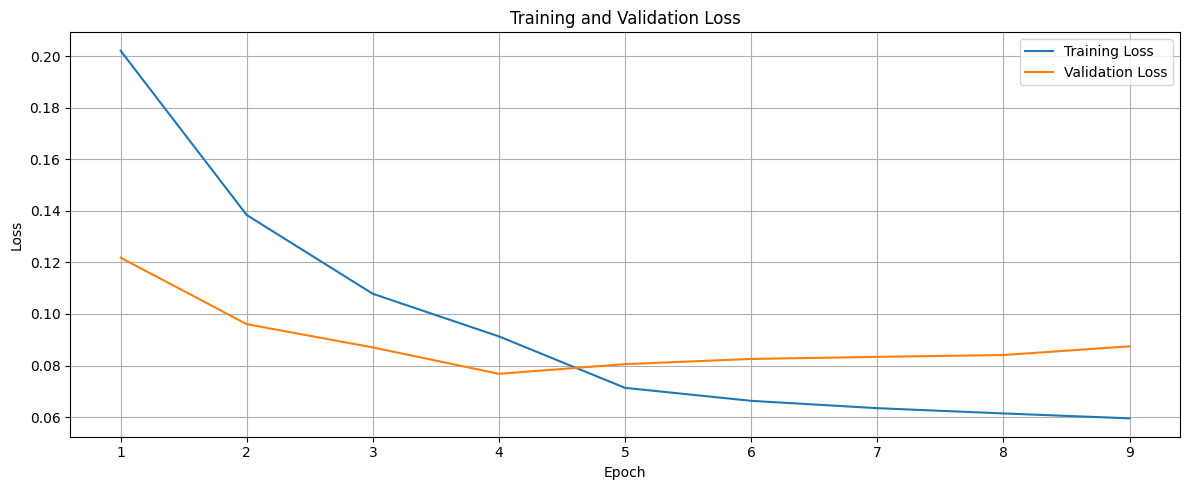

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0671
CNNLSTMSeq2SeqReduction.execute(): mae = 0.06708252429962158
CNNLSTMSeq2SeqReduction._define_encoder_model(): is called
CNNLSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_75      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 6, 128)    │      4,736 │ input_layer_75[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 3, 128)    │          0 │ conv1d_36[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 2, 64)     │     16,448 │ max_pooling1d_36… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 1, 64)     │          0 │ conv1d_37[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 64)        │          0 │ max_pooling1d_37… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_59    │ (None, 7, 64)     │          0 │ flatten_9[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_118 (LSTM)     │ (None, 7, 100)    │     66,000 │ repeat_vector_59… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_119 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_118[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 11)        │        561 │ lstm_119[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_60    │ (None, 7, 11)     │          0 │ dense_84[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_120 (LSTM)     │ (None, 7, 50)     │     12,400 │ repeat_vector_60… │
│                     │                   │            │ lstm_119[0][1],   │
│                     │                   │            │ lstm_119[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_121 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_120[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_59 │ (None, 7, 24)     │      2,424 │ lstm_121[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_60 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 580,859 (2.22 MB)

 Trainable params: 193,619 (756.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 387,240 (1.48 MB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_11_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_76 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 6, 128)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_59 (RepeatVector) │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_118 (LSTM)                 │ (None, 7, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_119 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,945 (460.72 KB)

 Trainable params: 117,945 (460.72 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_CNNLSTMSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_77      │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_122 (LSTM)     │ [(None, 64),      │     19,712 │ input_layer_77[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_61    │ (None, 1, 64)     │          0 │ lstm_122[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_123 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_61… │
│                     │                   │            │ lstm_122[0][1],   │
│                     │                   │            │ lstm_122[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 1, 64)     │          0 │ lstm_123[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_61 │ (None, 1, 1)      │         65 │ dropout_25[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0507 - val_loss: 0.0143
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0238 - val_loss: 0.0149
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0197 - val_loss: 0.0137
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0194 - val_loss: 0.0136
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0181 - val_loss: 0.0130
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0173 - val_loss: 0.0125
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0168 - val_loss: 0.0120
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0156 - val_loss: 0.0113
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0145 - val_loss: 0.0100
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127 - val_loss: 0.0091
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

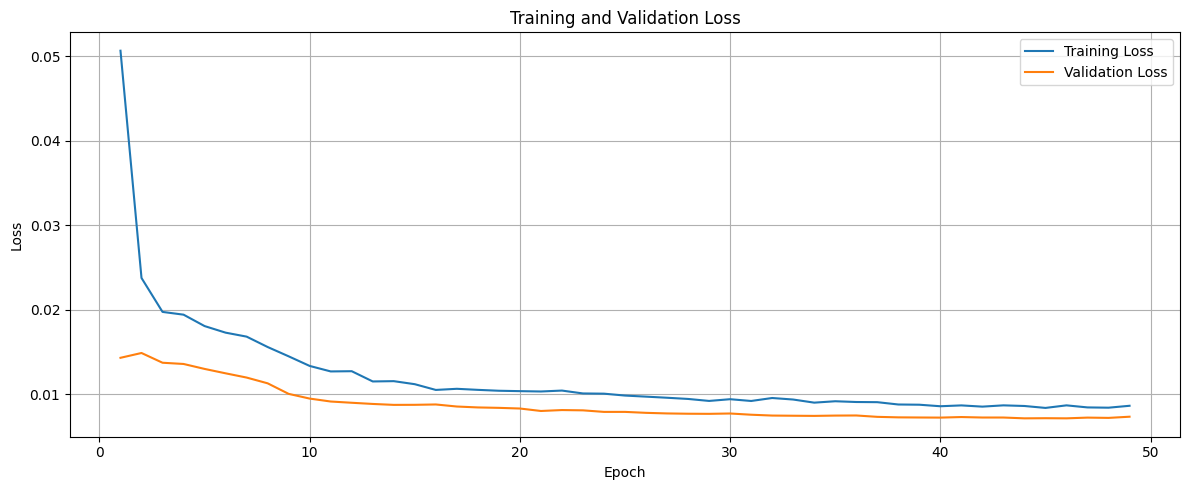

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.549618426142111
	mse = 32.74928403326082
	rmse = 5.722699016483466
	r2 = -1.1138064127654768
	mape = 0.24042150005114207
	mnbe = 6.9989029444133255
	r_coeff = 0.6008150149903675
	p_value = 2.5831073216136194e-77
avg_mae = 4.549618426142111
avg_mse = 32.74928403326082
avg_rmse = 5.722699016483466
avg_r2 = -1.1138064127654768
avg_mape = 0.24042150005114207
avg_mnbe = 6.9989029444133255
avg_r_coeff = 0.6008150149903675
avg_p_value = 2.5831073216136194e-77
CNNLSTMSeq2SeqReduction._prepare_data(): is called
CNNLSTMSeq2SeqReduction._define_model(): is called
CNNLSTMSeq2SeqReduction.execute(): is called
CNNLSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.2171 - val_loss: 0.1591
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1345 - val_loss: 0.1251
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0962 - val_loss: 0.1112
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0854 - val_loss: 0.0946
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0670 - val_loss: 0.0897
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0603 - val_loss: 0.0897
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0572 - val_loss: 0.0887
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0554 - val_loss: 0.0872
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0521 - val_loss: 0.0888
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0514 - val_loss: 0.0809
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0519 - val_loss: 0.0760
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

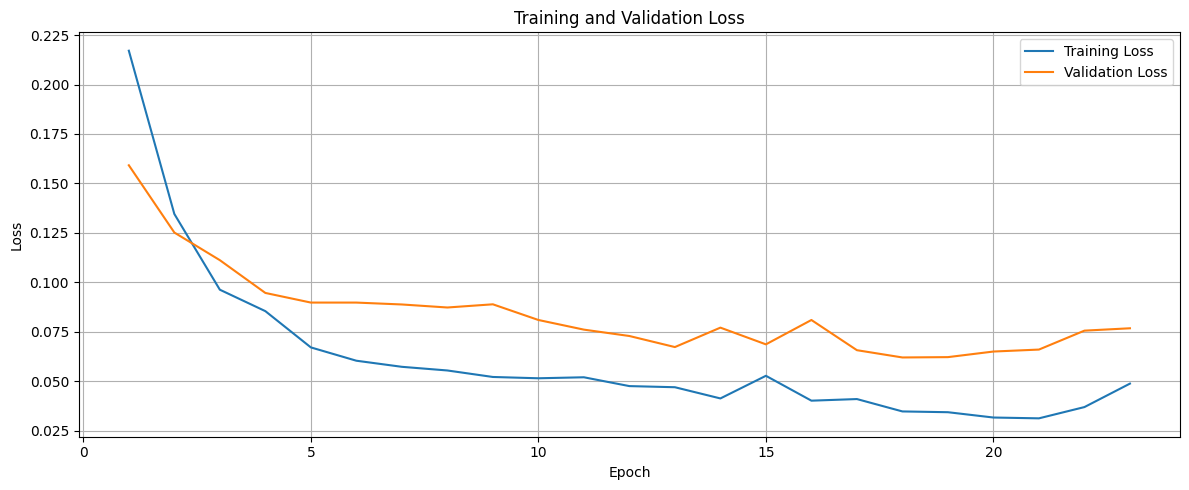

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0506
CNNLSTMSeq2SeqReduction.execute(): mae = 0.05064602568745613
CNNLSTMSeq2SeqReduction._define_encoder_model(): is called
CNNLSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_78      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 6, 128)    │      4,736 │ input_layer_78[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_40    │ (None, 3, 128)    │          0 │ conv1d_40[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 2, 64)     │     16,448 │ max_pooling1d_40… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_41    │ (None, 1, 64)     │          0 │ conv1d_41[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 64)        │          0 │ max_pooling1d_41… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_62    │ (None, 7, 64)     │          0 │ flatten_10[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_124 (LSTM)     │ (None, 7, 100)    │     66,000 │ repeat_vector_62… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_125 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_124[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 12)        │        612 │ lstm_125[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_63    │ (None, 7, 12)     │          0 │ dense_88[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_126 (LSTM)     │ (None, 7, 50)     │     12,600 │ repeat_vector_63… │
│                     │                   │            │ lstm_125[0][1],   │
│                     │                   │            │ lstm_125[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_127 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_126[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_62 │ (None, 7, 24)     │      2,424 │ lstm_127[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_63 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 581,612 (2.22 MB)

 Trainable params: 193,870 (757.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 387,742 (1.48 MB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_12_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_79 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 6, 128)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_62 (RepeatVector) │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_124 (LSTM)                 │ (None, 7, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_125 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,996 (460.92 KB)

 Trainable params: 117,996 (460.92 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_CNNLSTMSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_80      │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_128 (LSTM)     │ [(None, 64),      │     19,968 │ input_layer_80[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_64    │ (None, 1, 64)     │          0 │ lstm_128[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_129 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_64… │
│                     │                   │            │ lstm_128[0][1],   │
│                     │                   │            │ lstm_128[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 1, 64)     │          0 │ lstm_129[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_64 │ (None, 1, 1)      │         65 │ dropout_26[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1154 - val_loss: 0.0190
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0418 - val_loss: 0.0177
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0297 - val_loss: 0.0152
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0309 - val_loss: 0.0154
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0233 - val_loss: 0.0130
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0234 - val_loss: 0.0129
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0210 - val_loss: 0.0133
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0190 - val_loss: 0.0137
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0179 - val_loss: 0.0139
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0169 - val_loss: 0.0138
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0170 - val_loss: 0.0133
Epoch 11: early stopping
Restoring model weights fro

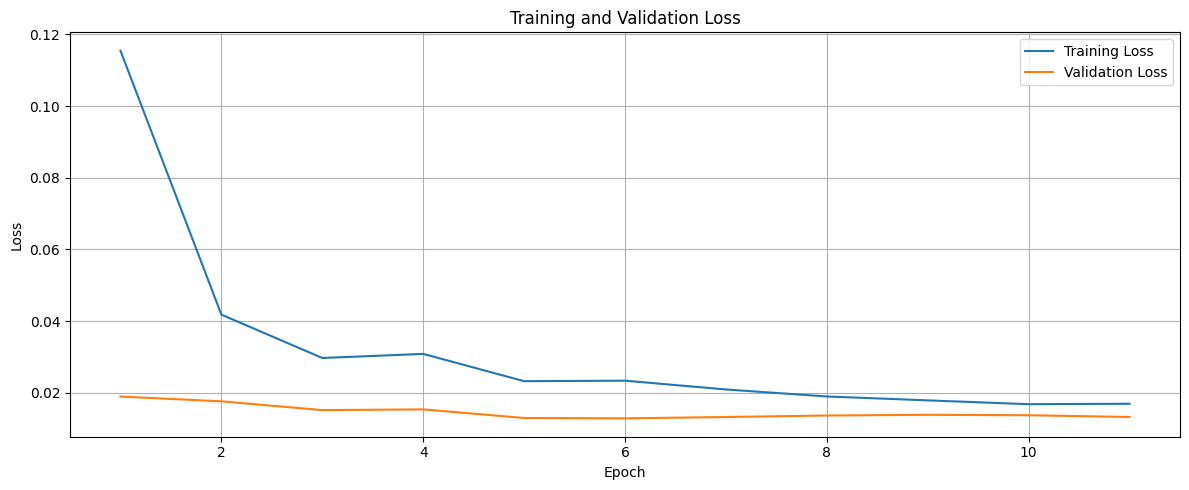

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 7.188837347024287
	mse = 67.98972415267104
	rmse = 8.245588162931195
	r2 = -209.63345897436014
	mape = 0.32136115541053123
	mnbe = 24.96629552333093
	r_coeff = 0.13338955172313383
	p_value = 0.000194174221584504
avg_mae = 7.188837347024287
avg_mse = 67.98972415267104
avg_rmse = 8.245588162931195
avg_r2 = -209.63345897436014
avg_mape = 0.32136115541053123
avg_mnbe = 24.96629552333093
avg_r_coeff = 0.13338955172313383
avg_p_value = 0.000194174221584504
CNNLSTMSeq2SeqReduction._prepare_data(): is called
CNNLSTMSeq2SeqReduction._define_model(): is called
CNNLSTMSeq2SeqReduction.execute(): is called
CNNLSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.1991 - val_loss: 0.1135
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1241 - val_loss: 0.0820
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0958 - val_loss: 0.0793
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0798 - val_loss: 0.0786
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0695 - val_loss: 0.0801
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0631 - val_loss: 0.0835
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0599 - val_loss: 0.0827
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0596 - val_loss: 0.0839
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0589 - val_loss: 0.0868
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


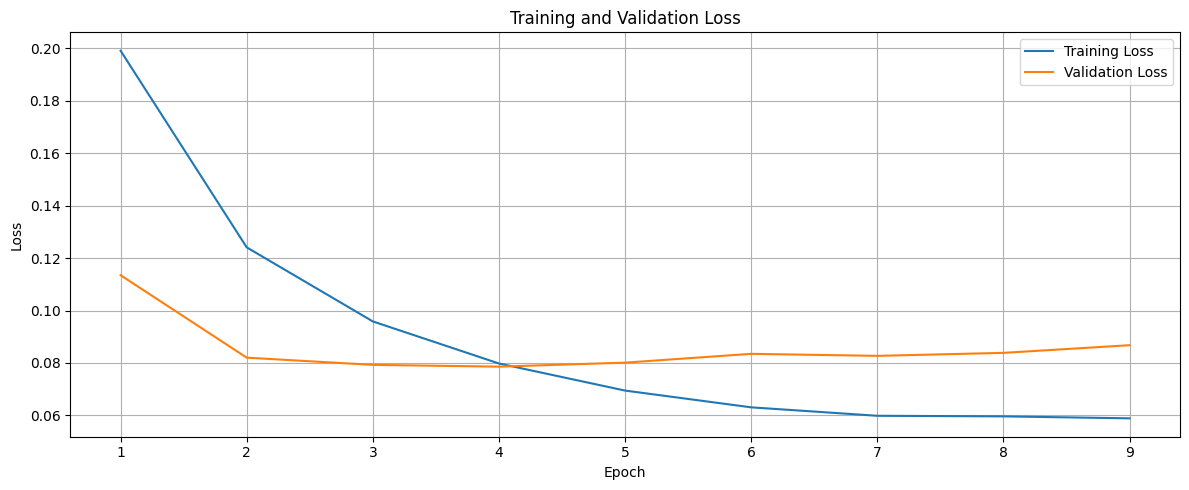

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0664
CNNLSTMSeq2SeqReduction.execute(): mae = 0.06643617153167725
CNNLSTMSeq2SeqReduction._define_encoder_model(): is called
CNNLSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_81      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 6, 128)    │      4,736 │ input_layer_81[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 3, 128)    │          0 │ conv1d_44[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 2, 64)     │     16,448 │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_45    │ (None, 1, 64)     │          0 │ conv1d_45[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 64)        │          0 │ max_pooling1d_45… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_65    │ (None, 7, 64)     │          0 │ flatten_11[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_130 (LSTM)     │ (None, 7, 100)    │     66,000 │ repeat_vector_65… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_131 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_130[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 13)        │        663 │ lstm_131[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_66    │ (None, 7, 13)     │          0 │ dense_92[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_132 (LSTM)     │ (None, 7, 50)     │     12,800 │ repeat_vector_66… │
│                     │                   │            │ lstm_131[0][1],   │
│                     │                   │            │ lstm_131[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_133 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_132[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_65 │ (None, 7, 24)     │      2,424 │ lstm_133[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_66 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 582,365 (2.22 MB)

 Trainable params: 194,121 (758.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 388,244 (1.48 MB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_82 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 6, 128)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_45 (MaxPooling1D) │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_65 (RepeatVector) │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_130 (LSTM)                 │ (None, 7, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_131 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,047 (461.12 KB)

 Trainable params: 118,047 (461.12 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_CNNLSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_83      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_134 (LSTM)     │ [(None, 64),      │     20,224 │ input_layer_83[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_67    │ (None, 1, 64)     │          0 │ lstm_134[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_135 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_67… │
│                     │                   │            │ lstm_134[0][1],   │
│                     │                   │            │ lstm_134[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 1, 64)     │          0 │ lstm_135[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_67 │ (None, 1, 1)      │         65 │ dropout_27[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0281 - val_loss: 0.0176
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0208 - val_loss: 0.0151
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0189 - val_loss: 0.0133
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0170 - val_loss: 0.0122
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0159 - val_loss: 0.0113
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0148 - val_loss: 0.0107
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0134 - val_loss: 0.0099
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0128 - val_loss: 0.0097
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - val_loss: 0.0092
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0112 - val_loss: 0.0090
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113 - val_loss: 0.0089
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

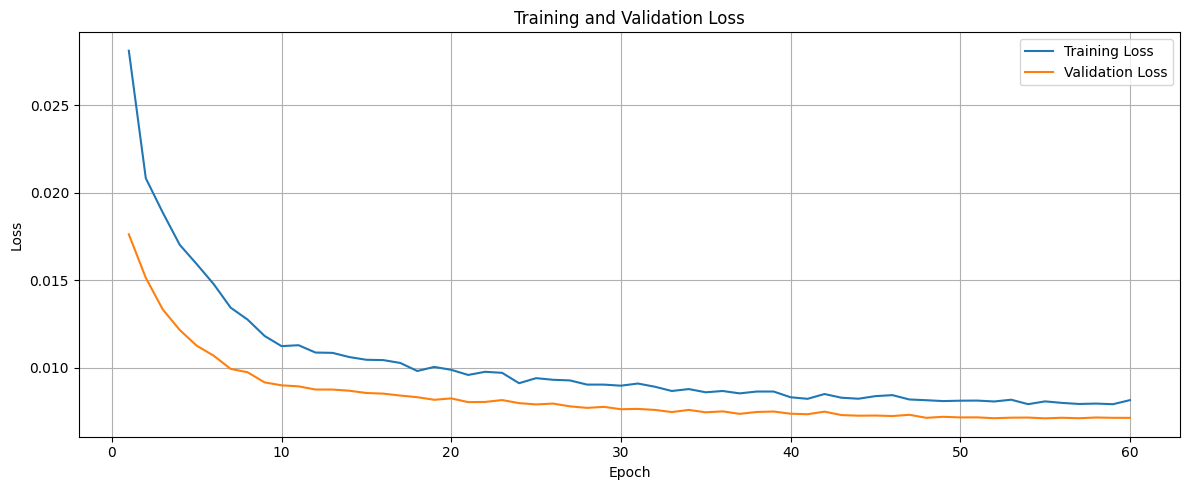

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.298904446739571
	mse = 30.98879523060644
	rmse = 5.566758053895143
	r2 = -0.5127096670641194
	mape = 0.23093857777433252
	mnbe = 5.50575938099266
	r_coeff = 0.6199132960837827
	p_value = 1.4194413717580277e-83
avg_mae = 4.298904446739571
avg_mse = 30.98879523060644
avg_rmse = 5.566758053895143
avg_r2 = -0.5127096670641194
avg_mape = 0.23093857777433252
avg_mnbe = 5.50575938099266
avg_r_coeff = 0.6199132960837827
avg_p_value = 1.4194413717580277e-83
CNNLSTMSeq2SeqReduction._prepare_data(): is called
CNNLSTMSeq2SeqReduction._define_model(): is called
CNNLSTMSeq2SeqReduction.execute(): is called
CNNLSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.2070 - val_loss: 0.1415
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1507 - val_loss: 0.1127
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1115 - val_loss: 0.0921
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0855 - val_loss: 0.0835
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0705 - val_loss: 0.0809
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0615 - val_loss: 0.0809
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0635 - val_loss: 0.0851
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0601 - val_loss: 0.0839
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0655 - val_loss: 0.0817
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0580 - val_loss: 0.0839
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


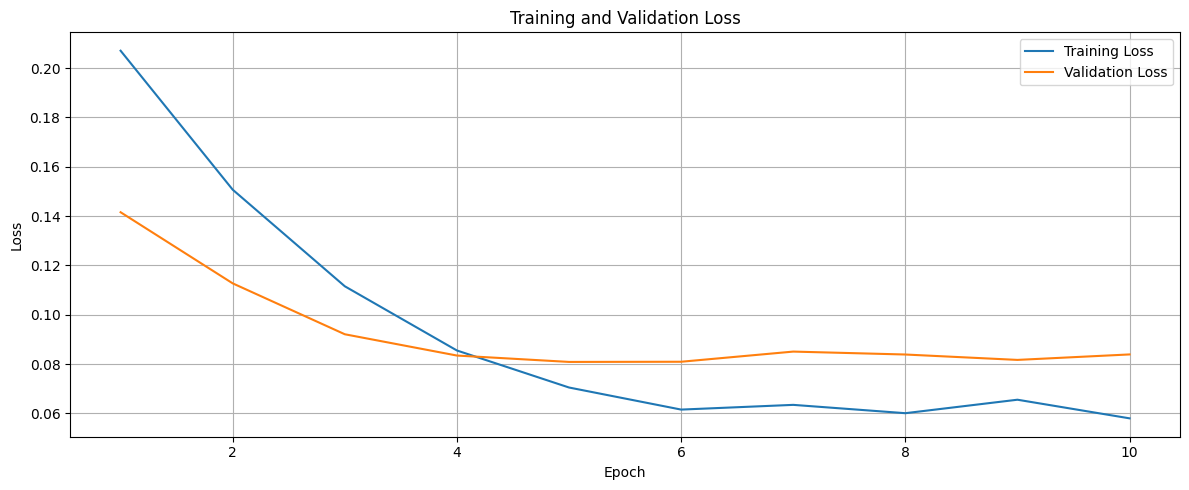

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0696
CNNLSTMSeq2SeqReduction.execute(): mae = 0.06956713646650314
CNNLSTMSeq2SeqReduction._define_encoder_model(): is called
CNNLSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_84      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 6, 128)    │      4,736 │ input_layer_84[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_48    │ (None, 3, 128)    │          0 │ conv1d_48[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 2, 64)     │     16,448 │ max_pooling1d_48… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_49    │ (None, 1, 64)     │          0 │ conv1d_49[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 64)        │          0 │ max_pooling1d_49… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_68    │ (None, 7, 64)     │          0 │ flatten_12[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_136 (LSTM)     │ (None, 7, 100)    │     66,000 │ repeat_vector_68… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_137 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_136[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 14)        │        714 │ lstm_137[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_69    │ (None, 7, 14)     │          0 │ dense_96[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_138 (LSTM)     │ (None, 7, 50)     │     13,000 │ repeat_vector_69… │
│                     │                   │            │ lstm_137[0][1],   │
│                     │                   │            │ lstm_137[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_139 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_138[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_68 │ (None, 7, 24)     │      2,424 │ lstm_139[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_69 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 583,118 (2.22 MB)

 Trainable params: 194,372 (759.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 388,746 (1.48 MB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_85 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 6, 128)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_48 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_49 (MaxPooling1D) │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_68 (RepeatVector) │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_136 (LSTM)                 │ (None, 7, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_137 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,098 (461.32 KB)

 Trainable params: 118,098 (461.32 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_CNNLSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_86      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_140 (LSTM)     │ [(None, 64),      │     20,480 │ input_layer_86[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_70    │ (None, 1, 64)     │          0 │ lstm_140[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_141 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_70… │
│                     │                   │            │ lstm_140[0][1],   │
│                     │                   │            │ lstm_140[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 1, 64)     │          0 │ lstm_141[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_70 │ (None, 1, 1)      │         65 │ dropout_28[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0281 - val_loss: 0.0156
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0217 - val_loss: 0.0143
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0191 - val_loss: 0.0134
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0164 - val_loss: 0.0130
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0153 - val_loss: 0.0127
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0141 - val_loss: 0.0116
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0131 - val_loss: 0.0109
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0126 - val_loss: 0.0098
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0120 - val_loss: 0.0093
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - val_loss: 0.0093
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110 - val_loss: 0.0089
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

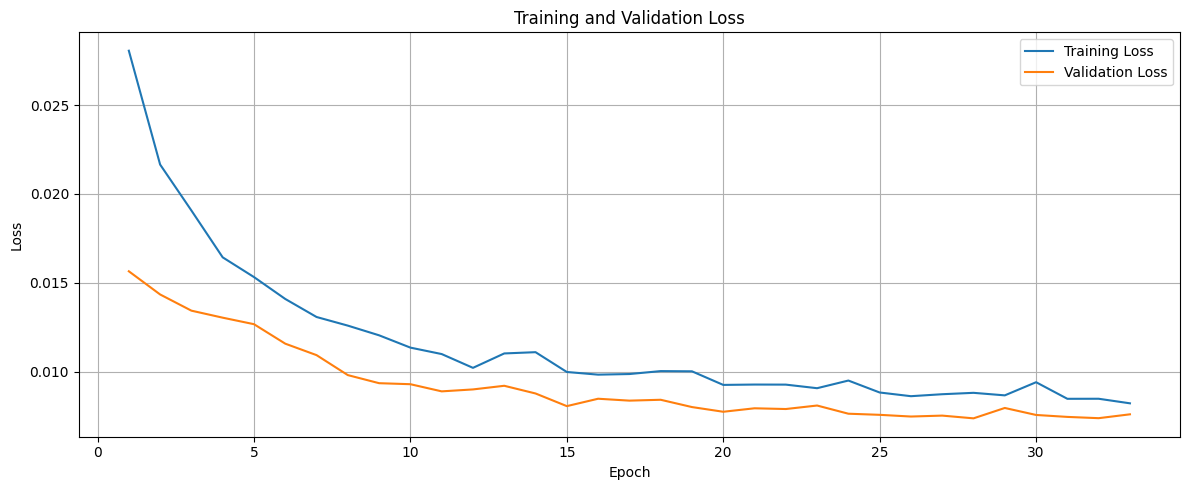

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.680417810295275
	mse = 33.523793651952076
	rmse = 5.789973545013144
	r2 = -1.644107907551077
	mape = 0.24653659820774446
	mnbe = 7.490490134879829
	r_coeff = 0.596540163338461
	p_value = 5.70299577941176e-76
avg_mae = 4.680417810295275
avg_mse = 33.523793651952076
avg_rmse = 5.789973545013144
avg_r2 = -1.644107907551077
avg_mape = 0.24653659820774446
avg_mnbe = 7.490490134879829
avg_r_coeff = 0.596540163338461
avg_p_value = 5.70299577941176e-76
CNNLSTMSeq2SeqReduction._prepare_data(): is called
CNNLSTMSeq2SeqReduction._define_model(): is called
CNNLSTMSeq2SeqReduction.execute(): is called
CNNLSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.2032 - val_loss: 0.1419
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1439 - val_loss: 0.1208
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1024 - val_loss: 0.0969
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0685 - val_loss: 0.0807
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0609 - val_loss: 0.0778
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0614 - val_loss: 0.0809
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0577 - val_loss: 0.0739
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0531 - val_loss: 0.0708
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0536 - val_loss: 0.0737
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0519 - val_loss: 0.0701
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0618 - val_loss: 0.0694
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/ste

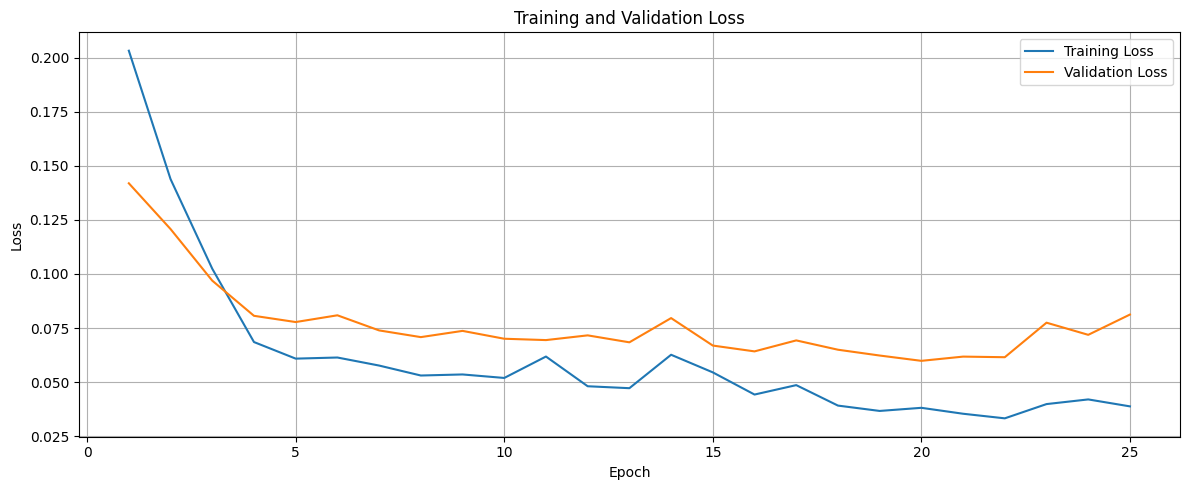

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0513
CNNLSTMSeq2SeqReduction.execute(): mae = 0.051268186420202255
CNNLSTMSeq2SeqReduction._define_encoder_model(): is called
CNNLSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_87      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 6, 128)    │      4,736 │ input_layer_87[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_52    │ (None, 3, 128)    │          0 │ conv1d_52[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 2, 64)     │     16,448 │ max_pooling1d_52… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_53    │ (None, 1, 64)     │          0 │ conv1d_53[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 64)        │          0 │ max_pooling1d_53… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_71    │ (None, 7, 64)     │          0 │ flatten_13[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_142 (LSTM)     │ (None, 7, 100)    │     66,000 │ repeat_vector_71… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_143 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_142[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 15)        │        765 │ lstm_143[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_72    │ (None, 7, 15)     │          0 │ dense_100[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_144 (LSTM)     │ (None, 7, 50)     │     13,200 │ repeat_vector_72… │
│                     │                   │            │ lstm_143[0][1],   │
│                     │                   │            │ lstm_143[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_145 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_144[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_71 │ (None, 7, 24)     │      2,424 │ lstm_145[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_72 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 583,871 (2.23 MB)

 Trainable params: 194,623 (760.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 389,248 (1.48 MB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_88 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 6, 128)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_52 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_53 (MaxPooling1D) │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_71 (RepeatVector) │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_142 (LSTM)                 │ (None, 7, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_143 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,149 (461.52 KB)

 Trainable params: 118,149 (461.52 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_CNNLSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_89      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_146 (LSTM)     │ [(None, 64),      │     20,736 │ input_layer_89[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_73    │ (None, 1, 64)     │          0 │ lstm_146[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_147 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_73… │
│                     │                   │            │ lstm_146[0][1],   │
│                     │                   │            │ lstm_146[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 1, 64)     │          0 │ lstm_147[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_73 │ (None, 1, 1)      │         65 │ dropout_29[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0673 - val_loss: 0.0237
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0230 - val_loss: 0.0131
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0194 - val_loss: 0.0116
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0187 - val_loss: 0.0117
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0161 - val_loss: 0.0109
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0152 - val_loss: 0.0106
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0144 - val_loss: 0.0103
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0145 - val_loss: 0.0099
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0141 - val_loss: 0.0097
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0140 - val_loss: 0.0097
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137 - val_loss: 0.0096
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

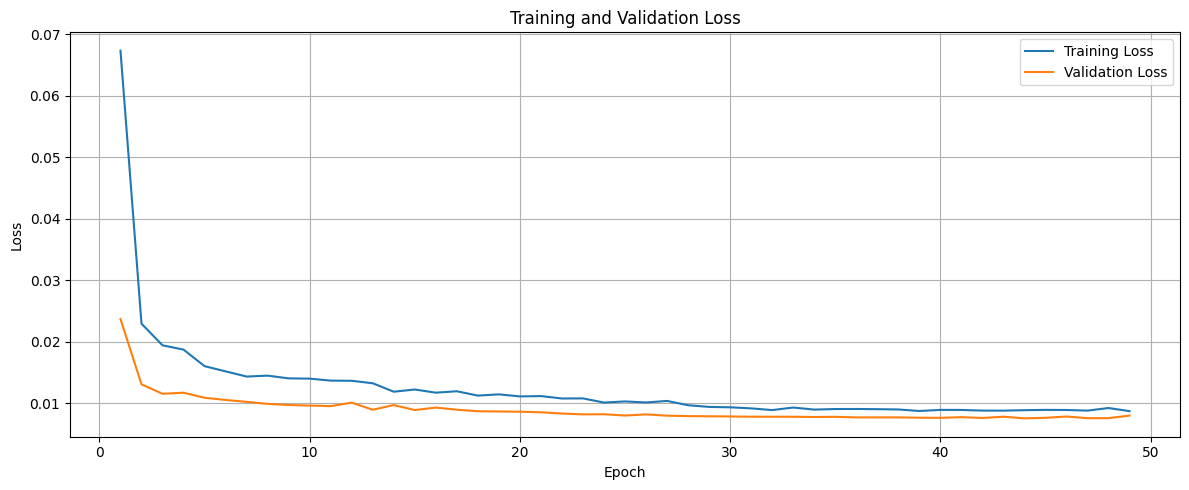

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 4.738848808652391
	mse = 34.73865241307693
	rmse = 5.893950492927212
	r2 = -2.201154962101319
	mape = 0.24985874072254177
	mnbe = 6.924618120080026
	r_coeff = 0.5729253152383709
	p_value = 6.748554193905766e-69
avg_mae = 4.738848808652391
avg_mse = 34.73865241307693
avg_rmse = 5.893950492927212
avg_r2 = -2.201154962101319
avg_mape = 0.24985874072254177
avg_mnbe = 6.924618120080026
avg_r_coeff = 0.5729253152383709
avg_p_value = 6.748554193905766e-69
CNNLSTMSeq2SeqReduction._prepare_data(): is called
CNNLSTMSeq2SeqReduction._define_model(): is called
CNNLSTMSeq2SeqReduction.execute(): is called
CNNLSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.2131 - val_loss: 0.1541
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1413 - val_loss: 0.1195
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0859 - val_loss: 0.0940
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0711 - val_loss: 0.0862
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0616 - val_loss: 0.0830
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0599 - val_loss: 0.0830
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0533 - val_loss: 0.0776
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0559 - val_loss: 0.0789
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0683 - val_loss: 0.0802
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0642 - val_loss: 0.0768
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0520 - val_loss: 0.0789
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

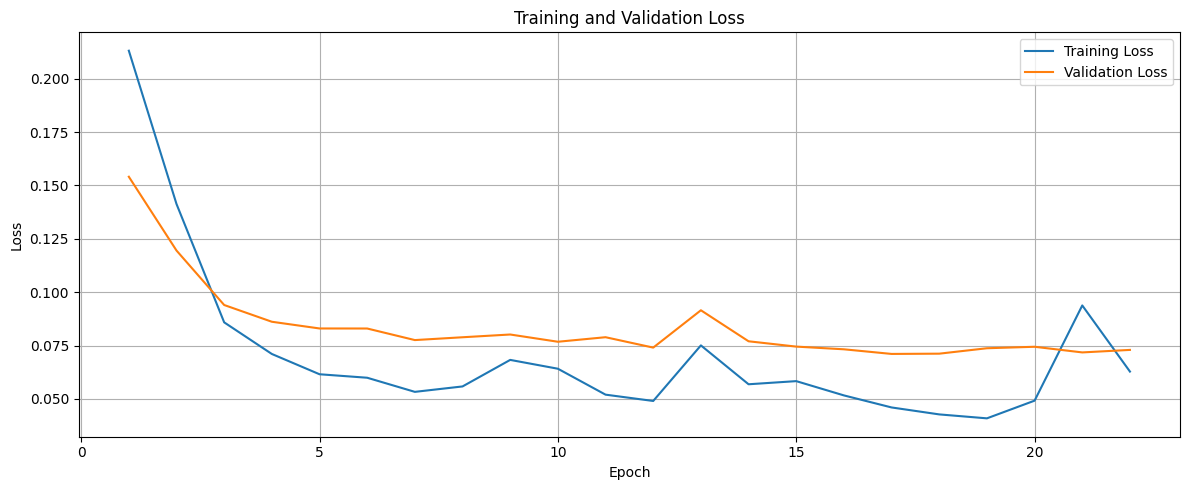

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0567
CNNLSTMSeq2SeqReduction.execute(): mae = 0.056691624224185944
CNNLSTMSeq2SeqReduction._define_encoder_model(): is called
CNNLSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_90      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 6, 128)    │      4,736 │ input_layer_90[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_56    │ (None, 3, 128)    │          0 │ conv1d_56[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 2, 64)     │     16,448 │ max_pooling1d_56… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_57    │ (None, 1, 64)     │          0 │ conv1d_57[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 64)        │          0 │ max_pooling1d_57… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_74    │ (None, 7, 64)     │          0 │ flatten_14[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_148 (LSTM)     │ (None, 7, 100)    │     66,000 │ repeat_vector_74… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_149 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_148[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 16)        │        816 │ lstm_149[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_75    │ (None, 7, 16)     │          0 │ dense_104[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_150 (LSTM)     │ (None, 7, 50)     │     13,400 │ repeat_vector_75… │
│                     │                   │            │ lstm_149[0][1],   │
│                     │                   │            │ lstm_149[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_151 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_150[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_74 │ (None, 7, 24)     │      2,424 │ lstm_151[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_75 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 584,624 (2.23 MB)

 Trainable params: 194,874 (761.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 389,750 (1.49 MB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_91 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_56 (Conv1D)              │ (None, 6, 128)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_56 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_57 (Conv1D)              │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_57 (MaxPooling1D) │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_74 (RepeatVector) │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_148 (LSTM)                 │ (None, 7, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_149 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,200 (461.72 KB)

 Trainable params: 118,200 (461.72 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_CNNLSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_92      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_152 (LSTM)     │ [(None, 64),      │     20,992 │ input_layer_92[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_76    │ (None, 1, 64)     │          0 │ lstm_152[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_153 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_76… │
│                     │                   │            │ lstm_152[0][1],   │
│                     │                   │            │ lstm_152[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 1, 64)     │          0 │ lstm_153[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_76 │ (None, 1, 1)      │         65 │ dropout_30[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,081 (211.25 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2306 - val_loss: 0.0463
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0563 - val_loss: 0.0155
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0268 - val_loss: 0.0140
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0213 - val_loss: 0.0123
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0206 - val_loss: 0.0122
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0186 - val_loss: 0.0119
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0189 - val_loss: 0.0118
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0180 - val_loss: 0.0116
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0165 - val_loss: 0.0105
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0177 - val_loss: 0.0122
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0153 - val_loss: 0.0110
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

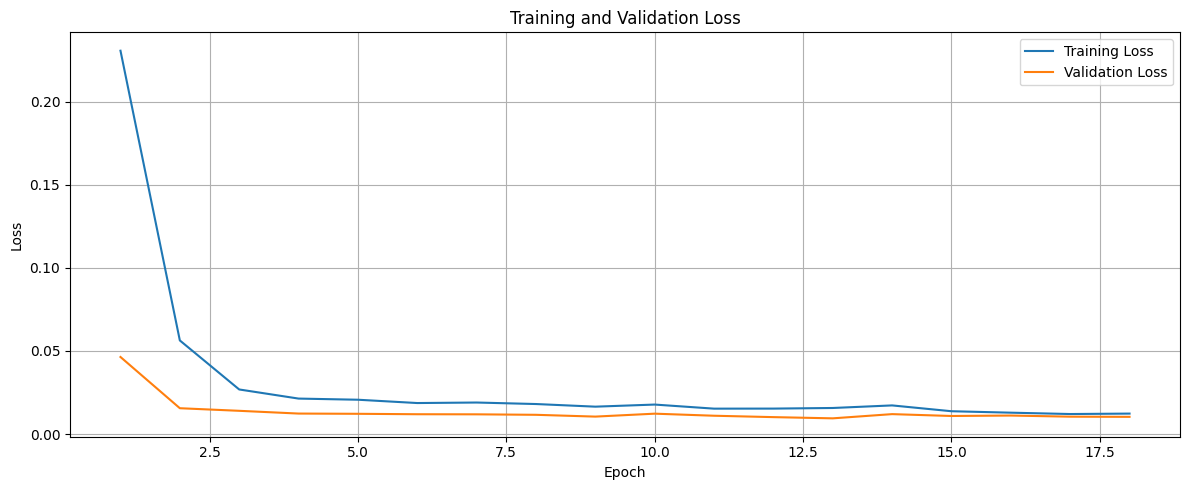

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 5.671564134700677
	mse = 44.37701763695199
	rmse = 6.661607736646761
	r2 = -13.56756289528456
	mape = 0.28121717578814526
	mnbe = 13.569435441112132
	r_coeff = 0.5449149563889695
	p_value = 3.21868624063408e-61
avg_mae = 5.671564134700677
avg_mse = 44.37701763695199
avg_rmse = 6.661607736646761
avg_r2 = -13.56756289528456
avg_mape = 0.28121717578814526
avg_mnbe = 13.569435441112132
avg_r_coeff = 0.5449149563889695
avg_p_value = 3.21868624063408e-61
CNNLSTMSeq2SeqReduction._prepare_data(): is called
CNNLSTMSeq2SeqReduction._define_model(): is called
CNNLSTMSeq2SeqReduction.execute(): is called
CNNLSTMSeq2SeqReduction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.2319 - val_loss: 0.1671
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.1882 - val_loss: 0.1178
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1423 - val_loss: 0.0918
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1036 - val_loss: 0.0803
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0770 - val_loss: 0.0795
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0682 - val_loss: 0.0819
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0575 - val_loss: 0.0754
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0514 - val_loss: 0.0723
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0497 - val_loss: 0.0716
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0436 - val_loss: 0.0692
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0420 - val_loss: 0.0666
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

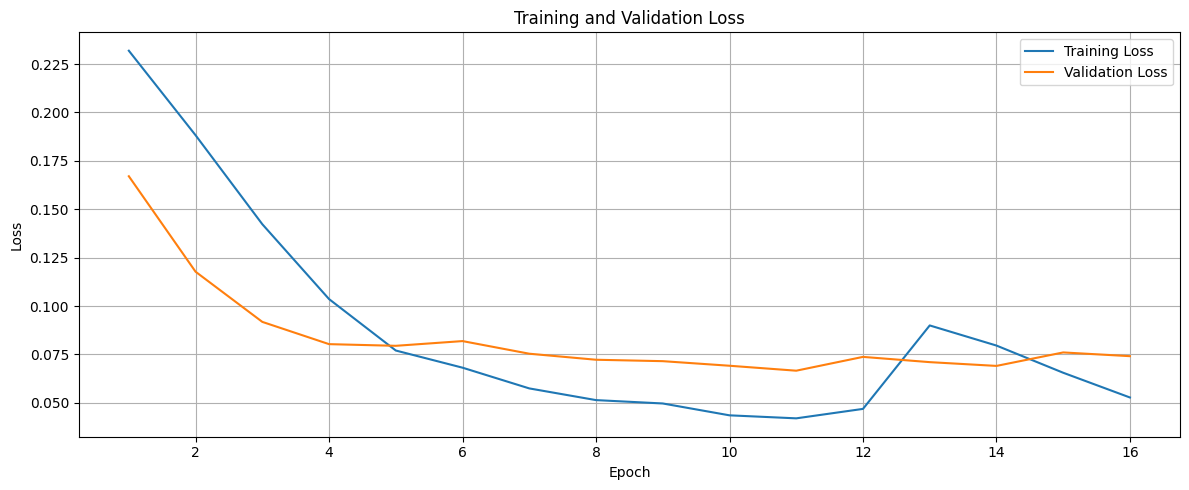

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0561
CNNLSTMSeq2SeqReduction.execute(): mae = 0.05611759424209595
CNNLSTMSeq2SeqReduction._define_encoder_model(): is called
CNNLSTMSeq2SeqReduction._encode_data(): is called
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_93      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 6, 128)    │      4,736 │ input_layer_93[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_60    │ (None, 3, 128)    │          0 │ conv1d_60[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 2, 64)     │     16,448 │ max_pooling1d_60… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_61    │ (None, 1, 64)     │          0 │ conv1d_61[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 64)        │          0 │ max_pooling1d_61… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_77    │ (None, 7, 64)     │          0 │ flatten_15[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_154 (LSTM)     │ (None, 7, 100)    │     66,000 │ repeat_vector_77… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_155 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_154[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_108 (Dense)   │ (None, 17)        │        867 │ lstm_155[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_78    │ (None, 7, 17)     │          0 │ dense_108[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_156 (LSTM)     │ (None, 7, 50)     │     13,600 │ repeat_vector_78… │
│                     │                   │            │ lstm_155[0][1],   │
│                     │                   │            │ lstm_155[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_157 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_156[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_77 │ (None, 7, 24)     │      2,424 │ lstm_157[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_78 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 585,377 (2.23 MB)

 Trainable params: 195,125 (762.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 390,252 (1.49 MB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_1_future_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_94 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_60 (Conv1D)              │ (None, 6, 128)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_60 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_61 (Conv1D)              │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_61 (MaxPooling1D) │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_77 (RepeatVector) │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_154 (LSTM)                 │ (None, 7, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_155 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,251 (461.92 KB)

 Trainable params: 118,251 (461.92 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction._prepare_data(): is called


Model: "aod_LSTMPrediction_1_future_with_CNNLSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_95      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_158 (LSTM)     │ [(None, 64),      │     21,248 │ input_layer_95[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_79    │ (None, 1, 64)     │          0 │ lstm_158[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_159 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_79… │
│                     │                   │            │ lstm_158[0][1],   │
│                     │                   │            │ lstm_158[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 1, 64)     │          0 │ lstm_159[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_79 │ (None, 1, 1)      │         65 │ dropout_31[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,337 (212.25 KB)

 Trainable params: 54,337 (212.25 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTMPrediction.execute(): is called
LSTMPrediction._train_model(): is called


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0682 - val_loss: 0.0204
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0382 - val_loss: 0.0154
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0272 - val_loss: 0.0182
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0233 - val_loss: 0.0158
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0222 - val_loss: 0.0151
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0205 - val_loss: 0.0148
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0193 - val_loss: 0.0146
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0183 - val_loss: 0.0144
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0171 - val_loss: 0.0140
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0172 - val_loss: 0.0138
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0167 - val_loss: 0.0135
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

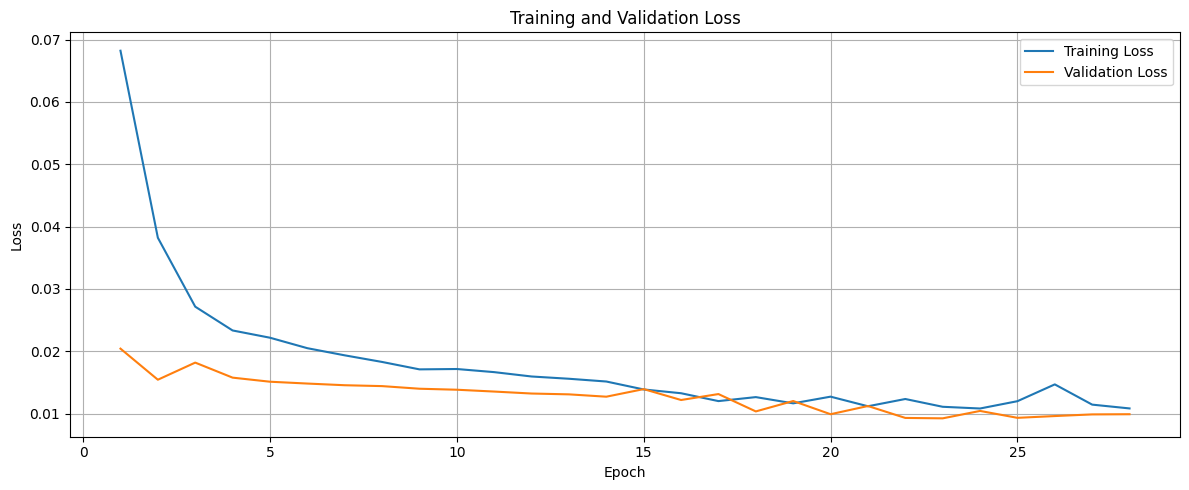

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
y_pred.shape = (776, 1, 1)
y_test.shape = (776, 1, 1)
Initialize metrics = {'mae': [], 'mse': [], 'rmse': [], 'r2': [], 'mape': [], 'mnbe': [], 'r_coeff': [], 'p_value': []}
inv_y_pred.shape = (776, 1), inv_y_test.shape = (776, 1)
Day 1:
	mae = 5.967156682083284
	mse = 48.67401460839327
	rmse = 6.976676472962844
	r2 = -8.385004493635313
	mape = 0.2846258970702951
	mnbe = 18.042502228151644
	r_coeff = 0.4928232485301845
	p_value = 1.002123365166804e-48
avg_mae = 5.967156682083284
avg_mse = 48.67401460839327
avg_rmse = 6.976676472962844
avg_r2 = -8.385004493635313
avg_mape = 0.2846258970702951
avg_mnbe = 18.042502228151644
avg_r_coeff = 0.4928232485301845
avg_p_value = 1.002123365166804e-48
Choosing the best result

dict_keys([10, 11, 12, 13, 14, 15, 16, 17])
N = 10
mae = 4.694393648064155
mse = 34.3069620297465
rmse = 5.857214528233237
r2 = -1.0941725978780759
mape = 0.24375168147518564
mnbe = 8.809550366755877
r_coeff = 0.5887420743884318
p_value

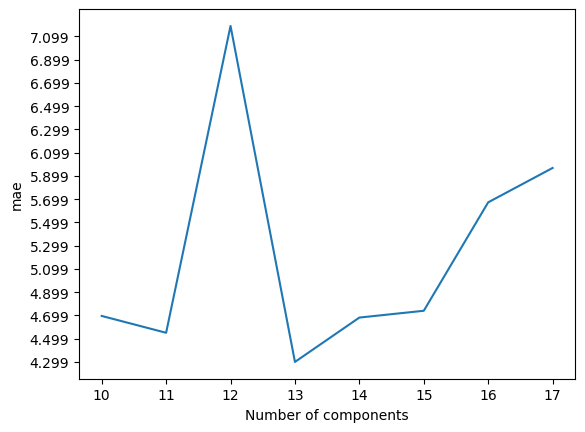

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


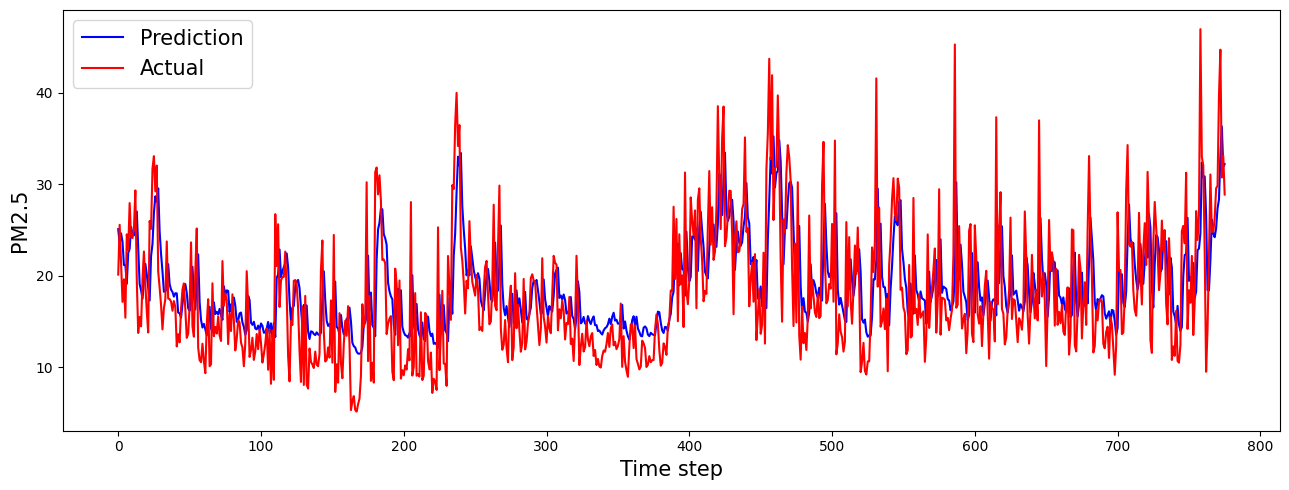

dim_reduction_method  dim_after_reduction prediction  n_future       mae  \
0         LSTM-Seq2Seq                   10       LSTM         1  4.266625   
1          GRU-Seq2Seq                   17       LSTM         1  4.098607   
2      CNNLSTM-Seq2Seq                   13       LSTM         1  4.543967   
3      CNNLSTM-Seq2Seq                   13       LSTM         1  4.298904   

         mse      rmse        r2      mape      mnbe   r_coeff       p_value  
0  30.222570  5.497506 -0.913026  0.232827  3.635919  0.625307  2.018159e-85  
1  29.835779  5.462214 -0.357493  0.227923  1.842780  0.625704  1.470963e-85  
2  32.872352  5.733442 -1.714669  0.243149  5.367097  0.594016  3.470124e-75  
3  30.988795  5.566758 -0.512710  0.230939  5.505759  0.619913  1.419441e-83

In [53]:
# Loop every n_future
cnnlstms2s_n_future_mapper = {}

for prediction_n_future in range_of_n_future:
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    loopresults = generate_loopresults(X_aod_scaled, y_aod_scaled,
                                       aod_label_scaler,
                                       range_of_dimension,
                                       CNNLSTMSeq2SeqReduction,
                                       LSTMPrediction,
                                       "aod", "aod",
                                       reduction_n_past, reduction_n_future,
                                       reduction_epochs, reduction_batch_size,
                                       prediction_n_past, prediction_n_future,
                                       prediction_epochs, prediction_batch_size,
                                       saved_model_weight_dir, saved_model_plot_dir)
    best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path = choose_the_best(loopresults, "mae", prediction_n_future)
    
    # Update the evaluation board
    evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
    evaluation_board['dim_after_reduction'] += [best_num_of_components]
    evaluation_board['n_future'] += [prediction_n_future]
    evaluation_board['prediction'] += ["LSTM"]
    for metric, value in best_metrics.items():
        evaluation_board[metric] += [value]
    display(pd.DataFrame(evaluation_board))

    # Update n_future mapper
    cnnlstms2s_n_future_mapper[prediction_n_future] = (best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path)

#### Prepare reduced data

In [54]:
# Create the mapper for inference data
cnnlstms2s_n_future_inference_mapper = {}

# Loop over n_future mapper
for prediction_n_future, (best_encoded_data, _, best_encoder_model_path, best_prediction_model_path) in cnnlstms2s_n_future_mapper.items():
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    
    # Copy the best reduction model to target directory
    shutil.copy(best_encoder_model_path, conf["workspace"]["best_model_weight_dir"])
    shutil.copy(best_prediction_model_path, conf["workspace"]["best_model_weight_dir"])
    
    # Inference LSTM
    pred_pm25_from_df_cnnlstms2s_reduced = inferenceLSTM(best_encoded_data, y_aod_scaled,
                                                        prediction_n_past, prediction_n_future,
                                                        best_prediction_model_path, verbose=1)
    inv_pred_pm25_from_df_cnnlstms2s_reduced = aod_label_scaler.inverse_transform(np.squeeze(pred_pm25_from_df_cnnlstms2s_reduced, axis=-1))
    print(inv_pred_pm25_from_df_cnnlstms2s_reduced.shape)
    
    # Prepare the reduced data
    df_cnnlstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices,
                                            (aod_station_column, "station"),
                                            *[(inv_pred_pm25_from_df_cnnlstms2s_reduced[:, day], f"predicted_pm25_day_{day+1}") for day in range(inv_pred_pm25_from_df_cnnlstms2s_reduced.shape[-1])],
                                            (aod_pm25_3km_column, "pm25_3km"))
    df_cnnlstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data_dir"], f"df_cnnlstms2s_reduced_2018_2022_{prediction_n_future}_day.csv"))
    df_cnnlstms2s_reduced.to_csv(os.path.join(conf["workspace"]["data_to_store_in_hdfs_dir"], f"vientham_2018_2022_reduced_with_cnnlstms2s_{prediction_n_future}_day.csv"))
    display(df_cnnlstms2s_reduced)

    # Update the n_future inference mapper
    cnnlstms2s_n_future_inference_mapper[prediction_n_future] = df_cnnlstms2s_reduced



PREDICTION WITH N_FUTURE = 1

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(3889, 1)


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01      -1.201787      -0.010155       0.001618       0.085037   
2018-01-02      -1.201787      -0.010155       0.001618       0.085037   
2018-01-03      -1.234212      -0.013124       0.001355       0.072290   
2018-01-04      -1.284466      -0.018318       0.005276       0.054581   
2018-01-05      -1.377530      -0.026719       0.014142       0.028836   
...                   ...            ...            ...            ...   
2022-12-27      -1.368882      -0.037026       0.037784       0.021152   
2022-12-28      -1.349043      -0.033707       0.041329       0.033109   
2022-12-29      -1.320779      -0.030002       0.049022       0.044319   
2022-12-30      -1.320049      -0.026429       0.051113       0.042680   
2022-12-31      -1.351241      -0.031611       0.051150       0.030938   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       1.728575      -0.448027      -0.420470      -0.593749   
2018-01-02       1.728575      -0.448027      -0.420470      -0.593749   
2018-01-03       1.763028      -0.449737      -0.438882      -0.609845   
2018-01-04       1.814093      -0.454201      -0.467955      -0.637330   
2018-01-05       1.903477      -0.461411      -0.519938      -0.678500   
...                   ...            ...            ...            ...   
2022-12-27       1.880723      -0.464605      -0.553326      -0.631777   
2022-12-28       1.861761      -0.464248      -0.540296      -0.624034   
2022-12-29       1.830764      -0.465874      -0.522766      -0.612093   
2022-12-30       1.833935      -0.468419      -0.525586      -0.614243   
2022-12-31       1.866505      -0.467073      -0.542491      -0.627462   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.208132       -0.357889        0.588815       -1.695203   
2018-01-02       0.208132       -0.357889        0.588815       -1.695203   
2018-01-03       0.209636       -0.366418        0.606104       -1.716892   
2018-01-04       0.212867       -0.383455        0.630740       -1.750151   
2018-01-05       0.217106       -0.408086        0.676587       -1.812255   
...                   ...             ...             ...             ...   
2022-12-27       0.229066       -0.333143        0.698559       -1.785369   
2022-12-28       0.232551       -0.331700        0.686151       -1.773439   
2022-12-29       0.229488       -0.329217        0.670780       -1.752415   
2022-12-30       0.231231       -0.332998        0.674254       -1.750860   
2022-12-31       0.231684       -0.340051        0.690065       -1.772769   

            aod_feature_13  station  predicted_pm25_day_1   pm25_3km  
time                                                                  
2018-01-01       -0.457854      201             30.700352  34.919998  
2018-01-02       -0.457854      201             30.700352  51.830002  
2018-01-03       -0.469769      201             33.276154  38.240002  
2018-01-04       -0.487313      201             43.620136  40.259998  
2018-01-05       -0.523523      201             43.634640  21.690001  
...                    ...      ...                   ...        ...  
2022-12-27       -0.539458      216             28.306974  34.439411  
2022-12-28       -0.537184      216             33.061993  29.838476  
2022-12-29       -0.522754      216             36.300518  28.450829  
2022-12-30       -0.525067      216             31.892214  19.854403  
2022-12-31       -0.538067      216             32.180332  27.658358  

[3889 rows x 16 columns]

#### Compare MAE with pm25_3km



PREDICTION WITH N_FUTURE = 1

(776, 1)
(776, 1)


Day 1:

current_day_inv_y_pred.shape =  (776,)
test_len =  776
On test data:
Metrics between actual and pm25_3km
mae: 6.785086281801943
mse: 87.2793385941348
rmse: 9.34234117307513
r2: -0.7928541596397412
mape: 0.41985536540161267
mnbe: -6.396618152257187
r_coeff: 0.30791322778668884
Metrics between actual and predicted
mae: 4.298904446739571
mse: 30.98879523060644
rmse: 5.566758053895143
r2: 0.3634416652745984
mape: 0.27260595200994114
mnbe: -5.218444579986251
r_coeff: 0.6199132960837825


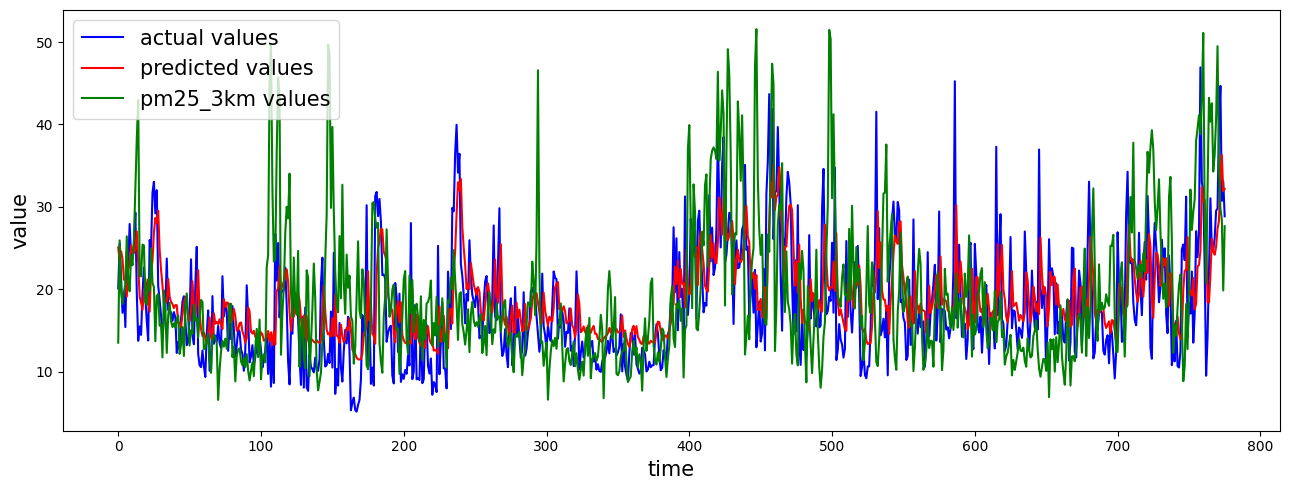

On entire data:
mae: 7.875957292759844
mse: 113.65471755090876
rmse: 10.660896657922764
r2: -0.07128729764249964
mape: 0.34821379393500074
mnbe: 14.79075075838297
r_coeff: 0.4754473311691296
Metrics between actual and predicted
mae: 5.220635992481951
mse: 51.09260531425238
rmse: 7.147909156827078
r2: 0.5184110237034099
mape: 0.24660127464395057
mnbe: 1.7126464103830903
r_coeff: 0.7221417675876785


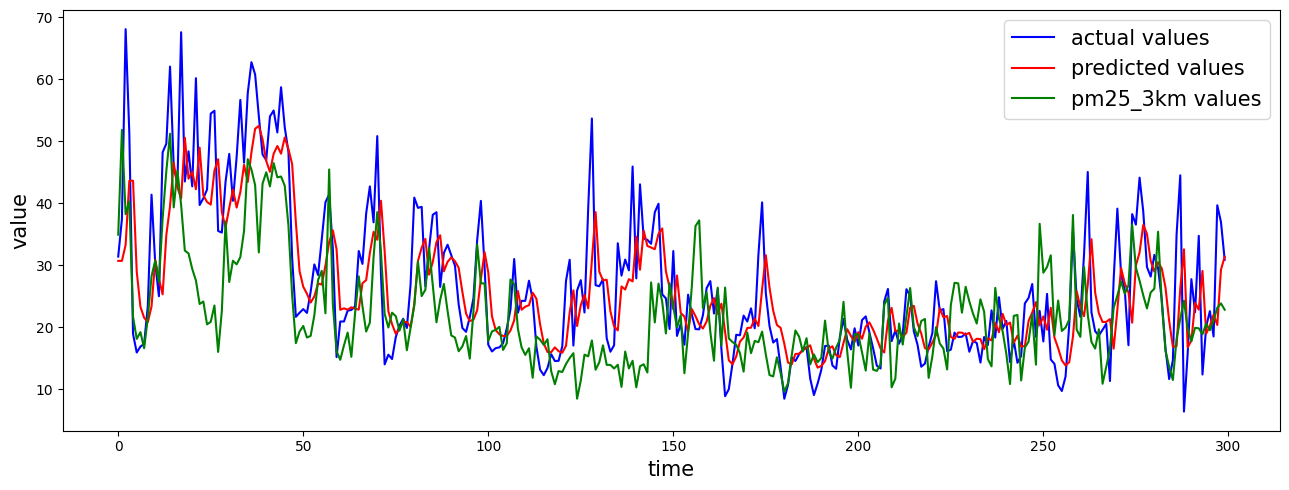

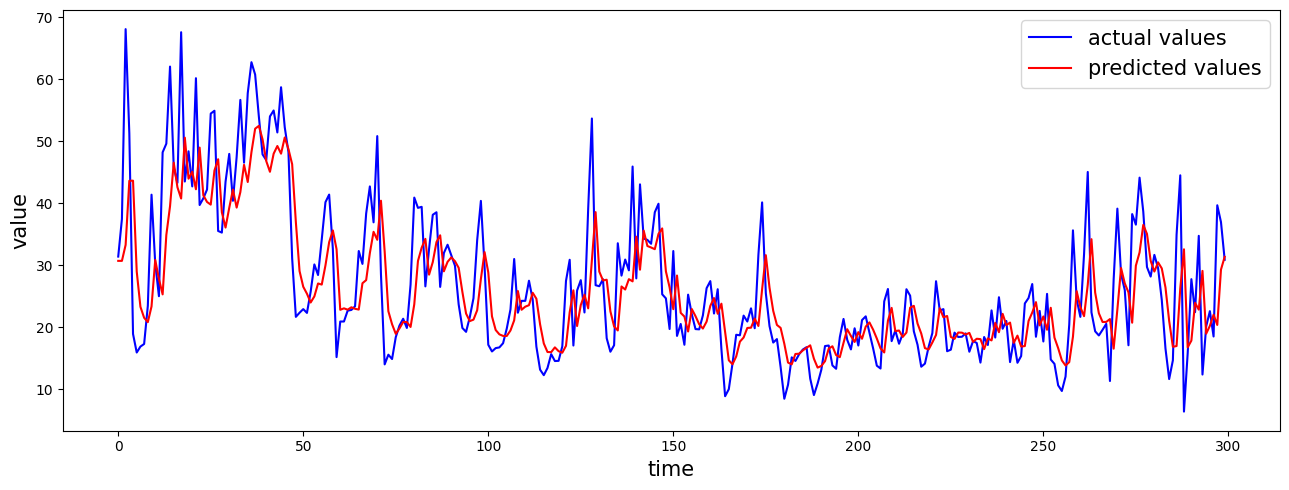

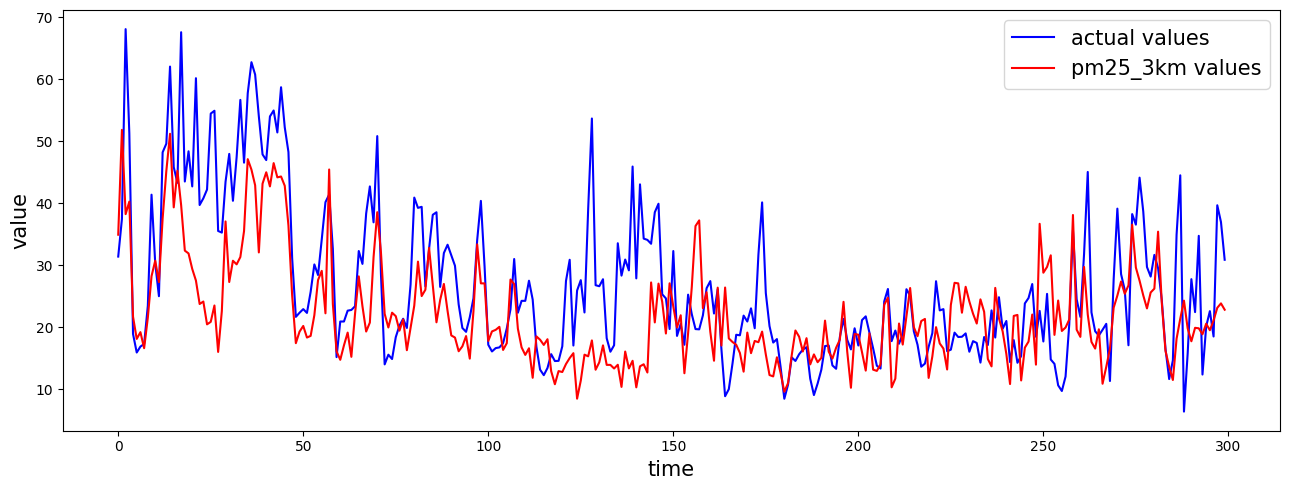

In [55]:

for prediction_n_future, (best_encoded_data, best_evaluation_data, best_encoder_model_path, best_prediction_model_path) in cnnlstms2s_n_future_mapper.items():
    
    print("\n" + "=" * 100 + "\n")
    print(f"PREDICTION WITH N_FUTURE = {prediction_n_future}\n")
    
    # Compare test set only
    all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
    df_cnnlstms2s_reduced = cnnlstms2s_n_future_inference_mapper[prediction_n_future]

    print(all_days_inv_y_pred.shape)
    print(all_days_inv_y_test.shape)
    
    for day in range(prediction_n_future):
        
        print("\n" + "=" * 50 + "\n")
        print(f"Day {day+1}:\n")
        
        current_day_inv_y_pred = all_days_inv_y_pred[:, day]
        current_day_inv_y_test = all_days_inv_y_test[:, day]
        print("current_day_inv_y_pred.shape = ", current_day_inv_y_pred.shape)
        
        test_len = current_day_inv_y_test.shape[0]
        print("test_len = ", test_len)
        
        aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
        
        # Compare test dataset
        print("On test data:")
        print("Metrics between actual and pm25_3km")
        for metric, calculator in metrics_calculators.items():
           print(f"{metric}: {calculator(current_day_inv_y_test, aod_pm25_3km_column_test)}")
        print("Metrics between actual and predicted")
        for metric, calculator in metrics_calculators.items():
           print(f"{metric}: {calculator(current_day_inv_y_test, current_day_inv_y_pred)}")
        plot_3_data(data1=current_day_inv_y_test,
                   datalabel1="actual values",
                   data2=current_day_inv_y_pred,
                   datalabel2="predicted values",
                   data3=aod_pm25_3km_column_test,
                   datalabel3="pm25_3km values",
                   ylabel="value",
                   xlabel="time")
        
        # Compare entire dataset
        print("On entire data:")
        current_day_inv_pred_pm25_from_df_cnnlstms2s_reduced = df_cnnlstms2s_reduced.loc[:, f"predicted_pm25_day_{day+1}"]
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(y_aod.iloc[:, 0], aod_pm25_3km_column)}")
        print("Metrics between actual and predicted")
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(y_aod.iloc[:, 0], current_day_inv_pred_pm25_from_df_cnnlstms2s_reduced)}")
        plot_3_data(data1=y_aod.head(300),
                   datalabel1="actual values",
                   data2=current_day_inv_pred_pm25_from_df_cnnlstms2s_reduced[:300],
                   datalabel2="predicted values",
                   data3=aod_pm25_3km_column.head(300),
                   datalabel3="pm25_3km values",
                   ylabel="value",
                   xlabel="time")
        plot_2_data(data1=y_aod.head(300),
                   datalabel1="actual values",
                   data2=current_day_inv_pred_pm25_from_df_cnnlstms2s_reduced[:300],
                   datalabel2="predicted values",
                   ylabel="value",
                   xlabel="time")
        plot_2_data(data1=y_aod.head(300),
                   datalabel1="actual values",
                   data2=aod_pm25_3km_column.head(300),
                   datalabel2="pm25_3km values",
                   ylabel="value",
                   xlabel="time")

#### Compare MAE with CMAQ pm25

On entire data:
Metrics between actual and cmaq
mae: 8.394844716269084
mse: 131.531765285845
rmse: 11.468729889828472
r2: -0.5079937316171277
mape: 0.4083535368071802
mnbe: 5.784401798824349
r_coeff: 0.257722298418209
Metrics between actual and predicted
mae: 5.537756937487817
mse: 53.87282204277285
rmse: 7.339810763417055
r2: 0.3823554502710743
mape: 0.2800099466815546
mnbe: 1.6393449059472944
r_coeff: 0.6201005858850676


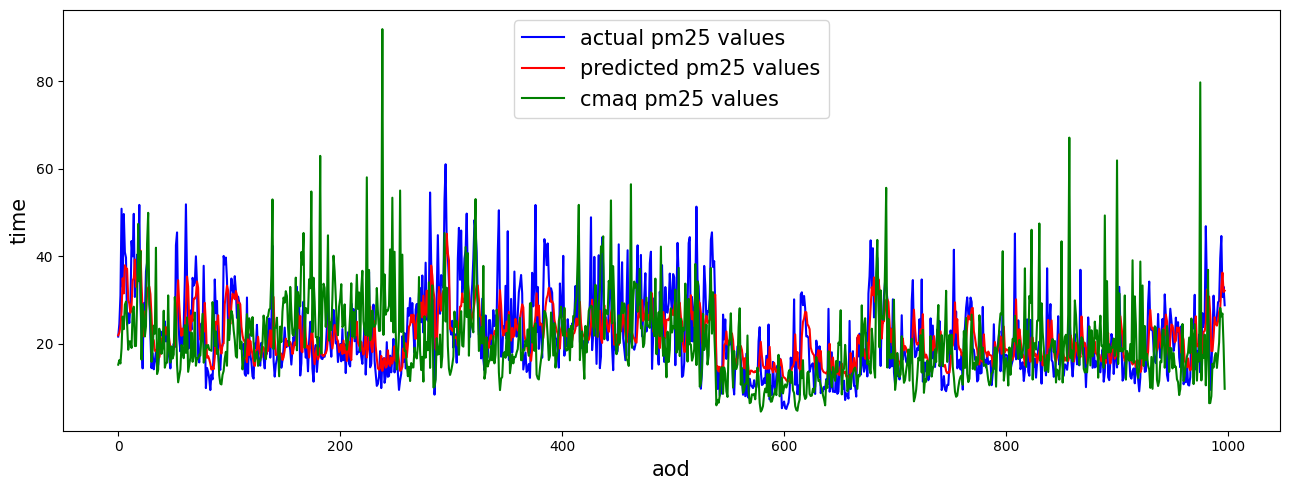

In [56]:

# Remove station 202 for original data
# Only get data in 2022 for AOD
df_aod_dropped_202 = df_aod[df_aod["station"] != 202]
df_aod_dropped_202 = df_aod_dropped_202.loc[((df_aod_dropped_202.index >= "2022-01-01") & (df_aod_dropped_202.index <= "2022-12-31"))]

# After removing 2018-2021 data in AOD, some stations are missing
# so we have so adapt the CMAQ data to fit with AOD data
all_cmaq_data = []
for station in df_aod_dropped_202["station"].unique():
    df_aod_current_station = df_aod_dropped_202[df_aod_dropped_202["station"] == station]
    df_cmaq_current_station = df_cmaq_daily[df_cmaq_daily["station"] == station]
    all_cmaq_data.append(df_cmaq_current_station.loc[df_aod_current_station.index])
df_cmaq_dropped = pd.concat(all_cmaq_data, axis=0)

# Loop over n_future
for prediction_n_future, df_cnnlstms2s_reduced in cnnlstms2s_n_future_inference_mapper.items():
    df_cnnlstms2s_reduced_dropped_202 = df_cnnlstms2s_reduced[df_cnnlstms2s_reduced["station"] != 202]
    time_mask = ((df_cnnlstms2s_reduced_dropped_202.index >= "2022-01-01") & (df_cnnlstms2s_reduced_dropped_202.index <= "2022-12-31"))
    df_cnnlstms2s_reduced_dropped_202 = df_cnnlstms2s_reduced_dropped_202.loc[time_mask]
    
    for day in range(prediction_n_future):
        actual = df_aod_dropped_202["pm25"]
        pred = df_cnnlstms2s_reduced_dropped_202.loc[:, f"predicted_pm25_day_{day+1}"]
        cmaq = df_cmaq_dropped["pm25"]
        
        # Compare entire dataset
        print("On entire data:")
        print("Metrics between actual and cmaq")
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(actual, cmaq)}")
        print("Metrics between actual and predicted")
        for metric, calculator in metrics_calculators.items():
            print(f"{metric}: {calculator(actual, pred)}")
        
        # Compare entire dataset
        plot_3_data(data1=actual,
                   datalabel1="actual pm25 values",
                   data2=pred,
                   datalabel2="predicted pm25 values",
                   data3=cmaq,
                   datalabel3="cmaq pm25 values",
                   ylabel="time",
                   xlabel="aod")

## Evaluation board

In [57]:
pd.DataFrame(evaluation_board)

dim_reduction_method  dim_after_reduction prediction  n_future       mae  \
0         LSTM-Seq2Seq                   10       LSTM         1  4.266625   
1          GRU-Seq2Seq                   17       LSTM         1  4.098607   
2      CNNLSTM-Seq2Seq                   13       LSTM         1  4.543967   
3      CNNLSTM-Seq2Seq                   13       LSTM         1  4.298904   

         mse      rmse        r2      mape      mnbe   r_coeff       p_value  
0  30.222570  5.497506 -0.913026  0.232827  3.635919  0.625307  2.018159e-85  
1  29.835779  5.462214 -0.357493  0.227923  1.842780  0.625704  1.470963e-85  
2  32.872352  5.733442 -1.714669  0.243149  5.367097  0.594016  3.470124e-75  
3  30.988795  5.566758 -0.512710  0.230939  5.505759  0.619913  1.419441e-83

In [58]:
import datetime, pytz
pd.DataFrame(evaluation_board).to_csv(f"evaluation_board_{datetime.datetime.now(pytz.timezone('Asia/Ho_Chi_Minh')).strftime('%H_%M_%d_%m_%Y')}.csv")